# Imports\


TODO:
1) check value/vat/no vat
2) check headlines, fix it


In [1]:
# !export GPN_DB_HOST=192.168.10.36


In [2]:
#!ls -la ../../work
# #!mv ../../../documents.json.zip ../../work
# # !unzip '../../work/documents.json.zip' '../../work/documents.json'
# !mv documents.json ../../work

In [3]:
IMPORT_FRESH_ONLY = True # re-import all if False

In [4]:
import logging
import platform
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from datetime import datetime
import tensorflow as tf

logger = logging.getLogger('retrain_ipynb')
logger.setLevel(logging.DEBUG)


ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(levelname)s - %(asctime)s - %(name)s - %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)
logger.debug('--=logging started=--')

print("tf",tf.__version__)
CPU = platform.processor()
print (f'Running on CPU:{CPU}')



2023-02-16 15:19:55.825421: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
DEBUG - 2023-02-16 15:19:56,401 - retrain_ipynb - --=logging started=--


tf 2.5.0
Running on CPU:x86_64


In [5]:
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
import analyser.hyperparams 

Nemoware Analyser v23.2.7
USING WORKDIR: [/root/artem/work]
 set ENV GPN_WORK_DIR to override
datasets_dir: [/root/artem/work/datasets]
reports_dir: [/root/artem/work/reports]


/root/artem/analyser/analyser/hyperparams.py:15: UserWarning: please set GPN_WORK_DIR environment variable
  warnings.warn('please set GPN_WORK_DIR environment variable')



### Imports...

In [6]:
%matplotlib inline

import pandas as pd
import numpy as np
from pandas import DataFrame

from analyser.finalizer import get_doc_by_id
from analyser.persistence import DbJsonDoc
from integration.db import get_mongodb_connection

from datetime import datetime
from math import log1p
from pandas import DataFrame
from analyser.persistence import DbJsonDoc
from colab_support.renderer import plot_embedding

from analyser.structures import DocumentState

from pathlib import Path
from bson import ObjectId

from datetime import date
from dateutil.relativedelta import relativedelta


from pymongo import ASCENDING

# from tf_support.super_contract_model import seq_labels_contract, seq_labels_contract_swap_orgs
# 


[documents.py:270 -             __init__() ] loading word cases stats model from: /root/artem/analyser/analyser/vocab/word_cases_stats.pickle
[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_USER environment variable! defaulting to None
[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_PASSWORD environment variable! defaulting to None
[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_URL environment variable! defaulting to None


HyperParameters.subsidiary_name_match_min_jaro_similarity 0.9649122807017544


[tools.py:29 -             __init__() ] model_checkpoint_path: /root/artem/analyser/analyser/vocab


In [7]:
import mlflow
mlflow.start_run(run_name='fetch trainset from db')
                 
# experiment_id = mlflow.create_experiment(
#     "Fetching training set from DB",
# #     tags={"version": "v1", "priority": "P1"},
# )                 
# experiment_id

<ActiveRun: >

### Prepare workdir

In [8]:
_work_dir_default = Path(analyser.hyperparams.__file__).parent.parent.parent / 'work'
work_dir = os.environ.get('GPN_WORK_DIR', _work_dir_default)

if not os.path.isdir(work_dir):
    os.mkdir(work_dir)

analyser.hyperparams.work_dir = work_dir
reports_path = Path(analyser.hyperparams.__file__).parent.parent / 'training_reports/'

print('work_dir=', analyser.hyperparams.work_dir)
print('reports_path=', reports_path)
assert os.path.isdir(analyser.hyperparams.work_dir)

work_dir= /root/artem/work
reports_path= /root/artem/analyser/training_reports


### Query DB for contact IDs

#### Load meta data CSV

In [9]:
!touch /root/artem/work/contract_trainset_meta.temp.csv

In [10]:
# stats[["user_correction_date", 'analyze_date']].max().max()

In [11]:
export_fn = str(Path(work_dir) / 'contract_trainset_meta.temp.csv')
# stats = pd.read_csv(export_fn, index_col=0)

try:
    stats = pd.read_csv(export_fn, index_col=0)
    if not 'analyze_date' in stats:
        stats['analyze_date'] = None
        
    if not 'documentType' in stats:
        stats['documentType'] = 'Unknown'
    
    stats['user_correction_date'] = pd.to_datetime(stats['user_correction_date'], utc=True)
    stats['analyze_date'] = pd.to_datetime(stats['analyze_date'], utc=True)

    lastdate = stats[["user_correction_date", 'analyze_date']].max().max()
    mlflow.log_param('last_doc_date',  lastdate)
    
except Exception as ex:
    print(f'ERROR: cannot load {export_fn}')
    logger.exception(ex)
    logger.error(f'cannot load {export_fn}')

    lastdate = datetime(1900, 1, 1)
    stats = DataFrame()
    
    
if not IMPORT_FRESH_ONLY:
    lastdate = datetime(1900, 1, 1)
    
print(f'lastdate={lastdate} ; export_fn={export_fn}')
stats['source'] = 'db'
stats

lastdate=2023-02-16 11:42:53.906000+00:00 ; export_fn=/root/artem/work/contract_trainset_meta.temp.csv


,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,org-2-name,org-2-alias,subject,subject confidence,user_correction_date,valid,documentType,subj_len,headers,subject_pos
5ec2b8da665f7603e03b1255,db,3187bfac60ea578221c5d9357756c6c1,1.6.5,2023-02-11 23:58:52.944266,5847.0,2020-05-18 17:16:38.114000+00:00,25236322.0,17.043795,5674.0,BRL,...,SUN,SUN,Service,1.000000,2023-02-06 10:57:02.292000+00:00,True,CONTRACT,79.0,4.0,1444.0
5fb376e2d8c9df1ed123726c,db,f7c027bb799a50d6fda9d32443bb9cdd,2.0.5,2023-01-31 18:32:26.281114,2794.0,2020-11-17 07:11:23.321000+00:00,2970.0,7.996654,1364.0,RUB,...,Иідате. тьско-ііо. тиі рафнческое предприятие ...,Поставщик,Deal,1.000000,2022-12-08 12:28:06.617000+00:00,True,CONTRACT,82.0,17.0,158.0
5fb399dc39d5e82e90818474,db,375f811ae7c0edcc737d7342373710cb,2.0.5,2023-01-31 18:32:26.380129,3742.0,2020-11-17 09:56:11.605000+00:00,90000.0,11.407576,1834.0,RUB,...,"Фонд исследований, инноваций, инвестиций Тюмен...",Арендодатель,Renting,1.000000,2022-12-07 08:14:03.960000+00:00,True,CONTRACT,97.0,13.0,121.0
5fb3b97d00881c332b567292,db,5f4482e55f27e0fcb20b1ffd819d0260,2.0.5,2023-01-31 18:35:58.018598,2248.0,2020-11-17 12:01:39.924000+00:00,NaN,NaN,NaN,NaN,...,Газпромнефть-Снабжение,Агент,AgencyContract,1.000000,2022-12-08 11:25:15.676000+00:00,True,CONTRACT,86.0,15.0,334.0
5fb3b97e00881c332b5672bd,db,eb69b91855f471b6db8deb924eb34aa5,2.0.5,2023-01-31 18:32:26.391339,3546.0,2020-11-17 12:12:00.629000+00:00,15482412.0,16.555215,699.0,RUB,...,ГазРромнефть-ГЕО,Принципал,AgencyContract,1.000000,2022-12-08 19:01:33.745000+00:00,True,CONTRACT,55.0,19.0,353.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63c506b9e2456d59975e10b3,db,0c028edaf60667d38b29a12999772a0a,23.2.7,2023-02-14 15:40:15.139403,8266.0,2023-02-07 17:29:23.164000+00:00,142956000.0,18.778047,1033.0,RUB,...,Газпромнефть НТЦ,Исполнитель,Service,1.000000,NaT,True,CONTRACT,55.0,40.0,344.0
63c506aee2456d59975e0fc5,db,e1d782e9e5ce6e55863b7f53ced83e51,23.2.7,2023-02-14 15:40:15.191009,2250.0,2023-02-07 17:29:23.999000+00:00,NaN,NaN,NaN,NaN,...,РОСА,ИСПОЛНИТЕЛЬ,Service,0.955178,NaT,True,CONTRACT,32.0,20.0,182.0
63c506bae2456d59975e10bc,db,6fdd4b665d3fea0ff2e8206a2eee1ccb,23.2.7,2023-02-14 15:40:15.239681,7547.0,2023-02-07 17:29:24.606000+00:00,10000.0,9.210440,5460.0,RUB,...,КВАРТЕТ,Поставщик,Deal,1.000000,NaT,True,CONTRACT,29.0,19.0,744.0
628793eb4d1bfe5e5b297dff,db,9cb1a41020a233c28fe3bd4df3071b0e,3.0.0,2023-02-14 15:40:03.394318,1326.0,2022-05-20 16:14:11.196000+00:00,22000.0,9.998843,537.0,NaN,...,Ромашка,Исполнитель,Service,1.000000,2023-02-08 07:47:19.317000+00:00,True,CONTRACT,92.0,10.0,NaN


# functions

In [12]:

def get_amount(attr_tree):
  _value_tag = attr_tree.get('price')
  amount = None
  if _value_tag is not None:
    amount = _value_tag.get('amount_netto')
    if amount is None:
      amount = _value_tag.get('amount_brutto')
    if amount is None:
      amount = _value_tag.get('amount')
  return amount

        
    
def add_stats_record(d: DbJsonDoc, stats: DataFrame, source='db'):
  _id = str(d.get_id())
    
  attr_tree = d.get_attributes_tree()
 

  stats.at[_id, 'checksum'] = d.get_tokens_for_embedding().get_checksum()
  stats.at[_id, 'version'] = d.get_version_string()
  stats.at[_id, 'documentType'] = d.documentType
    
 
  stats.at[_id, 'source'] = source
  stats.at[_id, 'export_date'] = datetime.now()
  stats.at[_id, 'len'] = len(d)
  stats.at[_id, 'analyze_date'] = pd.to_datetime( d.analysis['analyze_timestamp'] , utc=True)


  n_headers = len(d.analysis.get('headers', []))
  stats.at[_id, 'headers'] = n_headers
    
  _value_tag = attr_tree.get('price')
  
  if _value_tag is not None:
    amount = get_amount(attr_tree) 
    if amount:
        
        stats.at[_id, 'value'] = amount.get('value') 
        stats.at[_id, 'value_log1p'] = log1p(amount.get('value') )
        stats.at[_id, 'value_span'] = amount.get('span', [0,0]) [0]
#         print( stats.at[_id, 'value'])
    
    stats.at[_id, 'currency'] = _value_tag.get('currency', {}).get('value')
  
  _orgs = attr_tree.get('orgs', [{},{}]) 
  if len(_orgs)>0:
      stats.at[_id, 'org-1-name'] = _orgs[0].get('name', {}).get('value')
      stats.at[_id, 'org-1-alias'] = _orgs[0].get('alias', {}).get('value')

      if len(_orgs)>1:
        stats.at[_id, 'org-2-name'] = _orgs[1].get('name', {}).get('value')
        stats.at[_id, 'org-2-alias'] = _orgs[1].get('alias', {}).get('value')

  stats.at[_id, 'subject'] = attr_tree.get('subject', {}).get('value')
  stats.at[_id, 'subject confidence'] = attr_tree.get('subject', {}).get('confidence')
    

  span = attr_tree.get('subject', {}).get('span',[0,0])
  subject_len = span[1] - span[0]
  stats.at[_id, 'subj_len'] = subject_len  

  if d.user is not None:
    # if 'attributes_tree' in d.user and 'creation_date' in d.user['attributes_tree']:
    # stats.at[_id, 'user_correction_date'] = d.user['attributes_tree']['creation_date']
    stats.at[_id, 'user_correction_date'] = pd.to_datetime(d.user[ 'updateDate'], utc=True)
    

    # find_in_dict('attributes_tree.creation_date', d.user)

  valid_state = (DocumentState.Excluded.value==d.state or DocumentState.Done.value==d.state)
  if not valid_state:
    print(_id, 'invalid state: ', d.state)
  valid_struct = ('contract' in jd.analysis['attributes_tree'])
  if not valid_struct:
    print(_id, 'invalid structure: ', d.state)
  stats.at[_id, 'valid'] = valid_state and valid_struct and subject_len>0 and subject_len<=300 and n_headers>0


  


d = get_doc_by_id(ObjectId('5fe34f62b770574a005553be'))
jd = DbJsonDoc(d)
add_stats_record(jd, stats)
stats.loc['5fe34f62b770574a005553be']

DB HOST IS: 192.168.10.36


/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_PORT environment variable! defaulting to 27017
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_USER environment variable! defaulting to None
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_PASSWORD environment variable! defaulting to None
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_USE_MONGO_TLS environment variable! defaulting to False
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_TLS_CA environment variable! defaulting to None
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_TLS_KEY environment varia

source                                                db
checksum                da2dd54cdcc5b4480207c9def7741d14
version                                           2.3.13
export_date                   2023-02-16 15:19:58.866367
len                                                  759
analyze_date            2020-12-23 17:14:16.727000+00:00
value                                           1.64e+06
value_log1p                                      14.3102
value_span                                           128
currency                                             RUB
org-1-name                        Газпромнефть-Снабжение
org-1-alias                               Благотворитель
org-2-name                           инициатив «Эпсилон»
org-2-alias                              Благополучатель
subject                                          Charity
subject confidence                                     1
user_correction_date    2022-12-08 19:07:01.522000+00:00
valid                          

# load old json

In [13]:
import json
import re
from bson import json_util

_DEBUG = False
file_data=None

try:
    fn = work_dir / 'documents.json'
    with open(fn) as file:
        file_data = json.load(file, object_hook=json_util.object_hook)

        print(f'total docs in {fn} is {len(file_data)}')    
        _DEBUG = True
except Exception as ex:
    logger.exception(ex)    




if _DEBUG:
    a_doc_from_json=DbJsonDoc(file_data[3])

    print(a_doc_from_json.get_attributes_tree())
    print(a_doc_from_json.get_version_string())

total docs in /root/artem/work/documents.json is 622
{'orgs': [{'type': {'span': [47, 48], 'span_map': 'words', 'confidence': 0.49801500000000004, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [49, 50], 'span_map': 'words', 'confidence': 0.9755, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [56, 57], 'span_map': 'words', 'confidence': 0.972, 'value': 'Арендатор'}}, {'type': {'span': [17, 18], 'span_map': 'words', 'confidence': 0.505665, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [19, 20], 'span_map': 'words', 'confidence': 0.9905, 'value': 'ЭКРУСС'}, 'alias': {'span': [26, 27], 'span_map': 'words', 'confidence': 0.987, 'value': 'Арендодатель'}}], 'date': {'span': [9, 14], 'span_map': 'words', 'confidence': 1, 'value': datetime.datetime(2016, 5, 10, 0, 0, tzinfo=<bson.tz_util.FixedOffset object at 0x7efc2515cbb0>)}, 'number': {'span': [1, 4], 'span_map': 'words', 'confidence': 1, 'value': 'RP 16-06'}, 'subject': {'span': [100, 1

semantic_map_keys_contract ['headline-begin', 'headline-end', 'subject-begin', 'subject-end', 'date-begin', 'date-end', 'number-begin', 'number-end', 'org-name-begin', 'org-name-end', 'org-alias-begin', 'org-alias-end', 'org-type-begin', 'org-type-end', 'amount-begin', 'amount-end', 'amount_brutto-begin', 'amount_brutto-end', 'amount_netto-begin', 'amount_netto-end', 'vat-begin', 'vat-end', 'sign-begin', 'sign-end', 'currency-begin', 'currency-end', 'vat_unit-begin', 'vat_unit-end', 'value-begin', 'value-end']


fixed number: ['№ RP 16-06'] -->  ['RP 16-06']


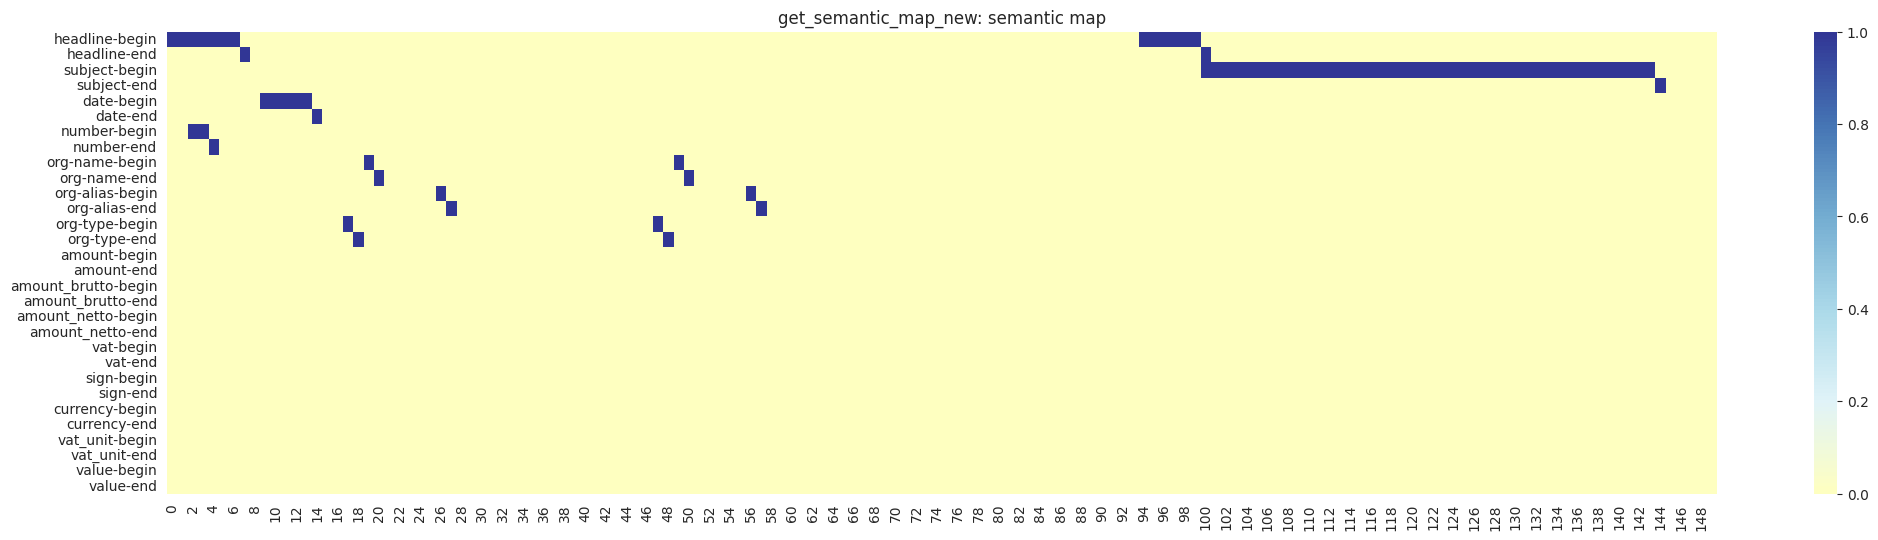

1.0
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
3148    0.0
3149    0.0
3150    0.0
3151    0.0
3152    0.0
Name: date-begin, Length: 3153, dtype: float64


In [14]:

# TODO: import!!!

from tf_support.super_contract_model import get_semantic_map_new, \
        semantic_map_keys_contract, t_semantic_map_keys_common, t_semantic_map_keys_org, t_semantic_map_keys_price

# print("semantic_map_keys", semantic_map_keys[8:14])
# print("semantic_map_keys", semantic_map_keys[4:7])
# print("semantic_map_keys all", semantic_map_keys)
print("semantic_map_keys_contract", semantic_map_keys_contract)

print()
print()




del get_semantic_map_new


def fix_contract_number_span(span:[], textmap)  :
  if span is not None:
    span = [span[0], span[1]] #//typesafety
    for i in range(span[0], span[1]):
      t = textmap[i]
      t = t.strip('_')
      t = t.strip().lstrip('№').lstrip().lstrip(':').lstrip('N ').lstrip().rstrip('.')
      if t == '':
        span[0] = i + 1
    for i in range(span[1], span[0]):
      t = textmap[i]
      t = t.strip('_')
      t = t.strip().lstrip('№').lstrip().lstrip(':').lstrip('N ').lstrip().rstrip('.')
      if t == '':
        span[1] = i - 1
    
#     if span[1]-span[0] == 0:
#       return None

  return span

def get_semantic_map_new(doc) -> DataFrame:
  _len = len(doc)
  df = DataFrame()

  #init datatable with zeros
  for sl in semantic_map_keys_contract:
    df[sl] = np.zeros(_len)

  attr_tree = doc.get_attributes_tree()

  def add_span_vectors(_name, span): 
    bn = _name + "-begin"
    en = _name + "-end"
    if not span is None:
      df[bn][span[0]:span[1]] = 1.
      df[en][span[1]] = 1.

  # Headers
  headers = doc.analysis['headers']
  for h in headers:
    add_span_vectors('headline', h['span'])

  for n in t_semantic_map_keys_common[1:]:  # 1: == skip headers
    span = attr_tree.get(n, {}).get('span')
    if n=='number':
#         print(f'number: {[doc.get_tokens_map_unchaged().text_range(span)]}')
        span1 = fix_contract_number_span(span, doc.get_tokens_map_unchaged() )
        if span!=span1:
            print(f'fixed number: {[doc.get_tokens_map_unchaged().text_range(span)]} -->  {[doc.get_tokens_map_unchaged().text_range(span1)]}')
        span=span1
    if span:
        add_span_vectors(n, span)

  # Orgs:
  for org in attr_tree.get('orgs', []):  # org number (index)
    for org_part_key in t_semantic_map_keys_org:
#       _nm = 'unknown'
#       try:

      org_part = org.get(org_part_key.replace('org-', ''), {})
      if org_part:
        span = org_part.get('span', None)
        add_span_vectors(org_part_key, span)
#       except Exception as e:
#         logger.exception(e)
#         print('ERROR (sp)', e, org_part_key, _nm)

  _value_tag = attr_tree.get('price', {})
  

  if _value_tag is not None:
    add_span_vectors("value", _value_tag.get('span'))
    amount = get_amount(attr_tree)
    if amount:
      add_span_vectors('amount', amount.get('span'))
    
#     print('_value_tag=', _value_tag)
#     print('amount=', amount)
    for n in t_semantic_map_keys_price:
      _value_tag_part = _value_tag.get(n)
#       print('n=', n)
#       print('_value_tag_part=', _value_tag_part)
      if _value_tag_part:
        add_span_vectors(n, _value_tag_part.get('span'))

  return df[semantic_map_keys_contract]


if _DEBUG:
    sm_test = get_semantic_map_new(a_doc_from_json)
    plot_embedding(sm_test[0:150], f'get_semantic_map_new: semantic map')
    print(sm_test['date-begin'].max())
    print(sm_test['date-begin'])

In [15]:
# len(sm_test)
# trimmed = sm_test[0:1200].values.T.copy()

In [16]:
# semantic_map_keys[4:7]
position_enc = np.arange( 1,0, -0.0005)
# # position_enc
# max_pos = min(len(trimmed), len(position_enc))
# trimmed[0:max_pos][-1] = position_enc[0:max_pos]
# plot_embedding(trimmed , f'get_semantic_map_new: semantic map')

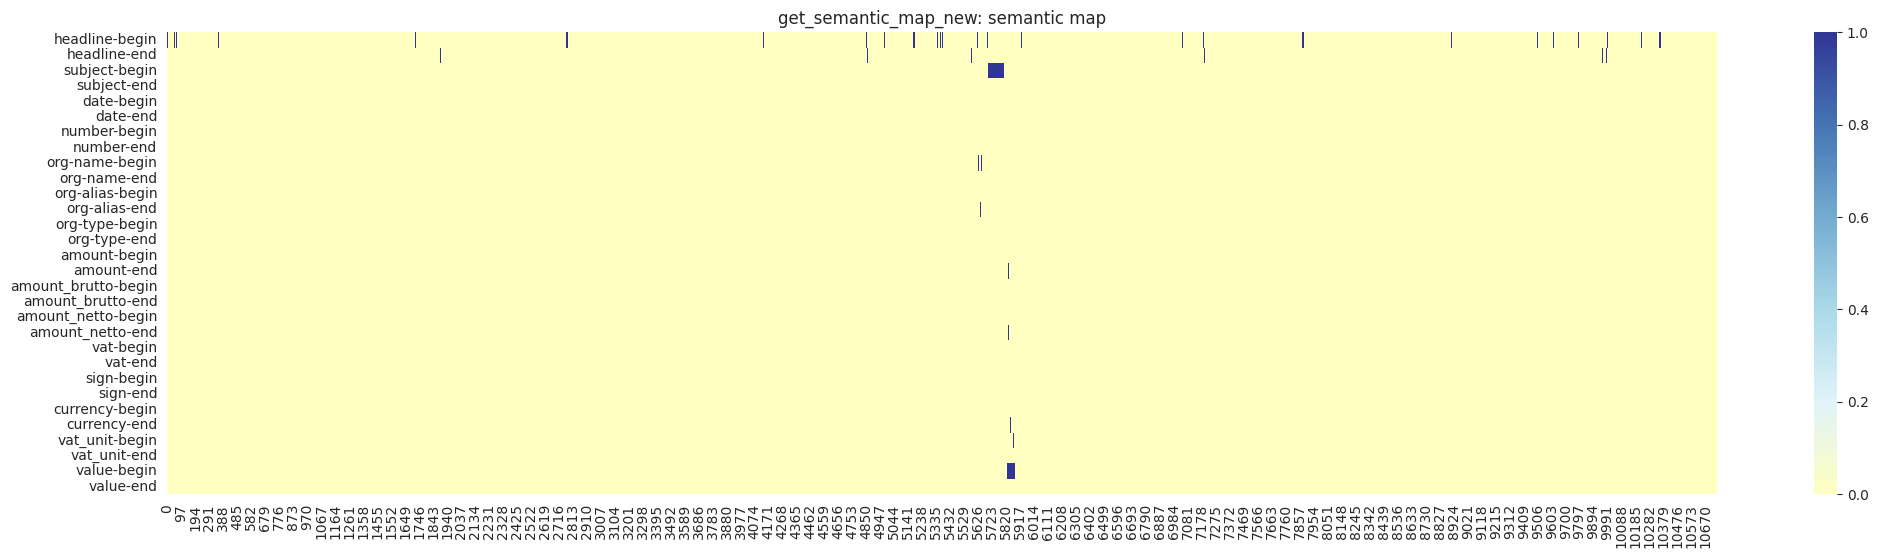

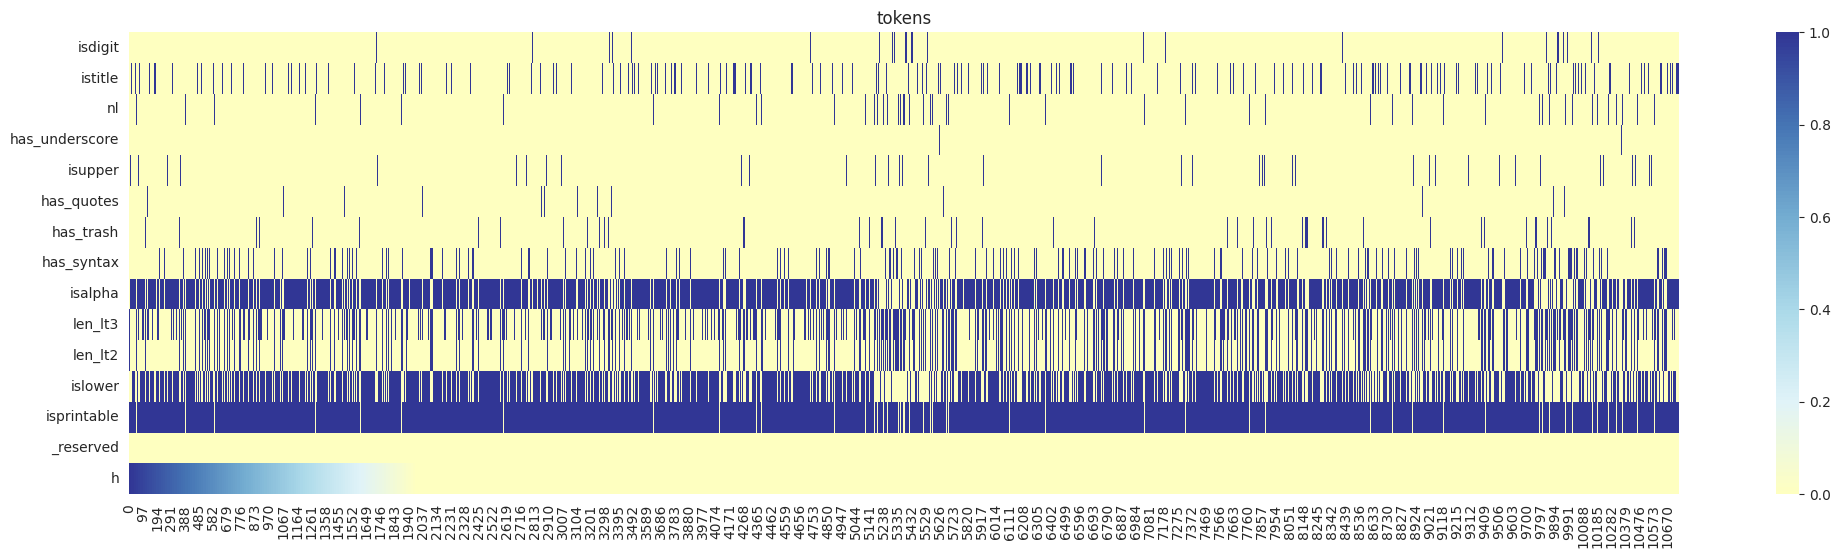

In [17]:
#test one
from analyser.headers_detector import get_tokens_features

d = get_doc_by_id(ObjectId('636dfd1473925c8dae26f910'))
if d is not None:
    jd = DbJsonDoc(d)
    semantic_map: DataFrame = get_semantic_map_new(jd)

    tokens_features = get_tokens_features(jd.get_tokens_map_unchaged().tokens)

    plot_embedding(semantic_map, f'get_semantic_map_new: semantic map')
    plot_embedding(tokens_features, f'tokens')

In [117]:
tokens_features

,isdigit,istitle,nl,has_underscore,isupper,has_quotes,has_trash,has_syntax,isalpha,len_lt3,len_lt2,islower,isprintable,_reserved,h
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10747,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
10748,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
10749,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
10750,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


### Adding data from old json file to the stats table

In [17]:
# fff
files_dict = {}

if file_data:
    k=0
    for d in file_data:
        k+=1 
        jd = DbJsonDoc(d)
    #     print( jd.analysis['analyze_timestamp'])
        files_dict[jd.get_id()] = jd
        try:            
            add_stats_record(jd, stats, source = 'file')
        except Exception as e:
            print(e)
            print(jd.get_id())
#             raise (e)

        if k % 100 == 0:
#             stats['user_correction_date'] = pd.to_datetime(stats['user_correction_date'], utc=False)
#             stats['analyze_date'] = pd.to_datetime(stats['analyze_date'], utc=False)
#             stats['export_date'] = pd.to_datetime(stats['export_date'], utc=False)
            
    
            print(f'{k} of {len(file_data)}')
            stats.to_csv(export_fn, index=True)
            print(f'stats saved to {export_fn}')

            
            
stats.to_csv(export_fn, index=True)
# stats.to_csv('tmp.csv', index=True)

print(f'stats saved to {export_fn}')

# del file_data
stats




100 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
200 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
300 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
400 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv

5efdb73b777d4b67a92d533c
500 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
600 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
stats saved to /root/artem/work/contract_trainset_meta.temp.csv


,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,org-2-name,org-2-alias,subject,subject confidence,user_correction_date,valid,documentType,subj_len,headers,subject_pos
5ec2b8da665f7603e03b1255,db,3187bfac60ea578221c5d9357756c6c1,1.6.5,2023-02-11 23:58:52.944266,5847.0,2020-05-18 17:16:38.114000+00:00,25236322.0,17.043795,5674.0,BRL,...,SUN,SUN,Service,1.0,2023-02-06 10:57:02.292000+00:00,True,CONTRACT,79.0,4.0,1444.0
5fb376e2d8c9df1ed123726c,db,f7c027bb799a50d6fda9d32443bb9cdd,2.0.5,2023-01-31 18:32:26.281114,2794.0,2020-11-17 07:11:23.321000+00:00,2970.0,7.996654,1364.0,RUB,...,Иідате. тьско-ііо. тиі рафнческое предприятие ...,Поставщик,Deal,1.0,2022-12-08 12:28:06.617000+00:00,True,CONTRACT,82.0,17.0,158.0
5fb399dc39d5e82e90818474,db,375f811ae7c0edcc737d7342373710cb,2.0.5,2023-01-31 18:32:26.380129,3742.0,2020-11-17 09:56:11.605000+00:00,90000.0,11.407576,1834.0,RUB,...,"Фонд исследований, инноваций, инвестиций Тюмен...",Арендодатель,Renting,1.0,2022-12-07 08:14:03.960000+00:00,True,CONTRACT,97.0,13.0,121.0
5fb3b97d00881c332b567292,db,5f4482e55f27e0fcb20b1ffd819d0260,2.0.5,2023-01-31 18:35:58.018598,2248.0,2020-11-17 12:01:39.924000+00:00,NaN,NaN,NaN,NaN,...,Газпромнефть-Снабжение,Агент,AgencyContract,1.0,2022-12-08 11:25:15.676000+00:00,True,CONTRACT,86.0,15.0,334.0
5fb3b97e00881c332b5672bd,db,eb69b91855f471b6db8deb924eb34aa5,2.0.5,2023-01-31 18:32:26.391339,3546.0,2020-11-17 12:12:00.629000+00:00,15482412.0,16.555215,699.0,RUB,...,ГазРромнефть-ГЕО,Принципал,AgencyContract,1.0,2022-12-08 19:01:33.745000+00:00,True,CONTRACT,55.0,19.0,353.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5ee188952281f29204c522dc,file,520bf70b9df1ee9ee999fe870d936a51,1.11.2,2023-02-16 14:43:42.036464,7298.0,2020-06-12 22:43:06.038000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,None,NaN,2020-06-11 08:49:53.635000+00:00,False,CONTRACT,0.0,4.0,NaN
5efe9252777d4b67a92d5621,file,ed9385088ed6d9c967a9b68a8d10ecc2,2.0.0,2023-02-16 14:43:50.301459,19504.0,2020-07-03 16:50:25.668000+00:00,65300168.0,17.994505,7412.0,RUB,...,Шлюмберже Лоджелко Инк.,Исполнитель,None,NaN,NaT,False,CONTRACT,0.0,26.0,NaN
5efe9280777d4b67a92d56ce,file,02a4101c17ceaa4b9d473f6840ac4d7a,2.0.0,2023-02-16 14:43:51.538559,14025.0,2020-07-03 21:47:22.279000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,None,NaN,NaT,False,CONTRACT,0.0,2.0,NaN
5efe9288777d4b67a92d56d3,file,33f326573547c95e1d381eecd79136a2,2.0.0,2023-02-16 14:43:51.843676,19219.0,2020-07-03 21:15:51.170000+00:00,NaN,NaN,NaN,NaN,...,Газпромнефть-Сахалин,Исполнитель,None,NaN,NaT,False,CONTRACT,0.0,25.0,NaN


In [18]:
# stats = stats.drop('63c506afe2456d59975e0fcd')
stats[stats.index.duplicated()]



,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,org-2-name,org-2-alias,subject,subject confidence,user_correction_date,valid,documentType,subj_len,headers,subject_pos


In [19]:
invalid = stats[stats['valid']==False]
print(f'{len(invalid)}: number of invalid records')
invalid

79: number of invalid records


,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,org-2-name,org-2-alias,subject,subject confidence,user_correction_date,valid,documentType,subj_len,headers,subject_pos
6294a954df54d406a99b1609,db,d91842f8e8efddca7b510c0189c63b60,3.0.0,2023-01-31 18:20:56.048598,332.0,2022-05-30 14:24:46.357000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,Other,0.851158,NaT,False,ANNEX,0.0,1.0,0.0
629f3c5641f3e78db0acc5b8,db,4ecbbb3be3f5cf72dc4fc5297b1d19aa,3.0.0,2023-01-31 18:20:56.362241,594.0,2022-06-07 14:54:51.461000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,Other,0.983589,NaT,False,ANNEX,0.0,7.0,0.0
629f4de641f3e78db0acc646,db,fe52f1224a5ce4ca16944ff32d85cbef,3.0.0,2023-01-31 18:20:56.584720,497.0,2022-06-07 16:10:41.821000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,Other,0.986827,NaT,False,ANNEX,0.0,3.0,0.0
62a995e1326a4191e5f1733a,db,66b2f4517ed05642fa198eb5fcec20fb,3.0.0,2023-01-31 18:20:56.604327,186.0,2022-06-15 11:28:41.950000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,Other,0.986064,NaT,False,ANNEX,0.0,2.0,0.0
62a9bf57326a4191e5f17479,db,e881224a8a4a1157b05da989d565c883,3.0.0,2023-01-31 18:20:57.794234,158.0,2022-06-15 14:21:42.518000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,Other,0.970418,NaT,False,ANNEX,0.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5ee188952281f29204c522dc,file,520bf70b9df1ee9ee999fe870d936a51,1.11.2,2023-02-16 14:43:42.036464,7298.0,2020-06-12 22:43:06.038000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,None,NaN,2020-06-11 08:49:53.635000+00:00,False,CONTRACT,0.0,4.0,NaN
5efe9252777d4b67a92d5621,file,ed9385088ed6d9c967a9b68a8d10ecc2,2.0.0,2023-02-16 14:43:50.301459,19504.0,2020-07-03 16:50:25.668000+00:00,65300168.0,17.994505,7412.0,RUB,...,Шлюмберже Лоджелко Инк.,Исполнитель,None,NaN,NaT,False,CONTRACT,0.0,26.0,NaN
5efe9280777d4b67a92d56ce,file,02a4101c17ceaa4b9d473f6840ac4d7a,2.0.0,2023-02-16 14:43:51.538559,14025.0,2020-07-03 21:47:22.279000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,None,NaN,NaT,False,CONTRACT,0.0,2.0,NaN
5efe9288777d4b67a92d56d3,file,33f326573547c95e1d381eecd79136a2,2.0.0,2023-02-16 14:43:51.843676,19219.0,2020-07-03 21:15:51.170000+00:00,NaN,NaN,NaN,NaN,...,Газпромнефть-Сахалин,Исполнитель,None,NaN,NaT,False,CONTRACT,0.0,25.0,NaN


In [20]:
# !tail /root/artem/work/contract_trainset_meta.temp.csv

# Fetch fresh docs from Mongo DB

In [21]:


# if True:
lastdate = lastdate + relativedelta(days=-5)
#     lastdate = datetime.combine(lastdate, datetime.min.time())

lastdate = pd.to_datetime( lastdate , utc=True)
lastdate

Timestamp('2023-02-11 11:15:39.376000+0000', tz='UTC')

In [22]:
yesterday = datetime.now() + relativedelta(days=-1)  
# {'analysis.analyze_timestamp': {'$gt': yesterday}},



query = {'user.updateDate': {'$gt': yesterday}}
db = get_mongodb_connection()
documents_collection = db['documents']
sorting = [('analysis.analyze_timestamp', ASCENDING), ('user.updateDate', ASCENDING)]
res = documents_collection.find(filter=query, 
                                sort=sorting,
                                projection={'_id': True, 'user.updateDate':True, 'state':True, 'parse.documentType':True}
                               ).limit(5000)

_r = list([i for i in res])
# print(res[0])
_s = f"#### Всего размечено документов после {yesterday} : {len(_r)}"
display(Markdown(_s))
yseterday_ids=[i["_id"] for i in _r]


/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)


#### Всего размечено документов после 2023-02-15 14:43:55.114601 : 25

In [23]:
from pymongo import ASCENDING

query = {
  '$and': [
    {"parse.documentType":{ '$in': ["AGREEMENT", "CONTRACT", "SUPPLEMENTARY_AGREEMENT"] }  },
      
#     {"state": 15},
    {'$or': [
          {"analysis.attributes_tree": {"$ne": None}},
          {"user.attributes_tree": {"$ne": None}}
        ]},
#       {'$and': [
#           {"user.updateDate": {"$ne": None}},
#           {'user.updateDate': {'$gt': lastdate}}
#       ]}
#     {"user.attributes_tree.contract.people": {"$ne": None}}

    #     {'$or': [
    #         {"user.attributes_tree.contract.price.amount_netto": {"$ne": None}},
    #         {"user.attributes_tree.contract.price.amount_brutto": {"$ne": None}}
    #     ]}
    {'$or': [
      {'analysis.analyze_timestamp': {'$gt': lastdate}}, 
      {'user.updateDate': {'$gt': lastdate}}
    ]}
  ]
}

db = get_mongodb_connection()
documents_collection = db['documents']
sorting = [('analysis.analyze_timestamp', ASCENDING), ('user.updateDate', ASCENDING)]
res = documents_collection.find(filter=query, 
                                sort=sorting,
                                projection={'_id': True, 'user.updateDate':True, 'state':True, 'parse.documentType':True}
#                                             'analysis.attributes_tree.version': True,
#                                             'analysis.attributes_tree.contract.subject': True}
                               ).limit(5000)

res = list([i for i in res])
# print(res[0])
_s = f"#### Всего новых документов после {lastdate} : {len(res)}"
display(Markdown(_s))

res[:4]

#### Всего новых документов после 2023-02-11 11:15:39.376000+00:00 : 39

[{'_id': ObjectId('5e6101650cf5aa0cfe37d10b'),
  'parse': {'documentType': 'CONTRACT'},
  'state': 15,
  'user': {'updateDate': datetime.datetime(2023, 2, 11, 21, 7, 39, 872000)}},
 {'_id': ObjectId('5ec2b8da665f7603e03b127a'),
  'parse': {'documentType': 'CONTRACT'},
  'state': 12,
  'user': {'updateDate': datetime.datetime(2023, 2, 11, 20, 29, 12, 536000)}},
 {'_id': ObjectId('5ec2b8d9665f7603e03b1238'),
  'parse': {'documentType': 'CONTRACT'},
  'state': 12,
  'user': {'updateDate': datetime.datetime(2023, 2, 15, 16, 44, 29, 749000)}},
 {'_id': ObjectId('5fb3d4a078df3635f5441c6d'),
  'user': {'updateDate': datetime.datetime(2023, 2, 16, 7, 3, 44, 725000)},
  'state': 12,
  'parse': {'documentType': 'CONTRACT'}}]

# Prepare training set

In [24]:
new_docs_ids = docs_ids = [i["_id"] for i in res]
print(len(new_docs_ids))
# sample_id = ObjectId('637f7bf0e712cc2ff2e943d3')

# sample_id = docs_ids[1]
# sample_id
# d = get_doc_by_id(sample_id)

# jd = DbJsonDoc(d)
# jd.get_id()
# print(d['_id'])


#==========================Test 1 doc
    
# print(jd.get_version_string())
 
# add_stats_record(jd, stats)
# stats.loc[str(jd._id)]
 

39


In [25]:
# plot_embedding(get_semantic_map_new(jd)[:300], f'semantic map')
# print(len(docs_ids))

In [26]:
def add_to_stats_list(docs_ids):
    for k, oid in enumerate(docs_ids):
        d = get_doc_by_id(ObjectId(str(oid)))
        try:
            jd = DbJsonDoc(d)
            add_stats_record(jd, stats)
        except Exception as e:
            print(oid)
            print (e)

        if k % 100 == 0:
            print(f'{k} of {len(docs_ids)}')
            stats.to_csv(export_fn, index=True)
            print(f'stats saved to {export_fn}')
        
add_to_stats_list(docs_ids)        
stats.to_csv(export_fn, index=True)
print(f'stats saved to {export_fn}')
stats

0 of 39
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
stats saved to /root/artem/work/contract_trainset_meta.temp.csv


,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,org-2-name,org-2-alias,subject,subject confidence,user_correction_date,valid,documentType,subj_len,headers,subject_pos
5ec2b8da665f7603e03b1255,db,3187bfac60ea578221c5d9357756c6c1,1.6.5,2023-02-11 23:58:52.944266,5847.0,2020-05-18 17:16:38.114000+00:00,25236322.0,17.043795,5674.0,BRL,...,SUN,SUN,Service,1.0,2023-02-06 10:57:02.292000+00:00,True,CONTRACT,79.0,4.0,1444.0
5fb376e2d8c9df1ed123726c,db,f7c027bb799a50d6fda9d32443bb9cdd,2.0.5,2023-01-31 18:32:26.281114,2794.0,2020-11-17 07:11:23.321000+00:00,2970.0,7.996654,1364.0,RUB,...,Иідате. тьско-ііо. тиі рафнческое предприятие ...,Поставщик,Deal,1.0,2022-12-08 12:28:06.617000+00:00,True,CONTRACT,82.0,17.0,158.0
5fb399dc39d5e82e90818474,db,375f811ae7c0edcc737d7342373710cb,2.0.5,2023-01-31 18:32:26.380129,3742.0,2020-11-17 09:56:11.605000+00:00,90000.0,11.407576,1834.0,RUB,...,"Фонд исследований, инноваций, инвестиций Тюмен...",Арендодатель,Renting,1.0,2022-12-07 08:14:03.960000+00:00,True,CONTRACT,97.0,13.0,121.0
5fb3b97d00881c332b567292,db,5f4482e55f27e0fcb20b1ffd819d0260,2.0.5,2023-01-31 18:35:58.018598,2248.0,2020-11-17 12:01:39.924000+00:00,NaN,NaN,NaN,NaN,...,Газпромнефть-Снабжение,Агент,AgencyContract,1.0,2022-12-08 11:25:15.676000+00:00,True,CONTRACT,86.0,15.0,334.0
5fb3b97e00881c332b5672bd,db,eb69b91855f471b6db8deb924eb34aa5,2.0.5,2023-01-31 18:32:26.391339,3546.0,2020-11-17 12:12:00.629000+00:00,15482412.0,16.555215,699.0,RUB,...,ГазРромнефть-ГЕО,Принципал,AgencyContract,1.0,2022-12-08 19:01:33.745000+00:00,True,CONTRACT,55.0,19.0,353.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5efe9280777d4b67a92d56ce,file,02a4101c17ceaa4b9d473f6840ac4d7a,2.0.0,2023-02-16 14:43:51.538559,14025.0,2020-07-03 21:47:22.279000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,None,NaN,NaT,False,CONTRACT,0.0,2.0,NaN
5efe9288777d4b67a92d56d3,file,33f326573547c95e1d381eecd79136a2,2.0.0,2023-02-16 14:43:51.843676,19219.0,2020-07-03 21:15:51.170000+00:00,NaN,NaN,NaN,NaN,...,Газпромнефть-Сахалин,Исполнитель,None,NaN,NaT,False,CONTRACT,0.0,25.0,NaN
5f016dee777d4b67a92d5840,file,4ea9485a7c529809ed110d0c77f2e16f,2.0.0,2023-02-16 14:43:52.101324,27.0,2020-07-05 14:13:31.165000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,None,NaN,NaT,False,CONTRACT,0.0,0.0,NaN
63ce4a56e83d1ee490f3f790,db,eba4652ce14ca4ccc81744f87358463f,23.01.23,2023-02-16 14:43:56.280367,321.0,2023-01-25 02:59:48.538000+00:00,NaN,NaN,NaN,NaN,...,None,None,None,NaN,2023-02-12 09:08:11.045000+00:00,False,SUPPLEMENTARY_AGREEMENT,0.0,2.0,NaN


In [27]:
# _ids = list(
#     stats[stats['source']=='db']
#     [stats['documentType']=='undefined'][ stats['user_correction_date'].notna()].index)


# add_to_stats_list(_ids)        
# stats.to_csv(export_fn, index=True)

s = stats[ stats['source']=='db'] 
# s = s[s['documentType']=='CONTRACT']
# s = s[s['subj_len'].isna()]
# s = s[s['user_correction_date'].notna()]
# s = s[s['value']>0]
_ids = list(s[s['headers'].isna()].index)
print(len(_ids))
add_to_stats_list(_ids)     
print(f'saving to {export_fn}; {len(stats)} records')
stats.to_csv(export_fn, index=True)

13
637397e2a8eb8dc64b37543b
'NoneType' object is not iterable
0 of 13
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
637397e2a8eb8dc64b37543c
'NoneType' object is not iterable
637397e2a8eb8dc64b37543d
'NoneType' object is not iterable
637397e2a8eb8dc64b37543f
'NoneType' object is not iterable
637397e2a8eb8dc64b375440
'NoneType' object is not iterable
637397e2a8eb8dc64b375441
'NoneType' object is not iterable
637397e2a8eb8dc64b37543a
'NoneType' object is not iterable
637397e2a8eb8dc64b37543e
'NoneType' object is not iterable
637e11d66a07f3e980b2bfbf
'NoneType' object is not iterable
637e11d76a07f3e980b2bfc0
'NoneType' object is not iterable
637f2826fe09513dc6b2bfbf
'NoneType' object is not iterable
637f2826fe09513dc6b2bfc0
'NoneType' object is not iterable
637f725ec15a83c52bb2bfc1
'NoneType' object is not iterable
saving to /root/artem/work/contract_trainset_meta.temp.csv; 5855 records


/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)


In [28]:
stats = stats[stats.valid!=False]
len(stats)

5774

In [29]:
stats2 = stats.copy()
stats2['org-2-alias'] = stats2['org-2-alias'].str.lower()
stats2['org-1-alias'] = stats2['org-1-alias'].str.lower()
stats2['org-1-name'] = stats2['org-1-name'].str.lower()
stats2['org-2-name'] = stats2['org-2-name'].str.lower()
stats2

,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,org-2-name,org-2-alias,subject,subject confidence,user_correction_date,valid,documentType,subj_len,headers,subject_pos
5ec2b8da665f7603e03b1255,db,3187bfac60ea578221c5d9357756c6c1,1.6.5,2023-02-11 23:58:52.944266,5847.0,2020-05-18 17:16:38.114000+00:00,25236322.0,17.043795,5674.0,BRL,...,sun,sun,Service,1.000000,2023-02-06 10:57:02.292000+00:00,True,CONTRACT,79.0,4.0,1444.0
5fb376e2d8c9df1ed123726c,db,f7c027bb799a50d6fda9d32443bb9cdd,2.0.5,2023-01-31 18:32:26.281114,2794.0,2020-11-17 07:11:23.321000+00:00,2970.0,7.996654,1364.0,RUB,...,иідате. тьско-ііо. тиі рафнческое предприятие ...,поставщик,Deal,1.000000,2022-12-08 12:28:06.617000+00:00,True,CONTRACT,82.0,17.0,158.0
5fb399dc39d5e82e90818474,db,375f811ae7c0edcc737d7342373710cb,2.0.5,2023-01-31 18:32:26.380129,3742.0,2020-11-17 09:56:11.605000+00:00,90000.0,11.407576,1834.0,RUB,...,"фонд исследований, инноваций, инвестиций тюмен...",арендодатель,Renting,1.000000,2022-12-07 08:14:03.960000+00:00,True,CONTRACT,97.0,13.0,121.0
5fb3b97d00881c332b567292,db,5f4482e55f27e0fcb20b1ffd819d0260,2.0.5,2023-01-31 18:35:58.018598,2248.0,2020-11-17 12:01:39.924000+00:00,NaN,NaN,NaN,NaN,...,газпромнефть-снабжение,агент,AgencyContract,1.000000,2022-12-08 11:25:15.676000+00:00,True,CONTRACT,86.0,15.0,334.0
5fb3b97e00881c332b5672bd,db,eb69b91855f471b6db8deb924eb34aa5,2.0.5,2023-01-31 18:32:26.391339,3546.0,2020-11-17 12:12:00.629000+00:00,15482412.0,16.555215,699.0,RUB,...,газрромнефть-гео,принципал,AgencyContract,1.000000,2022-12-08 19:01:33.745000+00:00,True,CONTRACT,55.0,19.0,353.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63c506b9e2456d59975e10b3,db,0c028edaf60667d38b29a12999772a0a,23.2.7,2023-02-14 15:40:15.139403,8266.0,2023-02-07 17:29:23.164000+00:00,142956000.0,18.778047,1033.0,RUB,...,газпромнефть нтц,исполнитель,Service,1.000000,NaT,True,CONTRACT,55.0,40.0,344.0
63c506aee2456d59975e0fc5,db,e1d782e9e5ce6e55863b7f53ced83e51,23.2.7,2023-02-14 15:40:15.191009,2250.0,2023-02-07 17:29:23.999000+00:00,NaN,NaN,NaN,NaN,...,роса,исполнитель,Service,0.955178,NaT,True,CONTRACT,32.0,20.0,182.0
63c506bae2456d59975e10bc,db,6fdd4b665d3fea0ff2e8206a2eee1ccb,23.2.7,2023-02-14 15:40:15.239681,7547.0,2023-02-07 17:29:24.606000+00:00,10000.0,9.210440,5460.0,RUB,...,квартет,поставщик,Deal,1.000000,NaT,True,CONTRACT,29.0,19.0,744.0
628793eb4d1bfe5e5b297dff,db,9cb1a41020a233c28fe3bd4df3071b0e,3.0.0,2023-02-14 15:40:03.394318,1326.0,2022-05-20 16:14:11.196000+00:00,22000.0,9.998843,537.0,NaN,...,ромашка,исполнитель,Service,1.000000,2023-02-08 07:47:19.317000+00:00,True,CONTRACT,92.0,10.0,NaN


In [30]:
stats2['subject'].value_counts()

Service                              2149
Other                                1946
Deal                                  515
Renting                               207
GeneralContract                       204
Loans                                 191
AgencyContract                         97
DealIntellectualProperty               93
Charity                                82
Insurance                              59
RealEstate                             35
ParticipationInOtherOrganizations      26
RealEstateTransactions                 24
PledgeEncumbrance                      20
BankGuarantees                         18
SecuritiesTransactions                 12
BigDeal                                 2
EmployeeContracts                       2
AssetTransactions                       2
Name: subject, dtype: int64

In [31]:
stats2['org-1-alias'].value_counts()

заказчик                 1552
исполнитель               631
покупатель                355
поставщик                 163
продавец                  138
                         ... 
фонд                        1
тзк                         1
участник                    1
газпромнефть-терминал       1
гпн                         1
Name: org-1-alias, Length: 96, dtype: int64

In [32]:
stats2['org-2-alias'].value_counts()

исполнитель      1248
заказчик          667
поставщик         300
покупатель        274
подрядчик         268
                 ... 
приказодатель       1
весна               1
поверенный          1
эмитент             1
жертвователь        1
Name: org-2-alias, Length: 98, dtype: int64

In [33]:
score_column_name = "score"

def calc_no_value_importance(stats2, column_name, score_k=2.):
        
    for i, row in stats2.iterrows():
        if pd.isna(row[column_name]):
            stats2.at[i, score_column_name] *= score_k
                
def calc_user_importance(stats2):
        
    for i, row in stats2.iterrows():
        if not pd.isna(row['unseen']):

            if row['unseen'] == True:
                stats2.at[i, score_column_name] *= 2
                
def calc_val_importance(stats2):
 
    for i, row in stats2.iterrows():
        if not pd.isna(row['value']):
            val = row['value']
            if val >= 2000:
                stats2.at[i, score_column_name] *= 1./log1p(val)
            if val < 2000:
                stats2.at[i, score_column_name] *= 4.
        else:
            stats2.at[i, score_column_name] *= 10.0 #error
            
def calc_column_val_importance(stats2, column_name, k=1.):
    counts = stats2[column_name].value_counts()
 
        
    for i, row in stats2.iterrows():
        val = row[column_name]
        if val in counts:
            count = counts[val]
            stats2.at[i, score_column_name] *= k * log1p(count)
#             print(count, log1p(count),  1./log1p(count))
        else:
            stats2.at[i, score_column_name] *= 10.0 #error

            
for i, row in stats2.iterrows():        
  stats2.at[i, 'url'] = f'http://gpn-audit.nemosoft.ru/#/audit/edit/{i}'

    
stats2 ['unseen'] = pd.isna( stats2['user_correction_date'])

stats2[score_column_name] = 1.
 

calc_no_value_importance(stats2, 'org-1-alias', 2.)
calc_no_value_importance(stats2, 'org-2-alias', 2.)
calc_no_value_importance(stats2, 'org-1-name', 3.)
calc_no_value_importance(stats2, 'org-2-name', 3.)
calc_no_value_importance(stats2, 'user_correction_date', 10.)
calc_no_value_importance(stats2, 'subject', 4.)
calc_no_value_importance(stats2, 'value', 5.)

## calc_column_val_importance(stats2, 'org-1-name')
## calc_column_val_importance(stats2, 'org-2-name')

calc_column_val_importance(stats2, 'org-1-alias')
calc_column_val_importance(stats2, 'org-2-alias')
calc_column_val_importance(stats2, 'subject', k = 3.)

calc_user_importance(stats2)
calc_val_importance(stats2)

# drop_duplicates(subset=['checksum']).
stats2 = stats2.sort_values([score_column_name], ascending=True)
print(len(stats2))
stats2.head(40)

5774


,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,subject confidence,user_correction_date,valid,documentType,subj_len,headers,subject_pos,url,unseen,score
5ec2b8da665f7603e03b1255,db,3187bfac60ea578221c5d9357756c6c1,1.6.5,2023-02-11 23:58:52.944266,5847.0,2020-05-18 17:16:38.114000+00:00,2.523632e+07,17.043795,5674.0,BRL,...,1.000000,2023-02-06 10:57:02.292000+00:00,True,CONTRACT,79.0,4.0,1444.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5ec2...,False,0.648909
5edbc62eda3678279fbcadf3,file,027a7c30f74ff8ffe684378e9883dd8e,2.0.2,2023-02-16 14:43:38.749063,1373.0,2020-07-18 20:24:58.934000+00:00,2.400000e+04,10.085851,747.0,RUB,...,0.646182,2020-07-18 12:24:26.280000+00:00,True,CONTRACT,106.0,10.0,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/5edb...,False,0.655233
5ded4e284ddc27bcf92dd6ce,file,9a44591c17d2b8f34dc8f1c3600c8c3a,1.11.2,2023-02-16 14:43:34.979608,460.0,2020-06-12 21:09:19.574000+00:00,5.900000e+05,13.287880,150.0,RUB,...,0.000000,2020-06-09 00:40:54.752000+00:00,True,CONTRACT,30.0,5.0,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/5ded...,False,0.759703
63ce49f8e83d1ee490f3f21c,db,25d924fc09b7291d964f464f9c3ec8c3,23.1.27.1,2023-02-03 16:19:06.576376,8535.0,2023-01-28 09:34:50.691000+00:00,3.000000e+09,21.821878,337.0,RUB,...,1.000000,2023-01-28 01:38:49.198000+00:00,True,CONTRACT,53.0,12.0,100.0,http://gpn-audit.nemosoft.ru/#/audit/edit/63ce...,False,1.153584
633fd0a69d08c565cfa1232a,db,61cfee32867b371843d1e95a194ea2a6,3.0.0,2023-02-01 17:26:54.225685,5556.0,2022-10-07 10:10:07.028000+00:00,1.000000e+11,25.328436,1505.0,RUB,...,1.000000,2023-01-27 11:36:12.388000+00:00,True,CONTRACT,37.0,17.0,395.0,http://gpn-audit.nemosoft.ru/#/audit/edit/633f...,False,1.746836
6246a3fa25a983726c7694af,db,61cfee32867b371843d1e95a194ea2a6,3.0.0,2023-02-16 14:43:55.693904,5556.0,2022-04-01 10:21:21.897000+00:00,1.000000e+11,25.328436,1505.0,None,...,1.000000,2023-02-12 08:47:18.437000+00:00,True,CONTRACT,37.0,17.0,395.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6246...,False,1.746836
6285f9c04d1bfe5e5b297ddd,db,61cfee32867b371843d1e95a194ea2a6,3.0.0,2023-02-01 17:26:53.153480,5556.0,2022-05-19 11:03:36.611000+00:00,1.000000e+11,25.328436,1505.0,RUB,...,1.000000,2023-01-27 11:32:42.657000+00:00,True,CONTRACT,37.0,17.0,395.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6285...,False,1.746836
62dfbce15d5a202ba67b842d,db,61cfee32867b371843d1e95a194ea2a6,3.0.0,2023-02-16 14:23:47.515008,5556.0,2022-07-26 13:08:03.309000+00:00,1.000000e+11,25.328436,1505.0,RUB,...,1.000000,2023-02-11 07:21:05.058000+00:00,True,CONTRACT,37.0,17.0,395.0,http://gpn-audit.nemosoft.ru/#/audit/edit/62df...,False,1.746836
63908ca4a1bded13e629f2eb,db,3bc04887446d02692e886db2545bba61,22.12.7,2023-01-31 18:38:08.500901,13410.0,2022-12-08 13:59:29.898000+00:00,2.000000e+10,23.718998,2572.0,RUB,...,1.000000,2022-12-08 11:04:21.263000+00:00,True,AGREEMENT,84.0,21.0,2222.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6390...,False,1.805167
63908ca3a1bded13e629f2dc,db,778e9604f0dfb6ed01dc05cce32ab2c2,22.12.7,2023-02-16 14:43:56.267451,4892.0,2022-12-08 21:48:02.600000+00:00,7.000000e+09,22.669176,399.0,None,...,1.000000,2023-02-11 20:09:39.660000+00:00,True,CONTRACT,121.0,11.0,148.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6390...,False,1.971416


In [34]:
# sub = stats2.sort_values(['score'], ascending=True).copy()
# sub

## Find and remove duplicates

In [35]:
stats2['len'] //= 10 #similar lens
stats2['len'] *= 10 #similar lens
stats2.sort_values(['len', 'org-1-name', 'org-2-name', 'org-1-alias','org-2-alias', 'value', 'subject'], ascending=False)

,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,subject confidence,user_correction_date,valid,documentType,subj_len,headers,subject_pos,url,unseen,score
5fc7a047c54bc33809e26372,db,82137d4b0ded9b81b1d12f4d9e98c383,2.0.5,2023-01-31 18:21:21.813526,49340.0,2020-12-03 08:07:48.699000+00:00,90619807.0,18.322183,4503.0,RUB,...,0.896091,NaT,True,CONTRACT,44.0,53.0,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/5fc7...,True,3.692731e+03
5fca2acd9083b679224c77da,db,6b64d52e5ecb4941696164ed4950e735,2.0.5,2023-01-31 18:21:28.019257,49040.0,2020-12-10 10:40:36.652000+00:00,90619807.0,18.322183,4207.0,RUB,...,1.000000,2021-07-30 21:59:37.858000+00:00,True,CONTRACT,44.0,44.0,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/5fca...,False,3.582984e+01
5fb3b9a800881c332b567433,db,287d93101b752b5f041d476d7196864e,2.0.5,2023-01-31 18:21:09.911469,44180.0,2020-11-17 11:54:59.086000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaT,True,CONTRACT,0.0,52.0,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb3...,True,1.440000e+08
5fca2ac89083b679224c7786,db,8175a19a30e81fda3cc0f92e46a7dcfe,2.0.5,2023-02-11 23:58:56.779090,43930.0,2020-12-10 06:21:54.242000+00:00,11285139.0,16.238997,4251.0,RUB,...,1.000000,2023-02-06 11:48:06.685000+00:00,True,CONTRACT,255.0,50.0,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/5fca...,False,4.042619e+01
5f09a55a138e9184feef1f3d,file,1a9db8f1670e2e976b777841a0cd3412,2.0.4,2023-02-16 14:43:53.482609,39860.0,2020-10-04 10:50:52.531000+00:00,NaN,NaN,NaN,NaN,...,1.000000,2020-10-04 02:48:25.763000+00:00,True,CONTRACT,118.0,4.0,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/5f09...,False,1.956589e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63c506b0e2456d59975e0fe9,db,2bde738045f97f13f557a2ad6f6b1f1c,23.01.04,2023-01-31 18:38:08.589670,20.0,2023-01-16 11:28:50.496000+00:00,NaN,NaN,NaN,NaN,...,0.996788,NaT,True,ANNEX,0.0,2.0,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/63c5...,True,8.179969e+07
638085a36a07f3e980b2c61e,db,df35304ec5dc29c0f2e4668a4b8e0cae,3.0.0,2023-01-31 18:38:05.314435,20.0,2022-11-25 16:16:17.070000+00:00,NaN,NaN,NaN,NaN,...,0.985737,NaT,True,ANNEX,0.0,1.0,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/6380...,True,8.179969e+07
638f0a82b1363747e929f306,db,d1b96eb6cab3565e83b851625d0c539a,22.12.6,2023-01-31 18:38:07.426048,20.0,2022-12-06 12:28:28.284000+00:00,NaN,NaN,NaN,NaN,...,0.984329,NaT,True,ANNEX,0.0,1.0,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/638f...,True,8.179969e+07
638f0a7fb1363747e929f2ee,db,54c9784e7459f93060062f4a3a695b3b,22.12.6,2023-01-31 18:38:07.385083,20.0,2022-12-06 12:27:52.701000+00:00,NaN,NaN,NaN,NaN,...,0.979008,NaT,True,ANNEX,0.0,1.0,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/638f...,True,8.179969e+07


In [36]:
for i, row in stats2.iterrows():
  _str = ':'.join(sorted([str(x) for x in
                          [row['len'], row['org-1-alias'], row['org-2-alias'], row['org-1-name'], row['org-2-name'],
                           row['value'], row['subject']]]))
  stats2.at[i, 'hash'] = hash(_str)

stats2 = stats2.sort_values(['hash'])
print(len(stats2))
stats2

5774


,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,user_correction_date,valid,documentType,subj_len,headers,subject_pos,url,unseen,score,hash
5fb3d7a678df3635f5441e39,db,dc1b2cee2b0f8b978e9bb1d4bcbc67b8,2.0.5,2023-01-31 18:32:30.493889,3380.0,2020-11-17 15:21:58.914000+00:00,100000.0,11.512935,389.0,NaN,...,2021-10-26 18:46:45.516000+00:00,True,CONTRACT,26.0,17.0,133.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb3...,False,4.662192e+01,-9.218643e+18
5fb3b9b000881c332b567475,db,910b5afe20511c1796d1e0e72a7f698a,2.4.4,2023-01-31 18:37:49.428607,17590.0,2021-07-30 16:50:53.115000+00:00,NaN,NaN,NaN,NaN,...,NaT,True,ANNEX,25.0,26.0,148.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb3...,True,3.382945e+06,-9.211220e+18
638085766a07f3e980b2c27a,db,2d8aabc5437af24a6e8214908cf45734,3.0.0,2023-01-31 18:36:11.174157,3150.0,2022-11-25 18:36:20.535000+00:00,NaN,NaN,NaN,NaN,...,2022-11-30 11:49:40.328000+00:00,True,CONTRACT,49.0,14.0,119.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6380...,False,8.051327e+04,-9.204018e+18
63c506ece2456d59975e15b3,db,2d8aabc5437af24a6e8214908cf45734,23.01.04,2023-01-31 21:42:49.339106,3150.0,2023-01-16 14:42:50.141000+00:00,NaN,NaN,NaN,NaN,...,NaT,True,CONTRACT,50.0,14.0,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/63c5...,True,1.610265e+06,-9.204018e+18
63ce4a68e83d1ee490f3f889,db,581648b4f80a9f527aa3995b4812eba2,23.01.23,2023-01-31 21:43:16.363453,2440.0,2023-01-25 05:36:58.381000+00:00,22567471.0,16.932020,307.0,RUB,...,NaT,True,CONTRACT,184.0,11.0,188.0,http://gpn-audit.nemosoft.ru/#/audit/edit/63ce...,True,1.424563e+03,-9.202730e+18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62877e664d1bfe5e5b297dfd,db,ae3c526dd07b4dc09c9d5e497dc77408,3.0.0,2023-01-31 18:20:55.869037,5750.0,2022-05-20 14:44:12.304000+00:00,1000000.0,13.815512,4146.0,RUB,...,2022-05-23 11:51:47.413000+00:00,True,CONTRACT,81.0,15.0,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/6287...,False,8.729582e+01,9.206942e+18
5ee372bd2281f29204c5259a,file,b5acda0a02543f8e45f32eee9938d3b0,2.0.1,2023-02-16 14:43:42.454394,2920.0,2020-07-11 13:56:28.214000+00:00,NaN,NaN,NaN,NaN,...,NaT,True,CONTRACT,50.0,15.0,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/5ee3...,True,1.206036e+06,9.207606e+18
5fbbbd19a2b4551c061079c1,db,db7d3a122a8cb7d47f61ed1cd3d9f655,2.0.5,2023-01-31 18:36:02.521087,3080.0,2020-11-23 14:13:30.729000+00:00,NaN,NaN,NaN,NaN,...,NaT,True,CONTRACT,116.0,12.0,152.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5fbb...,True,9.296266e+05,9.208068e+18
5fb674fd33c72547b754ffd8,db,db7d3a122a8cb7d47f61ed1cd3d9f655,2.0.5,2023-01-31 18:36:01.774886,3080.0,2020-11-19 13:53:09.152000+00:00,NaN,NaN,NaN,NaN,...,NaT,True,CONTRACT,116.0,12.0,152.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb6...,True,9.296266e+05,9.208068e+18


In [37]:
unks = stats2['hash'].value_counts()

for i, row in stats2.iterrows():   
    stats2.at[i, 'dups'] = unks[row['hash']]
    
dups = stats2.sort_values(['dups', 'hash'], ascending=False)
# dups.to_csv(Path(work_dir) / 'contract_trainset_meta.duplicates.csv', index=True)

# dups[40:].head(40)
len(dups)

5774

### Drop duplicates

In [38]:
dups_s = dups.sort_values([score_column_name], ascending=True).copy()

dups_s = dups_s.drop_duplicates(subset=['hash'])
dups_s = dups_s.sort_values([score_column_name], ascending=True)


dups_s = dups_s.sort_values([score_column_name], ascending=True)
# dups_s = dups_s[dups_s[score_column_name] < 5000]
print(len(dups_s))

# dups_s [dups_s['len'] > 30000].head(40)

3159


## Remove rare subjects and very long docs

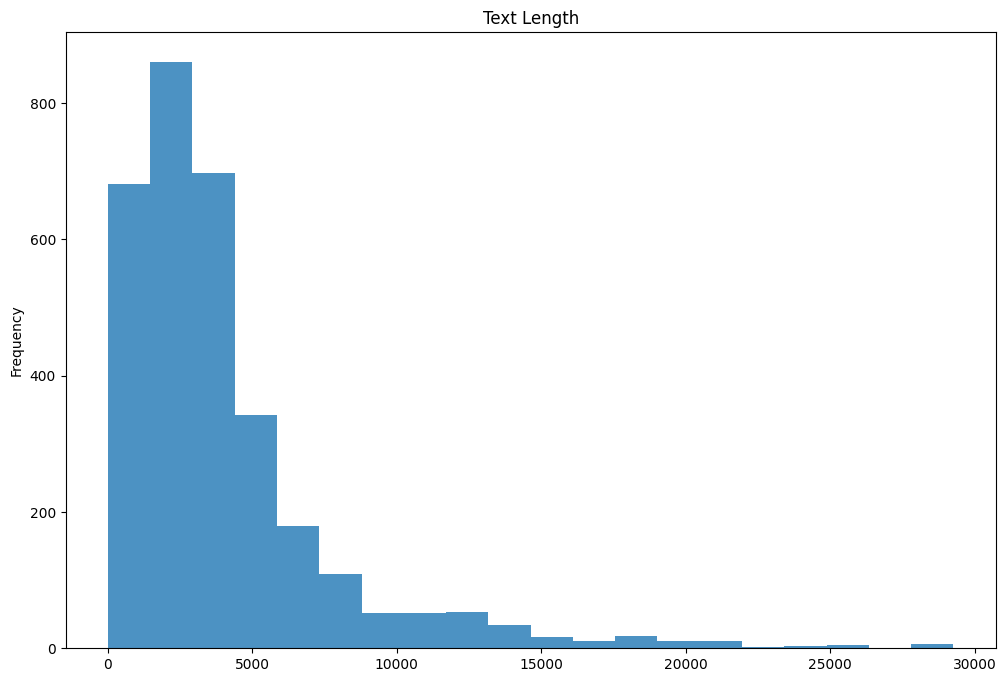

In [39]:
plt.figure(figsize=(12, 8))
ax = dups_s[dups_s['len'] < 30000] ['len'].plot.hist(bins=20, alpha=0.8)
ax.set_title('Text Length')
plt.show()

0.6489088602394992


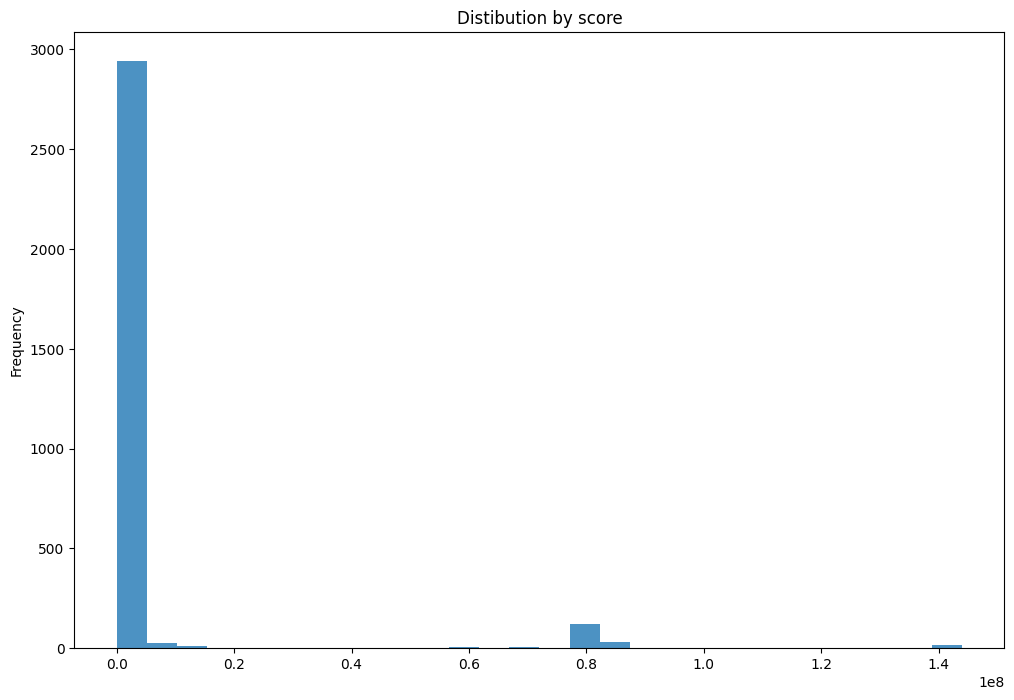

In [40]:
print(dups_s[score_column_name].min())
plt.figure(figsize=(12, 8))
ax = dups_s[score_column_name].plot.hist(bins=28, alpha=0.8)
ax.set_title('Distibution by score')
plt.show()

In [41]:

dups_s['valid'] = True

print("excluding too long docs")
for i, row in dups_s.iterrows():   
    if row['len'] > 30000:
        print ('excluding', i, row[0], row['subject'], row['len'])
        dups_s.at[i, 'valid'] = False  
        
dups_s = dups_s[dups_s['valid'] == True]

print("excluding docs with rare subj")
cnts = dups_s ['subject'].value_counts()
for i, row in dups_s.iterrows():   
    if not pd.isna(row['subject']):
        if cnts[row['subject']] < 3:
            print ('excluding', i, row[0], row['subject'])
            dups_s.at[i, 'valid'] = False

dups_s = dups_s[dups_s['valid'] == True]  

excluding too long docs
excluding 5ec2b8da665f7603e03b126b db GeneralContract 31090.0
excluding 5fbf75c75d05d73d0295fac0 db GeneralContract 38360.0
excluding 5fca2acd9083b679224c77da db GeneralContract 49040.0
excluding 5fca2ac89083b679224c7786 db GeneralContract 43930.0
excluding 5fca2ac79083b679224c774f db GeneralContract 39310.0
excluding 5f9672f182451803b5001df7 db GeneralContract 31170.0
excluding 5e5de70d01c6c73c19eebd4a file GeneralContract 31090.0
excluding 5fc7a047c54bc33809e26372 db Service 49340.0
excluding 5f09a55a138e9184feef1f3d file Service 39860.0
excluding 615e9e978f3b0514f3f42413 db Loans 35800.0
excluding 6246a2d525a983726c76949d db Other 35560.0
excluding 5fb3b9a800881c332b567433 db nan 44180.0
excluding docs with rare subj
excluding 5feb3e50bd24992aa31040df db AssetTransactions
excluding 5fbbbd1ba2b4551c06107a3d db BigDeal
excluding 5dee80604ddc27bcf92dd88e file EmployeeContracts
excluding 6166dbc387f1d9065bb8b937 db AssetTransactions
excluding 610d2b0d7dfce422c427

Service                              1607
Other                                 410
Deal                                  379
Renting                               150
GeneralContract                       145
Loans                                 104
AgencyContract                         79
DealIntellectualProperty               65
Charity                                50
Insurance                              44
RealEstate                             31
RealEstateTransactions                 17
BankGuarantees                         16
ParticipationInOtherOrganizations      12
PledgeEncumbrance                      12
SecuritiesTransactions                  8
Name: subject, dtype: int64


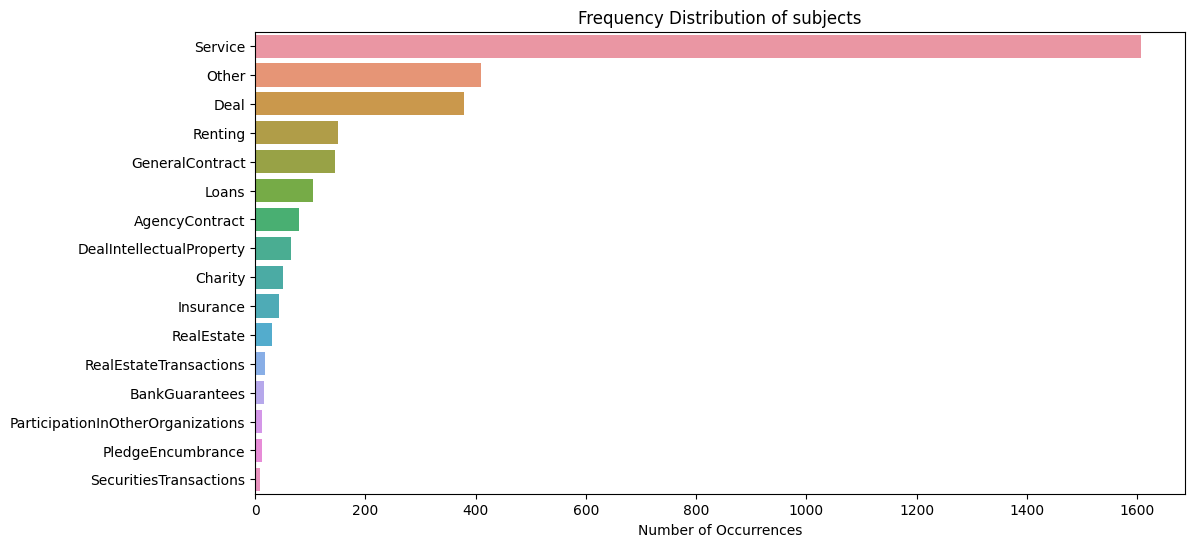

In [42]:
%matplotlib inline

cnt = dups_s['subject'].value_counts()

plt.figure(figsize=(12, 6 ))
sns.barplot(x=cnt.values, y=cnt.index)

print(  cnt )

plt.title('Frequency Distribution of subjects')
plt.xlabel('Number of Occurrences')
plt.show()


In [43]:
dups_s.index.name = '_id'
dups_s.to_csv(Path(work_dir) / 'contract_trainset_meta.csv', index=True)


_s = f"### {len(dups_s)} - Всего новых документов в обучающем наборе на {lastdate}"
display(Markdown(_s))


dups_s

### 3142 - Всего новых документов в обучающем наборе на 2023-02-11 11:15:39.376000+00:00

,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,valid,documentType,subj_len,headers,subject_pos,url,unseen,score,hash,dups
_id,,,,,,,,,,,,,,,,,,,,,
5ec2b8da665f7603e03b1255,db,3187bfac60ea578221c5d9357756c6c1,1.6.5,2023-02-11 23:58:52.944266,5840.0,2020-05-18 17:16:38.114000+00:00,2.523632e+07,17.043795,5674.0,BRL,...,True,CONTRACT,79.0,4.0,1444.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5ec2...,False,6.489089e-01,-2.064230e+18,1.0
5edbc62eda3678279fbcadf3,file,027a7c30f74ff8ffe684378e9883dd8e,2.0.2,2023-02-16 14:43:38.749063,1370.0,2020-07-18 20:24:58.934000+00:00,2.400000e+04,10.085851,747.0,RUB,...,True,CONTRACT,106.0,10.0,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/5edb...,False,6.552332e-01,-2.969771e+18,1.0
5ded4e284ddc27bcf92dd6ce,file,9a44591c17d2b8f34dc8f1c3600c8c3a,1.11.2,2023-02-16 14:43:34.979608,460.0,2020-06-12 21:09:19.574000+00:00,5.900000e+05,13.287880,150.0,RUB,...,True,CONTRACT,30.0,5.0,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/5ded...,False,7.597030e-01,-4.710622e+18,1.0
63ce49f8e83d1ee490f3f21c,db,25d924fc09b7291d964f464f9c3ec8c3,23.1.27.1,2023-02-03 16:19:06.576376,8530.0,2023-01-28 09:34:50.691000+00:00,3.000000e+09,21.821878,337.0,RUB,...,True,CONTRACT,53.0,12.0,100.0,http://gpn-audit.nemosoft.ru/#/audit/edit/63ce...,False,1.153584e+00,-3.456225e+18,1.0
633fd0a69d08c565cfa1232a,db,61cfee32867b371843d1e95a194ea2a6,3.0.0,2023-02-01 17:26:54.225685,5550.0,2022-10-07 10:10:07.028000+00:00,1.000000e+11,25.328436,1505.0,RUB,...,True,CONTRACT,37.0,17.0,395.0,http://gpn-audit.nemosoft.ru/#/audit/edit/633f...,False,1.746836e+00,6.721620e+18,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5fb6750c33c72547b755014e,db,8d9da7ade3a9b3414ef140f8ad5f8723,2.4.4,2023-01-31 18:37:44.285309,190.0,2021-07-28 18:20:01.904000+00:00,NaN,NaN,NaN,NaN,...,True,ANNEX,0.0,2.0,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb6...,True,1.440000e+08,-2.493220e+18,8.0
60890e6294a1f9b4c8a713f8,db,d24bdc8854147a2615eb5a10b70fe612,2.3.14,2023-01-31 18:37:43.576446,170.0,2021-04-28 10:30:03.515000+00:00,NaN,NaN,NaN,NaN,...,True,ANNEX,0.0,5.0,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/6089...,True,1.440000e+08,7.928782e+18,13.0
5fb3d49d78df3635f5441b7d,db,083976745f05598d6cc9e69e214b408d,2.4.4,2023-01-31 18:37:43.855676,180.0,2021-07-23 10:44:49.195000+00:00,NaN,NaN,NaN,NaN,...,True,ANNEX,0.0,2.0,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb3...,True,1.440000e+08,6.385998e+18,4.0


In [44]:
dups_s[dups_s['unseen']].to_csv(Path(work_dir) / 'contract_trainset_meta.to_markup.csv', index=True)

In [45]:
dups_s[dups_s['unseen']]

,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,valid,documentType,subj_len,headers,subject_pos,url,unseen,score,hash,dups
_id,,,,,,,,,,,,,,,,,,,,,
5ec2b8d8665f7603e03b121a,db,74a7be7f14b129ce379aaa0920978a71,1.6.5,2023-01-31 18:32:27.217863,550.0,2020-05-18 16:35:16.047000+00:00,4.900000e+05,13.102163,114.0,RUB,...,True,CONTRACT,35.0,7.0,97.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5ec2...,True,9.722266e+00,8.472476e+18,5.0
63c506c1e2456d59975e1186,db,99eb2f07e9493a1e712529bc30359204,23.2.7,2023-02-14 15:40:13.352394,10780.0,2023-02-07 17:29:02.773000+00:00,6.000000e+06,15.607270,4608.0,RUB,...,True,CONTRACT,35.0,24.0,1656.0,http://gpn-audit.nemosoft.ru/#/audit/edit/63c5...,True,1.558302e+01,-6.899156e+18,1.0
63c506dce2456d59975e145c,db,88a0bf0e851b84960702680c7972f090,23.01.04,2023-01-31 21:42:43.455407,3630.0,2023-01-16 14:15:20.502000+00:00,4.000000e+06,15.201805,326.0,RUB,...,True,CONTRACT,95.0,7.0,157.0,http://gpn-audit.nemosoft.ru/#/audit/edit/63c5...,True,3.112603e+01,-7.515917e+18,2.0
63c506ace2456d59975e0f9f,db,2ff69a29f2a6f16826a6e68dc6cc1d22,23.01.04,2023-01-31 21:42:49.474166,430.0,2023-01-16 14:43:58.035000+00:00,5.500000e+07,17.822844,172.0,RUB,...,True,SUPPLEMENTARY_AGREEMENT,10.0,5.0,136.0,http://gpn-audit.nemosoft.ru/#/audit/edit/63c5...,True,6.803945e+01,-7.373169e+18,1.0
5efe924d777d4b67a92d55b0,file,c056d218b8ae1d56747afd23ac3cf10f,2.0.0,2023-02-16 14:43:47.214066,17580.0,2020-07-03 12:29:32.528000+00:00,1.865870e+08,19.044408,2372.0,RUB,...,True,CONTRACT,11.0,76.0,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/5efe...,True,7.417005e+01,-1.160618e+18,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5fb6750c33c72547b755014e,db,8d9da7ade3a9b3414ef140f8ad5f8723,2.4.4,2023-01-31 18:37:44.285309,190.0,2021-07-28 18:20:01.904000+00:00,NaN,NaN,NaN,NaN,...,True,ANNEX,0.0,2.0,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb6...,True,1.440000e+08,-2.493220e+18,8.0
60890e6294a1f9b4c8a713f8,db,d24bdc8854147a2615eb5a10b70fe612,2.3.14,2023-01-31 18:37:43.576446,170.0,2021-04-28 10:30:03.515000+00:00,NaN,NaN,NaN,NaN,...,True,ANNEX,0.0,5.0,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/6089...,True,1.440000e+08,7.928782e+18,13.0
5fb3d49d78df3635f5441b7d,db,083976745f05598d6cc9e69e214b408d,2.4.4,2023-01-31 18:37:43.855676,180.0,2021-07-23 10:44:49.195000+00:00,NaN,NaN,NaN,NaN,...,True,ANNEX,0.0,2.0,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb3...,True,1.440000e+08,6.385998e+18,4.0


# 🤦 Find markup errors

In [46]:
from pymongo import ASCENDING

query = {
  '$and': [
    {"parse.documentType":{ '$in': ["AGREEMENT", "CONTRACT", "SUPPLEMENTARY_AGREEMENT"] }  },      
    {"user.attributes_tree": {"$ne": None}},
#       {'user.updateDate': {'$gt': lastdate}}    
  ]
}

db = get_mongodb_connection()
documents_collection = db['documents']
sorting = [('analysis.analyze_timestamp', ASCENDING), ('user.updateDate', ASCENDING)]
res = documents_collection.find(filter=query, 
                                sort=sorting,
                                projection={'_id': True, 'user.updateDate':True, 'state':True, 'parse.documentType':True}
#                                             'analysis.attributes_tree.version': True,
#                                             'analysis.attributes_tree.contract.subject': True}
                               ).limit(5000)

res = list([i for i in res])
# print(res[0])
_s = f"#### Всего документов, которые размечены человеком : {len(res)}"
display(Markdown(_s))

# res[:4]



/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)


#### Всего документов, которые размечены человеком : 1157

In [47]:
user_docs_ids  = [i["_id"] for i in res]
print('user_docs_ids', len(user_docs_ids))


user_docs_ids 1157


In [48]:



def get_span_val(jd:DbJsonDoc, tag):
    tm = jd.get_tokens_map_unchaged()
    
    span = tag.get('span', [0,0]) 
    
    if span[1]-span[0]==0:
        return None
    
    quote = tm.text_range(span)
    
    return quote

def add_error(userdocs, _id, error_message):    
            
    if error_message:
        missing=False
        if len(error_message)==2:
            error_message, missing = error_message
        
        userdocs.at[_id,'errors count'] = userdocs.at[_id,'errors count']+1
        
        if missing==True:
            userdocs.at[_id, 'error missing']=';\n'.join(  [error_message, userdocs.at[_id,'error missing']] )
        else:
            userdocs.at[_id, 'error']=';\n'.join(  [error_message, userdocs.at[_id,'error']] )
        
#--------        

def validate_date(jd:DbJsonDoc, df, i=0) -> str or None:
    _id = str(jd._id)
    tag = jd.get_attributes_tree().get('date', {})
    val = get_span_val(jd, tag)
    
    if not val:
        return
#     val = jd.get_tokens_map_unchaged().text_range(span)
    
    df.at[_id,f'Дата'] = val 
       
    
    if '\n' in val:
        return f"Дата содержит перенос строки"
    
    if len(val) > 25:
        return f"Дата слишком длинная"
    
    
def validate_number(jd:DbJsonDoc, df, i=0) -> str or None:
    _id = str(jd._id)
#     span = jd.get_attributes_tree().get('number', {}).get('span', [0,0])
#     val = jd.get_tokens_map_unchaged().text_range(span)
    
    tag = jd.get_attributes_tree().get('number', {})
    span = tag.get('span', [0,0]) 
    val = get_span_val(jd, tag)
    
    if not val:
        return
    
    
    df.at[_id,f'Номер'] = val 
    
    if 'договор' in val.lower():
        return f"Номер содержит слово"
    
    if '\n' in val:
        return f"Номер содержит перенос строки"
       
    if val.strip() !=val:
        return f"Номер содержит пробелы по краям"
    
    if val.strip()=="№":
        return f"Номер не является номером"
    
    if (span[1]-span[0])>5:
        return f"Номер договора какой-то длинный"

#     if val.strip()[0]=="№":
#         return f"Номер содержит знак №"
        
#     if len(val) > 30:
#         return f"Номер слишком длинный"
    
    
def validate_alias(jd:DbJsonDoc, df, i=0) -> str or None:
    _id = str(jd._id)
    orgs=jd.get_attributes_tree().get('orgs', [{},{}])
    
    if len(orgs) < i+1:
        return f"Псевдоним {i+1} отсутсвует", True
    
    tag =  orgs[i].get('alias',{})
    val = get_span_val(jd, tag)
    
    if not val:
        return f"Псевдоним {i+1} отсутсвует", True
    
    
    df.at[_id,f'Псевдоним {i+1}'] = val 
    
    if  '«' in val or '»' in val:
        return f"Псевдоним {i+1} содержит кавычки"
    
    if '\n' in val:
        return f"Псевдоним {i+1} содержит перенос строки"
    
    if len(val) > 25:
        return f"Псевдоним {i+1} слишком длинный"
    
    
def validate_org_name(jd:DbJsonDoc, df, i=0) -> str or None:
    _id = str(jd._id)
    
    orgs=jd.get_attributes_tree().get('orgs', [{},{}])
    
    if len(orgs) < i+1:
        return f"Наименование {i+1} отсутсвует", True
    
    tag = orgs[i].get('name',{})
    val = get_span_val(jd, tag)
    
    if not val:
        return f"Наименование {i+1} отсутсвует", True
    
    df.at[_id,f'Наименование {i+1}'] = val 
    
    if '\n' in val:
        return f"Наименование {i+1} содержит перенос строки"
    
    if '«' in val:
        if '»' not in val:
            return f"Наименование {i+1}: кавычка не закрыта"
    
    if '»' in val:
        if '«' not in val:
            return f"Наименование {i+1}: кавычка не открыта"
        
    if val[0]=='«':
        return f"Наименование {i+1} содержит кавычки"
    
    
def validate_org_type(jd:DbJsonDoc, df, i=0) -> str or None:
    _id = str(jd._id)
    
    orgs=jd.get_attributes_tree().get('orgs', [{},{}])
    
    if len(orgs) < i+1:
        return f"Форма собственности {i+1} отсутсвует", True
    
    tag = orgs[i].get('type',{})
    val = get_span_val(jd, tag)
    
    if not val:
        return f"Форма собственности {i+1} отсутсвует", True
    
    df.at[_id, f'Форма собственности {i+1}'] = val 
    
    if '\n' in val:
        return f"Форма собственности {i+1}: содержит перенос строки"
    
    if '«' in val:
        if '»' not in val:
            return f"Форма собственности {i+1}: кавычка не закрыта"
    
    if '»' in val:
        if '«' not in val:
            return f"Форма собственности {i+1}: кавычка не открыта"
        
    if val[0]=='«':
        return f"Форма собственности {i+1}: содержит кавычки"
    

def validate_subject_len(jd:DbJsonDoc, df) -> str or None: 
    _id = str(jd._id)
    
    tag = jd.get_attributes_tree().get('subject', {})
    val = get_span_val(jd, tag)
    span = tag.get('span', [0,0]) 
    
    kind = tag.get('value', None) 
    
    
    subject_len = span[1]-span[0]
    
    df.at[_id,'subject len'] = subject_len
    df.at[_id,'subject kind'] = kind
    
    if subject_len > 150:
        df.at[_id,'subject'] = val[:200]
        return f"предмет договора слишком длинный: {subject_len} слов"
    
    if subject_len ==0:
        return f"раздел о предмете договора не указан; определен как [{kind}]"
    
    
def validate_price(jd:DbJsonDoc, df) -> str or None:    
    _id = str(jd._id)
    
    tag = jd.get_attributes_tree().get('price', {})
    
    
    span = tag.get('span', [0,0]) 
        
    _len = span[1]-span[0]
    
#     df.at[_id,'subject len'] = subject_len

    
    
    if not tag:
        return 
    
    price_q = get_span_val(jd, tag)
    df.at[_id,'сумма'] = f"{price_q}"
    
    
    sentence_span1 = jd.get_tokens_map_unchaged().sentence_at_index( span[0])
    sentence_span2 = jd.get_tokens_map_unchaged().sentence_at_index( span[1])
    sentence_span = [ sentence_span1[0], sentence_span2[1]]
    
    
    sentence = jd.get_tokens_map_unchaged().text_range(sentence_span)
    
    amount_name = 'сумма (старая)'
    price_name = 'сумма договора'
    
    
    vat = tag.get('vat')    
    if vat:
        val = get_span_val(jd, vat)    
        df.at[_id, 'налог'] = f'{val}'
        
    vat_unit = tag.get('vat_unit')    
    if vat_unit:
        val = get_span_val(jd, vat_unit)    
        df.at[_id,'vat_unit'] = f'{val}'
        

        
    
    amount_netto = tag.get('amount_netto')    
    if amount_netto:
        val = get_span_val(jd, amount_netto)    
        df.at[_id,'сумма без налога'] = f'{val}'
        
    amount = tag.get('amount')  
    
    if amount:
        val = get_span_val(jd, amount)    
        df.at[_id, amount_name] = f'{val}'
     
        
    amount_brutto = tag.get('amount_brutto')    
    if amount_brutto:
        val = get_span_val(jd, amount_brutto)    
        df.at[_id,'сумма с налогом'] = f'{val}'
        
    currency = tag.get('currency')    
    if currency:
        val = get_span_val(jd, currency)    
        df.at[_id,'currency'] = f'{val}'
        
    
    if vat:
        val = get_span_val(jd, vat)    
        if not val[0].isdigit():
            return  f"налог начинается не с цифры"
     
    #----
    if amount_netto:
        _span = amount_netto.get('span', [0,0])         
        if _span[1]-_span[0] > 4:
            return  f"сумма без налога слишком длинная, должна содержать только число"
    
    #----
    if amount_brutto:
        _span = amount_brutto.get('span', [0,0])         
        if _span[1]-_span[0] > 4:
            return  f"сумма c налогом слишком длинная, должна содержать только число"
        
    #----
    if amount:
        _span = amount.get('span', [0,0])         
        if _span[1]-_span[0] > 4:
            return  f"{amount_name} слишком длинная, должна содержать только число"
    
    
    if amount_netto or amount_brutto:
        if not vat:
            return  f"налог не указан"
    

    if ' штраф ' in sentence.lower() or "страховая сумма " in sentence.lower() or " пени " in sentence.lower() : 
        print('sentence_span', sentence_span, jd.get_tokens_map_unchaged().text_range(sentence_span))
        return  f"сумма вообще не та!!"
        
    if 'ндс' in sentence.lower():
        if not vat:
            return  f"налог не указан"
        
        if not (amount_netto or  amount_brutto):
            return  f"сумма с учетом налога не указана"
        
    if amount_netto or amount_brutto or amount:
        if not currency:
            return  f"валюта не указана"
        
    if vat:
        if not vat_unit:
            return  f"валюта налога не указана"
    
    if tag:
        if not (price_q.strip()[0].isalpha() or price_q.strip()[0].isdigit):
            return  f"раздел о цене начинается не со слова"
        
    if _len > 150:
        return f"{price_name} слишком длинная: {_len} слов"
    
    if _len < 10:
        return f"{price_name} слишком короткая: {_len} слов, нужно: {sentence_span1[1]- sentence_span2[0]}"

####################################### sentence_at_index

def validate_markup(user_docs_ids) -> DataFrame:
  userdocs = DataFrame()
  for k, oid in enumerate(user_docs_ids):
# for k, oid in enumerate(['5fe34f64b770574a005553e6']):    
    _id = str(oid)
    oid = ObjectId(_id)
    d = get_doc_by_id(oid)
    jd = DbJsonDoc(d)
        
    attr_tree = jd.get_attributes_tree()  
#     print('',attr_tree)

    
    userdocs.at[_id,'дата редактирования'] = jd.user['updateDate']
    userdocs.at[_id,'link'] = f'https://gpn-audit.nemosoft.ru/#/audit/edit/{_id}'
    userdocs.at[_id,'error'] = ''
    userdocs.at[_id,'error missing'] = ''
    userdocs.at[_id,'errors count'] = 0

    
    
    if not jd.analysis:
        userdocs.at[_id, 'error'] = "Не анализирован!!"
    
    else:
        add_error(userdocs, _id, validate_subject_len(jd, userdocs) )
        

        add_error(userdocs, _id, validate_org_type(jd, userdocs, 0) )
        add_error(userdocs, _id, validate_org_name(jd, userdocs, 0) )
        add_error(userdocs, _id, validate_alias(jd, userdocs, 0) )
        
        add_error(userdocs, _id, validate_org_type(jd, userdocs, 1) )
        add_error(userdocs, _id, validate_org_name(jd, userdocs, 1) )
        add_error(userdocs, _id, validate_alias(jd, userdocs, 1) )

        add_error(userdocs, _id, validate_date(jd, userdocs) )
        add_error(userdocs, _id, validate_number(jd, userdocs) )
        
        add_error(userdocs, _id, validate_price(jd, userdocs) )
        
  return userdocs
    
userdocs = validate_markup(user_docs_ids)
userdocs=userdocs.sort_values(["errors count"], ascending=False)
userdocs.to_csv(reports_path / "errors.csv", index=True)   

_s = f"#### Всего ошибок: {userdocs['errors count'].sum()} в {len(userdocs)} документах -- ({userdocs['errors count'].sum()/len(userdocs)} на документ)"
display(Markdown(_s))

userdocs

sentence_span [10328, 10403] 1.11 .Поставщик может уступить право требования по настоящему Договору лишь после получения письменного согласия Покупателя. Письменное согласие Покупателя оформляется путем подписания со стороны Покупателя Уведомления об уступке прав требования. В случае оформления уступки права требования по настоящему Договору Поставщик без наличия письменного согласия Покупателя, последний вправе не согласиться с совершенной уступкой и взыскать с Поставщика штраф в размере 100000 (сто тысяч) рублей за каждый случай уступки права требования.

sentence_span [780, 803] 3.2. Общая страховая сумма по настоящему Договору составляет 296250000 (Двести девяносто шесть миллионов двести пятьдесят тысяч) рублей 00 копеек

sentence_span [780, 803] 3.2. Общая страховая сумма по настоящему Договору составляет 296250000 (Двести девяносто шесть миллионов двести пятьдесят тысяч) рублей 00 копеек



#### Всего ошибок: 1245.0 в 1157 документах -- (1.0760587726879862 на документ)

,дата редактирования,link,error,error missing,errors count,subject len,subject kind,Форма собственности 1,Наименование 1,Псевдоним 1,...,Дата,сумма,сумма (старая),currency,Номер,сумма без налога,налог,vat_unit,сумма с налогом,subject
63ce4a56e83d1ee490f3f790,2023-02-12 09:08:11.045,https://gpn-audit.nemosoft.ru/#/audit/edit/63c...,раздел о предмете договора не указан; определе...,Псевдоним 2 отсутсвует;\nНаименование 2 отсутс...,7.0,0.0,None,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6152e3af8558145da68d8790,2023-02-15 16:29:51.796,https://gpn-audit.nemosoft.ru/#/audit/edit/615...,налог не указан;\n,Наименование 2 отсутсвует;\nФорма собственност...,5.0,56.0,Service,NaN,NaN,Заказчик,...,NaN,"Общая стоимость услуг по Договору составляет, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
615ac8cf8f3b0514f3f423f8,2021-10-04 09:30:37.752,https://gpn-audit.nemosoft.ru/#/audit/edit/615...,Номер не является номером;\n,Псевдоним 2 отсутсвует;\nПсевдоним 1 отсутсвуе...,5.0,37.0,Service,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,№,NaN,NaN,NaN,NaN,NaN
638085a16a07f3e980b2c5f0,2022-11-28 14:12:32.757,https://gpn-audit.nemosoft.ru/#/audit/edit/638...,налог не указан;\nНомер не является номером;\n,Наименование 2 отсутсвует;\nФорма собственност...,4.0,81.0,Service,Общество с ограниченной ответственностью,ГПН-Аэро,Заказчик,...,«25» октября 2021,5.6 Общая стоимость настоящего договора в теч...,NaN,рублей,№,500,NaN,NaN,NaN,NaN
5fb3d7a978df3635f5441ebb,2021-10-27 17:31:00.594,https://gpn-audit.nemosoft.ru/#/audit/edit/5fb...,налог не указан;\nНомер не является номером;\n...,,4.0,0.0,None,Общество с ограниченной ответственностью,Газпромнефть-Развитие,Заказчик,...,NaN,Стоимость Услуг по настоящему Договору составл...,NaN,рублей,№,309690,NaN,NaN,371628,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
638085576a07f3e980b2bfea,2022-11-30 09:24:49.292,https://gpn-audit.nemosoft.ru/#/audit/edit/638...,,,0.0,43.0,Deal,Общество с ограниченной ответственностью,Ромашка,Покупатель,...,«16» октября 2017,NaN,NaN,NaN,№ _______,NaN,NaN,NaN,NaN,NaN
5fca2aae9083b679224c760f,2020-12-10 08:38:46.848,https://gpn-audit.nemosoft.ru/#/audit/edit/5fc...,,,0.0,41.0,Deal,Общество с ограниченной ответственностью,Газпромнефть-Оренбург,Продавец,...,17 апреля 2019,NaN,NaN,NaN,№ ГНЗ -19/01000/00129/Р-05,NaN,NaN,NaN,NaN,NaN
5fca2aaf9083b679224c7620,2020-12-10 08:50:36.955,https://gpn-audit.nemosoft.ru/#/audit/edit/5fc...,,,0.0,41.0,Deal,Общество с ограниченной ответственностью,Газпромнефть-Оренбург,Продавец,...,"""17"" октября 2019 год.",NaN,NaN,NaN,№ Д_39295_73273_38441,NaN,NaN,NaN,NaN,NaN
63761b05a4c19fe482375449,2023-02-16 11:33:48.974,https://gpn-audit.nemosoft.ru/#/audit/edit/637...,,,0.0,78.0,GeneralContract,Акционерное общество,Газпромнефть-Омский НПЗ,Заказчик,...,«01» 022021 год.,Стоимость выполняемых Подрядчиком Работ по Дог...,NaN,рублей,123456,"97214759,20","19442951,84",рубль,NaN,NaN


In [49]:
yseterday_userdocs = validate_markup(yseterday_ids)
yseterday_userdocs.to_csv(reports_path/"yesterday_errors.csv", index=True)   

yseterday_userdocs

/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)


,дата редактирования,link,error,error missing,errors count,subject len,subject kind,Форма собственности 1,Наименование 1,Псевдоним 1,...,Псевдоним 2,Дата,Номер,сумма,сумма с налогом,currency,сумма (старая),налог,сумма без налога,vat_unit
5ec2b8d9665f7603e03b1238,2023-02-15 16:44:29.749,https://gpn-audit.nemosoft.ru/#/audit/edit/5ec...,налог не указан;\n,,1.0,60.0,PledgeEncumbrance,Общество с ограниченной ответственностью,Газпромнефть-Региональные продажи,Залогодатель,...,Залогодержатель,«01» апреля 2015,15489/3П,Общий размер обеспечиваемого Предметом залога ...,60000000,рублей,NaN,NaN,NaN,NaN
5fb3d4a078df3635f5441c6d,2023-02-16 07:03:44.725,https://gpn-audit.nemosoft.ru/#/audit/edit/5fb...,,,0.0,20.0,Insurance,Общество с гветственностью,Рекламно-Информационное агентство «Город»,Страхователь,...,Страховщик,"30"" декабря 2019 год.",2920 LA 0222,страховая премия по настоящему Договору состав...,NaN,рублей,3193,NaN,NaN,NaN
5fb3d79e78df3635f5441d1e,2023-02-16 11:26:25.256,https://gpn-audit.nemosoft.ru/#/audit/edit/5fb...,налог начинается не с цифры;\n,Форма собственности 2 отсутсвует;\n,2.0,58.0,GeneralContract,Общество с ограниченной ответе венностью,Издательско-полиграфическое предприятие «Масте...,Заказчик,...,Подрядчик,27 ноября 2019,№ 19-45Р,"Стоимость работ составляет 99500, '0 рублей (д...",NaN,рублей,NaN,НДС не уплачивается,99500,NaN
5fe48220b770574a0055578f,2023-02-16 11:38:37.970,https://gpn-audit.nemosoft.ru/#/audit/edit/5fe...,,,0.0,28.0,Deal,Общество с ограниченной ответственностью,Издательское-полиграфическое предприятие «Маст...,Поставщик,...,Покупатель,«15» мая 2020,№ 20-РЗг 25У,3.1. Общая сумма по Договору складывается из с...,1352832,рубля,NaN,225472,NaN,рубля
5fe4821ab770574a00555656,2023-02-16 11:15:39.376,https://gpn-audit.nemosoft.ru/#/audit/edit/5fe...,Наименование 2: кавычка не закрыта;\nНаименова...,,2.0,18.0,GeneralContract,ООО,ИПП «Мастерская Печати,Заказчик,...,Исполнитель,«27» ноября 2019,№ 8-ТЭ,4.1. Общая стоимость договора составляет 25600...,256000,рублей,NaN,42666,NaN,рублей
5fe4821eb770574a005556fd,2023-02-16 11:42:53.906,https://gpn-audit.nemosoft.ru/#/audit/edit/5fe...,,,0.0,34.0,Service,ООО,ИПП «Мастерская печати»,Заказчик,...,Исполнитель,«05» декабря 2019,№ 93607/12-19,3.1. Стоимость изготовления и поставки Продукц...,73987,рублей,NaN,20,NaN,%
5fe4821eb770574a0055570f,2023-02-16 07:00:13.991,https://gpn-audit.nemosoft.ru/#/audit/edit/5fe...,,,0.0,75.0,Service,Общество с ограниченной ответственностью,Издательско-полиграфическое предприятие «Масте...,Исполнитель,...,Заказчик,«01» февраля 2020,06/09-2020,3.1. Общая стоимость Услуг по настоящему Догов...,"70000,00",рублей,NaN,20,NaN,%
5fe48220b770574a00555782,2023-02-16 11:40:35.851,https://gpn-audit.nemosoft.ru/#/audit/edit/5fe...,,,0.0,74.0,Service,Общество с ограниченной ответственностью,Издательскополиграфическое предприятие «Мастер...,Исполнитель,...,Заказчик,«19» февраля 2020,№ 12/09-2020,3.1. Стоимость услуг по настоящему договору со...,1824300,рублей,NaN,304050,1520250,рублей
5feb3e50bd24992aa3104103,2023-02-16 11:31:15.661,https://gpn-audit.nemosoft.ru/#/audit/edit/5fe...,,,0.0,29.0,Renting,Общество с ограниченной ответственностью,Газпромнефть-Снабжение,Арендатор,...,Арендодатель,30-05-2017,н-1/2017-Ю,Общая сумма арендной платы по настоящему Догов...,942849,рублей,NaN,20,785707,%
60002adfb08473039387bcb0,2023-02-16 11:32:00.212,https://gpn-audit.nemosoft.ru/#/audit/edit/600...,налог не указан;\n,,1.0,62.0,GeneralContract,Общество с ограниченной ответственностью,Газпромнефть-Снабжение,Заказчик,...,Подрядчик,27 ноября 2017,№ 958-985-658-7,"Стоимость работ составляет 99500,0 рублей (дев...",NaN,рублей,NaN,NaN,"99500,0",NaN


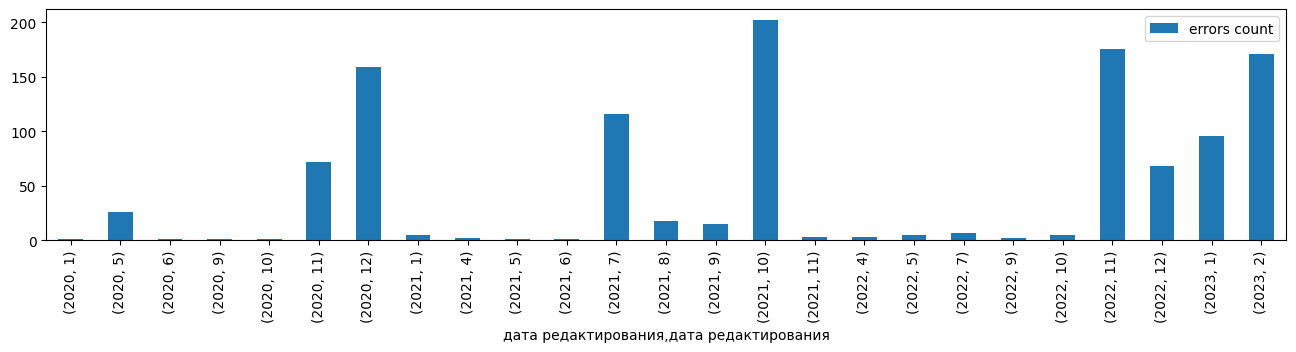

In [50]:
# userdocs.groupby(userdocs["дата редактирования"].dt.year, userdocs["дата редактирования"].dt.month) [['errors count','дата редактирования']] .count().plot(kind="bar")
import matplotlib.pyplot as plt


ax = userdocs.groupby(
    [userdocs["дата редактирования"].dt.year, userdocs["дата редактирования"].dt.month ])[
        ['errors count']].count().plot(kind="bar", figsize=(16,3))

plt.show()

In [51]:
userdocsBak = userdocs.copy()

In [52]:
from collections import Counter


l = list(userdocs['vat_unit'].values) + list( userdocs['currency'].values)
l= [str(k).lower() for k in l]
c = Counter(l)
rare_currency=[]
for k in c:
    if c[k] < 2:
        rare_currency.append(k)
        

l = list(userdocs['Псевдоним 1'].values) + list( userdocs['Псевдоним 2'].values)
l= [str(k).lower() for k in l]
c = Counter(l)
rare_aliases=[]
for k in c:
    if c[k] < 2:
        rare_aliases.append(k)
# rare_aliases


l = list(userdocs['Форма собственности 1'].values) + list( userdocs['Форма собственности 2'].values)
l= [str(k).lower() for k in l]
c = Counter(l)
rare_forms=[]
for k in c:
    if c[k] < 2:
        rare_forms.append(k)
# print(rare_forms)        
        
    
    
for i, row in userdocs.iterrows():
    fs1 = str(row['Форма собственности 1']).lower()
    fs2 = str(row['Форма собственности 2']).lower()
    
    as1 = str(row['Псевдоним 1']).lower()
    as2 = str(row['Псевдоним 2']).lower()
    
    
    cs1 = str(row['vat_unit']).lower()
    if cs1 in rare_currency:
        print(i, f'[{cs1}]')
        add_error(userdocs, i, "Валюта налога очень странная" )
        
    cs2 = str(row['currency']).lower()
    if cs2 in rare_currency:
        print(i, f'[{cs2}]')
        add_error(userdocs, i, "Валюта очень странная" )
    
    if fs1 in rare_forms:
        print(i, f'[{fs1}]')
        add_error(userdocs, i, "Форма собственности 1 очень странная" )
    if fs2 in rare_forms:
        print(i, f'[{fs2}]')
        add_error(userdocs, i, "Форма собственности 2 очень странная" )
        
    if as1 in rare_aliases:
        print(i, f'[{as1}]')
        add_error(userdocs, i, "Псевдоним 1 очень странный" )
    if as2 in rare_aliases:
        print(i, f'[{as2}]')
        add_error(userdocs, i, "Псевдоним 2 очень странный" )
        
userdocs

6152e3798558145da68d8788 [актуарий]
612de89f4f22ff1b7e02fcd7 [eur]
6380855c6a07f3e980b2c061 [ромашка]
5fb3d4a078df3635f5441c32 [муниципальное автономное учреждение культуры]
5fe4821ab770574a00555657 [общественная организация «спортивная общественная организация]
62874fcd4d1bfe5e5b297df0 [ндс]
638085706a07f3e980b2c1ed [акционерное общество (ао )]
5fca2aab9083b679224c75e7 [газпромнефть-оренбург]
6380858a6a07f3e980b2c4aa [исполнитель или подрядчик]
62d149484ae369b4976e31ff [долларов сша]
5fe48218b770574a005555c6 [муниципальное унитарное предприятие]
5fe4821eb770574a00555708 [общественная организация]
5fdb2143542ce403c92b45a1 [зарегистрированный кандидат в депутаты]
63a40a76327b0fecf75ecb40 [
 публичное акционерное общество]
5fbbe46da2b4551c06107c68 [теплоснабжающая организация]
5fbbbd1da2b4551c06107a7d [акционерное общество (]
638085826a07f3e980b2c3b8 [общество с ограниченной отвественностью]
5fb3d79e78df3635f5441d1e [общество с ограниченной ответе венностью]
63ac1fac862ea92bf713c534 [фед

,дата редактирования,link,error,error missing,errors count,subject len,subject kind,Форма собственности 1,Наименование 1,Псевдоним 1,...,Дата,сумма,сумма (старая),currency,Номер,сумма без налога,налог,vat_unit,сумма с налогом,subject
63ce4a56e83d1ee490f3f790,2023-02-12 09:08:11.045,https://gpn-audit.nemosoft.ru/#/audit/edit/63c...,раздел о предмете договора не указан; определе...,Псевдоним 2 отсутсвует;\nНаименование 2 отсутс...,7.0,0.0,None,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6152e3af8558145da68d8790,2023-02-15 16:29:51.796,https://gpn-audit.nemosoft.ru/#/audit/edit/615...,налог не указан;\n,Наименование 2 отсутсвует;\nФорма собственност...,5.0,56.0,Service,NaN,NaN,Заказчик,...,NaN,"Общая стоимость услуг по Договору составляет, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
615ac8cf8f3b0514f3f423f8,2021-10-04 09:30:37.752,https://gpn-audit.nemosoft.ru/#/audit/edit/615...,Номер не является номером;\n,Псевдоним 2 отсутсвует;\nПсевдоним 1 отсутсвуе...,5.0,37.0,Service,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,№,NaN,NaN,NaN,NaN,NaN
638085a16a07f3e980b2c5f0,2022-11-28 14:12:32.757,https://gpn-audit.nemosoft.ru/#/audit/edit/638...,налог не указан;\nНомер не является номером;\n,Наименование 2 отсутсвует;\nФорма собственност...,4.0,81.0,Service,Общество с ограниченной ответственностью,ГПН-Аэро,Заказчик,...,«25» октября 2021,5.6 Общая стоимость настоящего договора в теч...,NaN,рублей,№,500,NaN,NaN,NaN,NaN
5fb3d7a978df3635f5441ebb,2021-10-27 17:31:00.594,https://gpn-audit.nemosoft.ru/#/audit/edit/5fb...,налог не указан;\nНомер не является номером;\n...,,4.0,0.0,None,Общество с ограниченной ответственностью,Газпромнефть-Развитие,Заказчик,...,NaN,Стоимость Услуг по настоящему Договору составл...,NaN,рублей,№,309690,NaN,NaN,371628,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
638085576a07f3e980b2bfea,2022-11-30 09:24:49.292,https://gpn-audit.nemosoft.ru/#/audit/edit/638...,,,0.0,43.0,Deal,Общество с ограниченной ответственностью,Ромашка,Покупатель,...,«16» октября 2017,NaN,NaN,NaN,№ _______,NaN,NaN,NaN,NaN,NaN
5fca2aae9083b679224c760f,2020-12-10 08:38:46.848,https://gpn-audit.nemosoft.ru/#/audit/edit/5fc...,,,0.0,41.0,Deal,Общество с ограниченной ответственностью,Газпромнефть-Оренбург,Продавец,...,17 апреля 2019,NaN,NaN,NaN,№ ГНЗ -19/01000/00129/Р-05,NaN,NaN,NaN,NaN,NaN
5fca2aaf9083b679224c7620,2020-12-10 08:50:36.955,https://gpn-audit.nemosoft.ru/#/audit/edit/5fc...,,,0.0,41.0,Deal,Общество с ограниченной ответственностью,Газпромнефть-Оренбург,Продавец,...,"""17"" октября 2019 год.",NaN,NaN,NaN,№ Д_39295_73273_38441,NaN,NaN,NaN,NaN,NaN
63761b05a4c19fe482375449,2023-02-16 11:33:48.974,https://gpn-audit.nemosoft.ru/#/audit/edit/637...,,,0.0,78.0,GeneralContract,Акционерное общество,Газпромнефть-Омский НПЗ,Заказчик,...,«01» 022021 год.,Стоимость выполняемых Подрядчиком Работ по Дог...,NaN,рублей,123456,"97214759,20","19442951,84",рубль,NaN,NaN


In [53]:

userdocs=userdocs.sort_values(["errors count"], ascending=False)
userdocs.to_csv(reports_path / "errors.csv", index=True)     
# userdocs



In [54]:
userdocs_subj = userdocs[ ['subject kind', 'Псевдоним 1', 'Псевдоним 2']]
# userdocs_subj

def get_alias_pair(v):
    return ' -vs- '.join(   np.sort( list([ str(v['Псевдоним 1']).lower(), str(v['Псевдоним 2']).lower()])) ) 


 
c=Counter([get_alias_pair(v) for i, v in userdocs_subj.iterrows()])
rare_aliases_pairs=[k for k in c if c[k] < 2]
for i, row in userdocs.iterrows():
    d=get_alias_pair(row)
    if d in rare_aliases_pairs:
        print(i, f'[{d}]')
        userdocs.at[i, 'strange alias combo'] =f"Необычная пара псевдонимов: {d}"
        
print('-'*20)
del rare_aliases_pairs
# # rare_aliases_pairs
        
# del d
    
def get_alias_subject_pair(v, i):
    return ' / '.join(    list([ str(v[f'Псевдоним {i}']).lower(), str(v['subject kind']).lower()])) 
    
p1 = [get_alias_subject_pair(v, 1) for i, v in userdocs_subj.iterrows()]


c=Counter(p1+[get_alias_subject_pair(v, 2) for i, v in userdocs_subj.iterrows()])
rare_alias_subj_pairs=[k for k in c if c[k] < 3]

for i, row in userdocs.iterrows():
    d1 = get_alias_subject_pair(row, 1)
    d2 = get_alias_subject_pair(row, 2)
    
    if d1 in rare_alias_subj_pairs:
        print(i, f'[{d1}]')
        userdocs.at[i, 'strange alias-subject'] =f"Необычная пара псевдоним-предмет: {d1}"
    
    if d2 in rare_alias_subj_pairs :
        print(i, f'[{d2}]')
        userdocs.at[i, 'strange alias-subject'] =f"Необычная пара псевдоним-предмет: {d2}"
        
print('-'*20)        
rare_alias_subj_pairs


6152e3798558145da68d8788 [актуарий -vs- клиент]
612de89f4f22ff1b7e02fcd7 [nan -vs- покупатель]
5fca2ab09083b679224c7638 [заказии -vs- исполнитель]
5ec2b8da665f7603e03b1255 [sun -vs- гпн]
6380855c6a07f3e980b2c061 [клуб -vs- ромашка]
6294ae67df54d406a99b1631 [водопользователь -vs- уполномоченный орган]
62c54895e599c73b751b7974 [nan -vs- клуб]
63ce49f8e83d1ee490f3f21c [банк -vs- приказодатель]
635fa420bf4cb23cbb39282f [жертвователь -vs- жертвополучатель]
63c506c9e2456d59975e1277 [газпромнефть - 123 -vs- правительство]
6380858a6a07f3e980b2c4aa [заказчик -vs- исполнитель или подрядчик]
5fbbe46da2b4551c06107c68 [потребитель -vs- теплоснабжающая организация]
638085766a07f3e980b2c280 [клиент -vs- перевозчик]
6380855b6a07f3e980b2c042 [благотворитель -vs- получатель]
63908ca4a1bded13e629f2ea [nan -vs- гарант]
5fdb2146542ce403c92b4612 [банк -vs- предприятие]
635fa420bf4cb23cbb39282d [жертвователь -vs- жертвонол уча гель]
62bdad696e75fae95cce25eb [заявитель -vs- сетевой]
5fe4821ab770574a00555625 [

['заказии / service',
 'гпн / service',
 'ромашка / deal',
 'водопользователь / none',
 'nan / deal',
 'газпромнефть - 123 / deal',
 'энергоснабжающая организация / service',
 'потребитель / deal',
 'страхователь / none',
 'nan / agencycontract',
 'ссудополучатель / renting',
 'предприятие / service',
 'заявитель / service',
 'спонсор / charity',
 'сторона 2 / service',
 'подрядчик / deal',
 'арендодатель / none',
 'абонент / deal',
 'клиент^ / service',
 'подписчик / service',
 'плательщик / charity',
 'экспедитор / service',
 'таможенный представитель / service',
 'правообладатель / deal',
 'сторона-2 / service',
 'арендатор / none',
 'потребитель / service',
 'покупатель / assettransactions',
 'владелец / принципал / agencycontract',
 'клиент / bankguarantees',
 'пользователь / dealintellectualproperty',
 'организатор / service',
 'заявитель / bankguarantees',
 'общество / assettransactions',
 'сторона-1 / dealintellectualproperty',
 'актуарий / service',
 'sun / service',
 'клуб / 

In [55]:
_s = f"#### {datetime.today().strftime('%d.%m.%Y')} *Всего* ошибок, недочетов и проч.: {userdocs['errors count'].sum()} в {len(userdocs)} документах -- ({userdocs['errors count'].sum()/len(userdocs):0.2f} на документ)"
display(Markdown(_s))

#### 16.02.2023 *Всего* ошибок, недочетов и проч.: 1353.0 в 1157 документах -- (1.17 на документ)

In [56]:
userdocs_subj = userdocs[ ['link','subject kind', 'Псевдоним 1', 'Псевдоним 2', 'strange alias combo', 'strange alias-subject' ]]

errors_subjects = userdocs_subj[userdocs_subj['strange alias combo'].notnull() | userdocs_subj['strange alias-subject'].notnull() ]
errors_subjects.to_csv(reports_path / "errors_subjects.csv", index=True)         
errors_subjects

,link,subject kind,Псевдоним 1,Псевдоним 2,strange alias combo,strange alias-subject
6152e3798558145da68d8788,https://gpn-audit.nemosoft.ru/#/audit/edit/615...,Service,Клиент,Актуарий,Необычная пара псевдонимов: актуарий -vs- клиент,Необычная пара псевдоним-предмет: актуарий / s...
612de89f4f22ff1b7e02fcd7,https://gpn-audit.nemosoft.ru/#/audit/edit/612...,Deal,ПОКУПАТЕЛЬ,NaN,Необычная пара псевдонимов: nan -vs- покупатель,Необычная пара псевдоним-предмет: nan / deal
5fca2ab09083b679224c7638,https://gpn-audit.nemosoft.ru/#/audit/edit/5fc...,Service,Заказии,Исполнитель,Необычная пара псевдонимов: заказии -vs- испол...,Необычная пара псевдоним-предмет: заказии / se...
5ec2b8da665f7603e03b1255,https://gpn-audit.nemosoft.ru/#/audit/edit/5ec...,Service,ГПН,SUN,Необычная пара псевдонимов: sun -vs- гпн,Необычная пара псевдоним-предмет: sun / service
6380855c6a07f3e980b2c061,https://gpn-audit.nemosoft.ru/#/audit/edit/638...,Deal,Ромашка,Клуб,Необычная пара псевдонимов: клуб -vs- ромашка,Необычная пара псевдоним-предмет: клуб / deal
...,...,...,...,...,...,...
6166dbc387f1d9065bb8b937,https://gpn-audit.nemosoft.ru/#/audit/edit/616...,AssetTransactions,ОБЩЕСТВО,ПРИОБРЕТАТЕЛЬ,Необычная пара псевдонимов: общество -vs- прио...,Необычная пара псевдоним-предмет: приобретател...
615e9eed8f3b0514f3f42424,https://gpn-audit.nemosoft.ru/#/audit/edit/615...,Loans,Заемщик,Банк,Необычная пара псевдонимов: банк -vs- заемщик,NaN
638085746a07f3e980b2c25b,https://gpn-audit.nemosoft.ru/#/audit/edit/638...,Service,Общество,Завод,NaN,Необычная пара псевдоним-предмет: завод / service
5fdb2145542ce403c92b45fc,https://gpn-audit.nemosoft.ru/#/audit/edit/5fd...,Service,Клиент,Исполнитель,Необычная пара псевдонимов: исполнитель -vs- к...,NaN


In [57]:
userdocs[userdocs['errors count']<2]

,дата редактирования,link,error,error missing,errors count,subject len,subject kind,Форма собственности 1,Наименование 1,Псевдоним 1,...,сумма (старая),currency,Номер,сумма без налога,налог,vat_unit,сумма с налогом,subject,strange alias combo,strange alias-subject
5fb674fa33c72547b754ff92,2021-10-26 18:59:31.445,https://gpn-audit.nemosoft.ru/#/audit/edit/5fb...,Наименование 2: кавычка не закрыта;\n,,1.0,47.0,Renting,Акционерное общество,Арктика Медиа,Арендодатель,...,NaN,NaN,№ 19-10Д,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5fdb2145542ce403c92b45f6,2020-12-18 09:45:09.402,https://gpn-audit.nemosoft.ru/#/audit/edit/5fd...,Наименование 1: кавычка не закрыта;\n,,1.0,58.0,Service,Общество с ограниченной ответственностью,Рекламно-Информационное агентство «Город,Исполнитель,...,NaN,NaN,№ 19-37,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5fbbe467a2b4551c06107afc,2021-10-28 14:05:25.683,https://gpn-audit.nemosoft.ru/#/audit/edit/5fb...,валюта налога не указана;\n,,1.0,55.0,Renting,Акционерное общество,Арктика Медиа,Арендодатель,...,NaN,рублей,№ 19-29Д,NaN,"1080,00",NaN,"6480,00",NaN,NaN,NaN
5fca2aab9083b679224c75ea,2023-02-02 10:27:04.555,https://gpn-audit.nemosoft.ru/#/audit/edit/5fc...,налог не указан;\n,,1.0,102.0,Loans,Общество с ограниченной ответственностью,Газпромнефть-Оренбург,Заемщик,...,NaN,рублей,№ 19 ТоНОС іIp,1000000000,NaN,NaN,NaN,NaN,NaN,NaN
5fdb2140542ce403c92b454a,2020-12-18 13:01:50.508,https://gpn-audit.nemosoft.ru/#/audit/edit/5fd...,Наименование 1: кавычка не закрыта;\n,,1.0,60.0,Service,Общество с ограниченной ответственностью,Рекламно-Информационное агентство «Город,Исполнитель,...,NaN,NaN,№ 19-01Д,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5fdb2142542ce403c92b4599,2020-12-18 09:02:37.165,https://gpn-audit.nemosoft.ru/#/audit/edit/5fd...,,,0.0,61.0,Service,Общество с ограниченной ответственностью,РИА «Город»,Исполнитель,...,NaN,NaN,№ 19-14Д,NaN,NaN,NaN,NaN,NaN,NaN,NaN
615e9ec58f3b0514f3f4241e,2021-10-07 09:15:46.654,https://gpn-audit.nemosoft.ru/#/audit/edit/615...,,,0.0,45.0,Loans,Публичное акционерное общество,Газпром нефть,Заемщик,...,NaN,NaN,№ _____________,NaN,NaN,NaN,NaN,NaN,NaN,NaN
638085a86a07f3e980b2c6aa,2023-02-06 13:10:59.704,https://gpn-audit.nemosoft.ru/#/audit/edit/638...,,,0.0,56.0,DealIntellectualProperty,ООО,ААА,Сторона-1,...,NaN,рублей,№ 1,NaN,20,%,8,NaN,NaN,Необычная пара псевдоним-предмет: сторона-2 / ...
5fe48220b770574a00555782,2023-02-16 11:40:35.851,https://gpn-audit.nemosoft.ru/#/audit/edit/5fe...,,,0.0,74.0,Service,Общество с ограниченной ответственностью,Издательскополиграфическое предприятие «Мастер...,Исполнитель,...,NaN,рублей,№ 12/09-2020,1520250,304050,рублей,1824300,NaN,NaN,NaN


# Make datapoints

In [58]:
work_dir

PosixPath('/root/artem/work')

In [59]:
from analyser.headers_detector import get_tokens_features
from tf_support.embedder_elmo import ElmoEmbedder
from analyser.legal_docs import embedd_tokens
import os

embedder = ElmoEmbedder.get_instance('elmo')  # lazy init

def _dp_fn(doc_id, suffix):
    return os.path.join(work_dir, 'datasets', f'{doc_id}-datapoint-{suffix}.npy')


def save_contract_data_arrays(db_json_doc: DbJsonDoc):
    # TODO: trim long documens according to contract parser

    id_ = db_json_doc.get_id()

    tokens_map: TextMap = db_json_doc.get_tokens_for_embedding()

    # 1) EMBEDDINGS
    print(len(tokens_map))
    embeddings = embedd_tokens(tokens_map,
                               embedder,
                               log_key=f'id={id_} chs={tokens_map.get_checksum()}')

    # 2) TOKEN FEATURES
    token_features: DataFrame = get_tokens_features(db_json_doc.get_tokens_map_unchaged().tokens)

    # 3) SEMANTIC MAP
    semantic_map: DataFrame = get_semantic_map_new(db_json_doc)
    #####
 
    np.save(_dp_fn(id_, 'token_features'), token_features)
    np.save(_dp_fn(id_, 'semantic_map'), semantic_map)
    _embeddings_file = _dp_fn(id_, 'embeddings')
    np.save(_embeddings_file, embeddings)
    print(f'embeddings saved to {_embeddings_file} {embeddings.shape}')

In [60]:
_docs_ids = [str(i) for i in new_docs_ids]
intersection_set = set.intersection(set(list(dups_s.index)), set(_docs_ids)) 
len(intersection_set)
# intersection_set




32

### Trainset fixtures
#### Invalidate long subjects

In [61]:
ids = list(dups_s.index)

if not 'subject_pos' in stats:
    stats['subject_pos'] = None
        
ids_of_long_subject_docs=[]

for k, oid in enumerate(ids):

    _id = str(oid)
    iiid= ObjectId(_id)
    
    src = dups_s.loc[_id]['source']
    jd = None
    if src == 'db':
#       if False:
        d = get_doc_by_id(iiid)
        if d is not None:
            jd = DbJsonDoc(d)
            
            if jd.state not in [15,12]:
                print(jd.state, iiid)
            
            stats.at[_id, 'documentType'] = jd.documentType
            dups_s.at[_id, 'documentType'] = jd.documentType
            
            attr_tree = jd.get_attributes_tree()  
            span = attr_tree.get('subject', {}).get('span',[0,0])
            subject_len = span[1]-span[0]
            stats.at[_id, 'subj_len'] = subject_len
            dups_s.at[_id, 'subj_len'] = subject_len  
            
            stats.at[_id, 'subject_pos'] = span[0]
            dups_s.at[_id, 'subject_pos'] = span[0]  
                
            if span[0]==0:
                stats.at[_id, 'valid'] = False
                dups_s.at[_id, 'valid'] = False
                
            if subject_len >= 200:
                
                stats.at[_id, 'valid'] = False
                dups_s.at[_id, 'valid'] = False
                
                
                
                ids_of_long_subject_docs.append(oid)
                
                tm = jd.get_tokens_map_unchaged()
                quote = tm.text_range(span)
                print(k, iiid, span, span[1]-span[0])
#                 print('-'*100)
                sentence_span = tm.sentence_at_index(span[0])
                quote2 = tm.text_range(sentence_span)
                print(quote2[:50])
                print('='*100)
# stats[stats['documentType']=='CONTRACT']

dups_s.to_csv(Path(work_dir) / 'contract_trainset_meta.csv', index=True)

/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)


#### Fix missing headers

In [62]:
from analyser.legal_docs import LegalDocument, PARAGRAPH_DELIMITER, GenericDocument, Paragraph
from analyser.ml_tools import SemanticTag
from integration.word_document_parser import join_paragraphs


def save_analysis(db_document: DbJsonDoc, doc_dummie: LegalDocument) -> DbJsonDoc:
  documents_collection = get_mongodb_connection()['documents']
  
  _analyse_json_obj: dict = doc_dummie.to_json_obj()
  print("--analyse_json_obj['headers'] len=", len(_analyse_json_obj['headers']))

#   to_save = db_document.as_dict()
#   to_save['headers'] = _analyse_json_obj['headers']

  documents_collection.update_one({'_id': doc_dummie.get_id()}, {'$set': {'analysis.headers': _analyse_json_obj['headers']}})
 
    
  print("updated", doc_dummie.get_id())


def restore_headers (response, oid) :
  doc = join_paragraphs(response, oid)
  return doc
   


def restore_headlines(k, oid):    

    iiid= ObjectId(oid)
    src = dups_s.loc[oid]['source']
    jd = None
    if src == 'db':
#       if False:
        d = get_doc_by_id(iiid)
        if d is not None:
            jd = DbJsonDoc(d)
            
            if jd.state in [15,12]:
                if len(jd.analysis.get('headers', [])) > 0:
                    #  all is ok
#                     print(oid)
                    pass
                else:
                     doc_with_paragraphs = restore_headers(jd.parse, iiid)
                     save_analysis(jd,  doc_with_paragraphs)
                     print ('--', k, oid, len(doc_with_paragraphs.paragraphs))

                    
for k, oid in enumerate(ids):
    restore_headlines(k,oid)


In [63]:
# restore_headlines(1,'62d149474ae369b4976e31fc'): 

In [64]:
len(ids_of_long_subject_docs)

0

In [65]:
dups_s

,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,valid,documentType,subj_len,headers,subject_pos,url,unseen,score,hash,dups
_id,,,,,,,,,,,,,,,,,,,,,
5ec2b8da665f7603e03b1255,db,3187bfac60ea578221c5d9357756c6c1,1.6.5,2023-02-11 23:58:52.944266,5840.0,2020-05-18 17:16:38.114000+00:00,2.523632e+07,17.043795,5674.0,BRL,...,True,CONTRACT,79.0,4.0,1444.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5ec2...,False,6.489089e-01,-2.064230e+18,1.0
5edbc62eda3678279fbcadf3,file,027a7c30f74ff8ffe684378e9883dd8e,2.0.2,2023-02-16 14:43:38.749063,1370.0,2020-07-18 20:24:58.934000+00:00,2.400000e+04,10.085851,747.0,RUB,...,True,CONTRACT,106.0,10.0,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/5edb...,False,6.552332e-01,-2.969771e+18,1.0
5ded4e284ddc27bcf92dd6ce,file,9a44591c17d2b8f34dc8f1c3600c8c3a,1.11.2,2023-02-16 14:43:34.979608,460.0,2020-06-12 21:09:19.574000+00:00,5.900000e+05,13.287880,150.0,RUB,...,True,CONTRACT,30.0,5.0,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/5ded...,False,7.597030e-01,-4.710622e+18,1.0
63ce49f8e83d1ee490f3f21c,db,25d924fc09b7291d964f464f9c3ec8c3,23.1.27.1,2023-02-03 16:19:06.576376,8530.0,2023-01-28 09:34:50.691000+00:00,3.000000e+09,21.821878,337.0,RUB,...,True,CONTRACT,53.0,12.0,100.0,http://gpn-audit.nemosoft.ru/#/audit/edit/63ce...,False,1.153584e+00,-3.456225e+18,1.0
633fd0a69d08c565cfa1232a,db,61cfee32867b371843d1e95a194ea2a6,3.0.0,2023-02-01 17:26:54.225685,5550.0,2022-10-07 10:10:07.028000+00:00,1.000000e+11,25.328436,1505.0,RUB,...,True,CONTRACT,37.0,17.0,395.0,http://gpn-audit.nemosoft.ru/#/audit/edit/633f...,False,1.746836e+00,6.721620e+18,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5fb6750c33c72547b755014e,db,8d9da7ade3a9b3414ef140f8ad5f8723,2.4.4,2023-01-31 18:37:44.285309,190.0,2021-07-28 18:20:01.904000+00:00,NaN,NaN,NaN,NaN,...,False,ANNEX,0.0,2.0,0.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb6...,True,1.440000e+08,-2.493220e+18,8.0
60890e6294a1f9b4c8a713f8,db,d24bdc8854147a2615eb5a10b70fe612,2.3.14,2023-01-31 18:37:43.576446,170.0,2021-04-28 10:30:03.515000+00:00,NaN,NaN,NaN,NaN,...,False,ANNEX,0.0,5.0,0.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6089...,True,1.440000e+08,7.928782e+18,13.0
5fb3d49d78df3635f5441b7d,db,083976745f05598d6cc9e69e214b408d,2.4.4,2023-01-31 18:37:43.855676,180.0,2021-07-23 10:44:49.195000+00:00,NaN,NaN,NaN,NaN,...,False,ANNEX,0.0,2.0,0.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb3...,True,1.440000e+08,6.385998e+18,4.0


In [66]:
stats.to_csv(export_fn, index=True)

# Main sequence

In [67]:

for k, oid in enumerate(list(ids)):
# for k, oid in enumerate(list(intersection_set)): #enumerate(ids): 
    iiid= ObjectId(oid)
    src = dups_s.loc[oid]['source']
    jd = None
    if src == 'db':
#       if False:
        d = get_doc_by_id(iiid)
        if d is not None:
          jd = DbJsonDoc(d)
    else:
#         if False:
        print(oid, k, 'of', len(ids), src)
        jd = files_dict[iiid]
        
    print(oid, k, 'of', len(ids), src)

    if jd is not None:
        if jd.state in [15,12]:                
            save_contract_data_arrays(jd)


/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)


5ec2b8da665f7603e03b1255 0 of 3142 db
5847
embeddings saved to /root/artem/work/datasets/5ec2b8da665f7603e03b1255-datapoint-embeddings.npy (5847, 1024)
5edbc62eda3678279fbcadf3 1 of 3142 file
5edbc62eda3678279fbcadf3 1 of 3142 file
1373
embeddings saved to /root/artem/work/datasets/5edbc62eda3678279fbcadf3-datapoint-embeddings.npy (1373, 1024)
5ded4e284ddc27bcf92dd6ce 2 of 3142 file
5ded4e284ddc27bcf92dd6ce 2 of 3142 file
460
embeddings saved to /root/artem/work/datasets/5ded4e284ddc27bcf92dd6ce-datapoint-embeddings.npy (460, 1024)
63ce49f8e83d1ee490f3f21c 3 of 3142 db
8535
embeddings saved to /root/artem/work/datasets/63ce49f8e83d1ee490f3f21c-datapoint-embeddings.npy (8535, 1024)
633fd0a69d08c565cfa1232a 4 of 3142 db
5556
fixed number: ['№ 1234'] -->  ['1234']
embeddings saved to /root/artem/work/datasets/633fd0a69d08c565cfa1232a-datapoint-embeddings.npy (5556, 1024)
63908ca4a1bded13e629f2eb 5 of 3142 db
13410
embeddings saved to /root/artem/work/datasets/63908ca4a1bded13e629f2eb-data

[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=62a9bf57326a4191e5f17470 chs=aff18b9d986abe285a8ed0061f896473
[embedder_elmo.py:50 - _build_session_and_graph() ] < loading ELMO module https://storage.googleapis.com/az-nlp/elmo_ru-news_wmt11-16_1.5M_steps.tar.gz
[embedder_elmo.py:51 - _build_session_and_graph() ] TF hub cache dir is  /root/artem/work/tf_cache
INFO:absl:Using /root/artem/work/tf_cache to cache modules.


embeddings saved to /root/artem/work/datasets/638085666a07f3e980b2c115-datapoint-embeddings.npy (2199, 1024)
63c506eae2456d59975e157b 2982 of 3142 db
64
embeddings saved to /root/artem/work/datasets/63c506eae2456d59975e157b-datapoint-embeddings.npy (64, 1024)
63ce4a29e83d1ee490f3f4c4 2983 of 3142 db
2276
embeddings saved to /root/artem/work/datasets/63ce4a29e83d1ee490f3f4c4-datapoint-embeddings.npy (2276, 1024)
62a9bf57326a4191e5f17470 2984 of 3142 db
184


[embedder_elmo.py:53 - _build_session_and_graph() ] ELMO module loaded >
INFO:gpn:ELMO module loaded >
[embedder_elmo.py:68 - _build_session_and_graph() ] ELMO: creating embedded_out_elmo
INFO:gpn:ELMO: creating embedded_out_elmo


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
[embedder_elmo.py:74 - _build_session_and_graph() ] ELMO: embedded_out_defaut embedded_out_elmo
INFO:gpn:ELMO: embedded_out_defaut embedded_out_elmo


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
2023-02-16 14:52:24.318584: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-02-16 14:52:24.844776: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-16 14:52:24.845430: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: A100-PCIE-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-02-16 14:52:24.845458: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-02-16 14:52:24.845498: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic libra

embeddings saved to /root/artem/work/datasets/62a9bf57326a4191e5f17470-datapoint-embeddings.npy (184, 1024)
63ce4a02e83d1ee490f3f2c8 2985 of 3142 db
152
embeddings saved to /root/artem/work/datasets/63ce4a02e83d1ee490f3f2c8-datapoint-embeddings.npy (152, 1024)
63ce4a6de83d1ee490f3f8bb 2986 of 3142 db
195
embeddings saved to /root/artem/work/datasets/63ce4a6de83d1ee490f3f8bb-datapoint-embeddings.npy (195, 1024)


DEBUG:gpn:skipping embedding doc 6d908fa3edef957f8cf541db5611097b ...., /root/artem/work/datasets/cache-6d908fa3edef957f8cf541db5611097b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (677, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c1e2456d59975e1197 chs=6d908fa3edef957f8cf541db5611097b
DEBUG:gpn:skipping embedding doc 0c436cbb0bbd5a592f4087dc5ce3cb51 ...., /root/artem/work/datasets/cache-0c436cbb0bbd5a592f4087dc5ce3cb51-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1228, 1024)
DEBUG:gpn:getting embedding from cache id=62c545b9e599c73b751b78f0 chs=0c436cbb0bbd5a592f4087dc5ce3cb51
DEBUG:gpn:skipping embedding doc 0cbc9c41015ca9671bab95c12d5760a4 ...., /root/artem/work/datasets/cache-0cbc9c41015ca9671bab95c12d5760a4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (12, 1024)
DEBUG:gpn:getting embedding from cache id=638f0a7fb1363747e929f2f0 chs=0cbc9c41015ca9671bab95c12d5760a

63c506c1e2456d59975e1197 2987 of 3142 db
677
embeddings saved to /root/artem/work/datasets/63c506c1e2456d59975e1197-datapoint-embeddings.npy (677, 1024)
62c545b9e599c73b751b78f0 2988 of 3142 db
1228
embeddings saved to /root/artem/work/datasets/62c545b9e599c73b751b78f0-datapoint-embeddings.npy (1228, 1024)
638f0a7fb1363747e929f2f0 2989 of 3142 db
12
embeddings saved to /root/artem/work/datasets/638f0a7fb1363747e929f2f0-datapoint-embeddings.npy (12, 1024)
63ce4ab0e83d1ee490f3fbcf 2990 of 3142 db
1760
embeddings saved to /root/artem/work/datasets/63ce4ab0e83d1ee490f3fbcf-datapoint-embeddings.npy (1760, 1024)
63c506d5e2456d59975e1389 2991 of 3142 db
2174


DEBUG:gpn:loaded embedding shape is: (2174, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d5e2456d59975e1389 chs=2628dbfa46813bc351104e1ebdc6d6a2
DEBUG:gpn:skipping embedding doc c14282a28b4187c5193767b38392670a ...., /root/artem/work/datasets/cache-c14282a28b4187c5193767b38392670a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1719, 1024)
DEBUG:gpn:getting embedding from cache id=635fa422bf4cb23cbb39284e chs=c14282a28b4187c5193767b38392670a


embeddings saved to /root/artem/work/datasets/63c506d5e2456d59975e1389-datapoint-embeddings.npy (2174, 1024)
635fa422bf4cb23cbb39284e 2992 of 3142 db
1719
embeddings saved to /root/artem/work/datasets/635fa422bf4cb23cbb39284e-datapoint-embeddings.npy (1719, 1024)
638085676a07f3e980b2c11d 2993 of 3142 db


DEBUG:gpn:skipping embedding doc 2ea93b78d657710fab6a50ee7c156f6e ...., /root/artem/work/datasets/cache-2ea93b78d657710fab6a50ee7c156f6e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (16358, 1024)
DEBUG:gpn:getting embedding from cache id=638085676a07f3e980b2c11d chs=2ea93b78d657710fab6a50ee7c156f6e


16358


DEBUG:gpn:skipping embedding doc 88b18e83503189b829d007fd9b82e2b5 ...., /root/artem/work/datasets/cache-88b18e83503189b829d007fd9b82e2b5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8734, 1024)
DEBUG:gpn:getting embedding from cache id=6380856b6a07f3e980b2c159 chs=88b18e83503189b829d007fd9b82e2b5
DEBUG:gpn:skipping embedding doc 1fb4ade0a8b4c434e2a8765cff4e1056 ...., /root/artem/work/datasets/cache-1fb4ade0a8b4c434e2a8765cff4e1056-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1145, 1024)
DEBUG:gpn:getting embedding from cache id=638085656a07f3e980b2c0fa chs=1fb4ade0a8b4c434e2a8765cff4e1056


embeddings saved to /root/artem/work/datasets/638085676a07f3e980b2c11d-datapoint-embeddings.npy (16358, 1024)
6380856b6a07f3e980b2c159 2994 of 3142 db
8734
embeddings saved to /root/artem/work/datasets/6380856b6a07f3e980b2c159-datapoint-embeddings.npy (8734, 1024)
638085656a07f3e980b2c0fa 2995 of 3142 db
1145


DEBUG:gpn:skipping embedding doc 29c4969020d92629a556c75046a4f572 ...., /root/artem/work/datasets/cache-29c4969020d92629a556c75046a4f572-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (167, 1024)
DEBUG:gpn:getting embedding from cache id=63761b05a4c19fe48237544b chs=29c4969020d92629a556c75046a4f572
DEBUG:gpn:skipping embedding doc f5a4492baf668f8c71453935a924ac09 ...., /root/artem/work/datasets/cache-f5a4492baf668f8c71453935a924ac09-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (123, 1024)
DEBUG:gpn:getting embedding from cache id=6391ab851864c6df4d29f315 chs=f5a4492baf668f8c71453935a924ac09
DEBUG:gpn:skipping embedding doc 005bf788f3a64cc7198c681201f6fcc2 ...., /root/artem/work/datasets/cache-005bf788f3a64cc7198c681201f6fcc2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1193, 1024)
DEBUG:gpn:getting embedding from cache id=638f0a80b1363747e929f2f8 chs=005bf788f3a64cc7198c681201f6fc

embeddings saved to /root/artem/work/datasets/638085656a07f3e980b2c0fa-datapoint-embeddings.npy (1145, 1024)
63761b05a4c19fe48237544b 2996 of 3142 db
167
embeddings saved to /root/artem/work/datasets/63761b05a4c19fe48237544b-datapoint-embeddings.npy (167, 1024)
6391ab851864c6df4d29f315 2997 of 3142 db
123
embeddings saved to /root/artem/work/datasets/6391ab851864c6df4d29f315-datapoint-embeddings.npy (123, 1024)
638f0a80b1363747e929f2f8 2998 of 3142 db
1193
embeddings saved to /root/artem/work/datasets/638f0a80b1363747e929f2f8-datapoint-embeddings.npy (1193, 1024)
63ce4a61e83d1ee490f3f81a 2999 of 3142 db
4583


DEBUG:gpn:skipping embedding doc 7c422fea866764f14c7146e57b498398 ...., /root/artem/work/datasets/cache-7c422fea866764f14c7146e57b498398-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1036, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a83e83d1ee490f3f9ea chs=7c422fea866764f14c7146e57b498398
DEBUG:gpn:skipping embedding doc 4302f34985f968efa80caf38280978e5 ...., /root/artem/work/datasets/cache-4302f34985f968efa80caf38280978e5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1025, 1024)
DEBUG:gpn:getting embedding from cache id=635fa41fbf4cb23cbb392825 chs=4302f34985f968efa80caf38280978e5
DEBUG:gpn:skipping embedding doc a35591663822c05db4729b91ed3a9276 ...., /root/artem/work/datasets/cache-a35591663822c05db4729b91ed3a9276-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce4a61e83d1ee490f3f81a-datapoint-embeddings.npy (4583, 1024)
63ce4a83e83d1ee490f3f9ea 3000 of 3142 db
1036
embeddings saved to /root/artem/work/datasets/63ce4a83e83d1ee490f3f9ea-datapoint-embeddings.npy (1036, 1024)
635fa41fbf4cb23cbb392825 3001 of 3142 db
1025
embeddings saved to /root/artem/work/datasets/635fa41fbf4cb23cbb392825-datapoint-embeddings.npy (1025, 1024)
63ce4b0be83d1ee490f4009d 3002 of 3142 db
11694


DEBUG:gpn:loaded embedding shape is: (11694, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b0be83d1ee490f4009d chs=a35591663822c05db4729b91ed3a9276
DEBUG:gpn:skipping embedding doc 0112d13a24346dfa78688fd10df75288 ...., /root/artem/work/datasets/cache-0112d13a24346dfa78688fd10df75288-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (894, 1024)
DEBUG:gpn:getting embedding from cache id=635fa41bbf4cb23cbb3927ef chs=0112d13a24346dfa78688fd10df75288
DEBUG:gpn:skipping embedding doc 41ebbb7646314b574b2541f54d47a8da ...., /root/artem/work/datasets/cache-41ebbb7646314b574b2541f54d47a8da-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5366, 1024)
DEBUG:gpn:getting embedding from cache id=62a9bf57326a4191e5f1746e chs=41ebbb7646314b574b2541f54d47a8da
DEBUG:gpn:skipping embedding doc ed9eff0fabbb5c9ceab0567394495f84 ...., /root/artem/work/datasets/cache-ed9eff0fabbb5c9ceab0567394495f84-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/63ce4b0be83d1ee490f4009d-datapoint-embeddings.npy (11694, 1024)
635fa41bbf4cb23cbb3927ef 3003 of 3142 db
894
embeddings saved to /root/artem/work/datasets/635fa41bbf4cb23cbb3927ef-datapoint-embeddings.npy (894, 1024)
62a9bf57326a4191e5f1746e 3004 of 3142 db
5366
embeddings saved to /root/artem/work/datasets/62a9bf57326a4191e5f1746e-datapoint-embeddings.npy (5366, 1024)
638085896a07f3e980b2c48a 3005 of 3142 db
1218
embeddings saved to /root/artem/work/datasets/638085896a07f3e980b2c48a-datapoint-embeddings.npy (1218, 1024)
638085636a07f3e980b2c0e0 3006 of 3142 db


DEBUG:gpn:skipping embedding doc d46503c3c6b9df07103789880c956d74 ...., /root/artem/work/datasets/cache-d46503c3c6b9df07103789880c956d74-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4819, 1024)
DEBUG:gpn:getting embedding from cache id=638085636a07f3e980b2c0e0 chs=d46503c3c6b9df07103789880c956d74
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=63ce4a51e83d1ee490f3f72b chs=6276de4791f7d529c9541e885eb58d8c
INFO:gpn:embedding doc id=63ce4a51e83d1ee490f3f72b chs=6276de4791f7d529c9541e885eb58d8c


4819
embeddings saved to /root/artem/work/datasets/638085636a07f3e980b2c0e0-datapoint-embeddings.npy (4819, 1024)
63ce4a51e83d1ee490f3f72b 3007 of 3142 db
334


DEBUG:gpn:skipping embedding doc e92a5012f7556331ff46cfd6c6de45f9 ...., /root/artem/work/datasets/cache-e92a5012f7556331ff46cfd6c6de45f9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1336, 1024)
DEBUG:gpn:getting embedding from cache id=638085836a07f3e980b2c3e6 chs=e92a5012f7556331ff46cfd6c6de45f9
DEBUG:gpn:skipping embedding doc 44887178f480a1f420c296adaaa56c0f ...., /root/artem/work/datasets/cache-44887178f480a1f420c296adaaa56c0f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (475, 1024)
DEBUG:gpn:getting embedding from cache id=638085756a07f3e980b2c26a chs=44887178f480a1f420c296adaaa56c0f
DEBUG:gpn:skipping embedding doc bb76a84b3e837d76338953cdb27578a7 ...., /root/artem/work/datasets/cache-bb76a84b3e837d76338953cdb27578a7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5452, 1024)
DEBUG:gpn:getting embedding from cache id=6380856d6a07f3e980b2c19f chs=bb76a84b3e837d76338953cdb2757

embeddings saved to /root/artem/work/datasets/63ce4a51e83d1ee490f3f72b-datapoint-embeddings.npy (334, 1024)
638085836a07f3e980b2c3e6 3008 of 3142 db
1336
embeddings saved to /root/artem/work/datasets/638085836a07f3e980b2c3e6-datapoint-embeddings.npy (1336, 1024)
638085756a07f3e980b2c26a 3009 of 3142 db
475
embeddings saved to /root/artem/work/datasets/638085756a07f3e980b2c26a-datapoint-embeddings.npy (475, 1024)
6380856d6a07f3e980b2c19f 3010 of 3142 db
5452
embeddings saved to /root/artem/work/datasets/6380856d6a07f3e980b2c19f-datapoint-embeddings.npy (5452, 1024)
638085866a07f3e980b2c43d 3011 of 3142 db
409


DEBUG:gpn:loaded embedding shape is: (409, 1024)
DEBUG:gpn:getting embedding from cache id=638085866a07f3e980b2c43d chs=dc5471bee77f0f2d6d1b2f9c304848c5
DEBUG:gpn:skipping embedding doc fb506ca81b8cf75f8805b286b8ff57fd ...., /root/artem/work/datasets/cache-fb506ca81b8cf75f8805b286b8ff57fd-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (362, 1024)
DEBUG:gpn:getting embedding from cache id=62bda2fc6e75fae95cce25b8 chs=fb506ca81b8cf75f8805b286b8ff57fd
DEBUG:gpn:skipping embedding doc 2b0a2a8aa4d6e8c9f7bccf1eb33112fa ...., /root/artem/work/datasets/cache-2b0a2a8aa4d6e8c9f7bccf1eb33112fa-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (440, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4af2e83d1ee490f3fedb chs=2b0a2a8aa4d6e8c9f7bccf1eb33112fa
DEBUG:gpn:skipping embedding doc 24803df0503b0a8749eb5b74a4d10197 ...., /root/artem/work/datasets/cache-24803df0503b0a8749eb5b74a4d10197-embeddings-ElmoEmbedder.npy exists, loadin

embeddings saved to /root/artem/work/datasets/638085866a07f3e980b2c43d-datapoint-embeddings.npy (409, 1024)
62bda2fc6e75fae95cce25b8 3012 of 3142 db
362
embeddings saved to /root/artem/work/datasets/62bda2fc6e75fae95cce25b8-datapoint-embeddings.npy (362, 1024)
63ce4af2e83d1ee490f3fedb 3013 of 3142 db
440
embeddings saved to /root/artem/work/datasets/63ce4af2e83d1ee490f3fedb-datapoint-embeddings.npy (440, 1024)
6285f9c04d1bfe5e5b297dde 3014 of 3142 db
458
embeddings saved to /root/artem/work/datasets/6285f9c04d1bfe5e5b297dde-datapoint-embeddings.npy (458, 1024)
6166e28787f1d9065bb8b947 3015 of 3142 db
56
embeddings saved to /root/artem/work/datasets/6166e28787f1d9065bb8b947-datapoint-embeddings.npy (56, 1024)
636cb443f67f84810526f91a 3016 of 3142 db
2280
embeddings saved to /root/artem/work/datasets/636cb443f67f84810526f91a-datapoint-embeddings.npy (2280, 1024)
629efd7b51afb5e939fdd9fb 3017 of 3142 db
497


DEBUG:gpn:loaded embedding shape is: (497, 1024)
DEBUG:gpn:getting embedding from cache id=629efd7b51afb5e939fdd9fb chs=fe52f1224a5ce4ca16944ff32d85cbef
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=63ce4a12e83d1ee490f3f3b9 chs=75865b6ae4234f5e5904fa4229036c13
INFO:gpn:embedding doc id=63ce4a12e83d1ee490f3f3b9 chs=75865b6ae4234f5e5904fa4229036c13


embeddings saved to /root/artem/work/datasets/629efd7b51afb5e939fdd9fb-datapoint-embeddings.npy (497, 1024)
63ce4a12e83d1ee490f3f3b9 3018 of 3142 db
593


[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=638085bb6a07f3e980b2c8d6 chs=90dd34d97cd4afd448c7996fb6b02a54
INFO:gpn:embedding doc id=638085bb6a07f3e980b2c8d6 chs=90dd34d97cd4afd448c7996fb6b02a54


embeddings saved to /root/artem/work/datasets/63ce4a12e83d1ee490f3f3b9-datapoint-embeddings.npy (593, 1024)
638085bb6a07f3e980b2c8d6 3019 of 3142 db
419


[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=63ce4a67e83d1ee490f3f862 chs=dae6c9eb91c4c5680a6d3ac8c5a1e800
INFO:gpn:embedding doc id=63ce4a67e83d1ee490f3f862 chs=dae6c9eb91c4c5680a6d3ac8c5a1e800


embeddings saved to /root/artem/work/datasets/638085bb6a07f3e980b2c8d6-datapoint-embeddings.npy (419, 1024)
63ce4a67e83d1ee490f3f862 3020 of 3142 db
223


DEBUG:gpn:skipping embedding doc 9b6705c2a4da202d14ba68922d6aa963 ...., /root/artem/work/datasets/cache-9b6705c2a4da202d14ba68922d6aa963-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (580, 1024)
DEBUG:gpn:getting embedding from cache id=62c3f35e885c69fa022d0d79 chs=9b6705c2a4da202d14ba68922d6aa963
DEBUG:gpn:skipping embedding doc 93d6578f5b62771233cffd109c52b054 ...., /root/artem/work/datasets/cache-93d6578f5b62771233cffd109c52b054-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce4a67e83d1ee490f3f862-datapoint-embeddings.npy (223, 1024)
62c3f35e885c69fa022d0d79 3021 of 3142 db
580
embeddings saved to /root/artem/work/datasets/62c3f35e885c69fa022d0d79-datapoint-embeddings.npy (580, 1024)
63907f841864c6df4d29f306 3022 of 3142 db
291


DEBUG:gpn:loaded embedding shape is: (291, 1024)
DEBUG:gpn:getting embedding from cache id=63907f841864c6df4d29f306 chs=93d6578f5b62771233cffd109c52b054
DEBUG:gpn:skipping embedding doc 62f8380c5d6ef94f13631e821c4e0f27 ...., /root/artem/work/datasets/cache-62f8380c5d6ef94f13631e821c4e0f27-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63907f841864c6df4d29f306-datapoint-embeddings.npy (291, 1024)
6380857c6a07f3e980b2c318 3023 of 3142 db
2809


DEBUG:gpn:loaded embedding shape is: (2809, 1024)
DEBUG:gpn:getting embedding from cache id=6380857c6a07f3e980b2c318 chs=62f8380c5d6ef94f13631e821c4e0f27
DEBUG:gpn:skipping embedding doc d00f1640636bedb2ba695317bef25dc5 ...., /root/artem/work/datasets/cache-d00f1640636bedb2ba695317bef25dc5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1732, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a55e83d1ee490f3f783 chs=d00f1640636bedb2ba695317bef25dc5


embeddings saved to /root/artem/work/datasets/6380857c6a07f3e980b2c318-datapoint-embeddings.npy (2809, 1024)
63ce4a55e83d1ee490f3f783 3024 of 3142 db
1732


[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=63ce4a22e83d1ee490f3f476 chs=984cb4175282b40bbbc98b249698f2b6
INFO:gpn:embedding doc id=63ce4a22e83d1ee490f3f476 chs=984cb4175282b40bbbc98b249698f2b6


embeddings saved to /root/artem/work/datasets/63ce4a55e83d1ee490f3f783-datapoint-embeddings.npy (1732, 1024)
63ce4a22e83d1ee490f3f476 3025 of 3142 db
463


DEBUG:gpn:skipping embedding doc 0b677a46a49c9b820f7c6011122d3a29 ...., /root/artem/work/datasets/cache-0b677a46a49c9b820f7c6011122d3a29-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (422, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d3e2456d59975e1376 chs=0b677a46a49c9b820f7c6011122d3a29
DEBUG:gpn:skipping embedding doc e8af42c518bbc8fe62ba7ccadcd94516 ...., /root/artem/work/datasets/cache-e8af42c518bbc8fe62ba7ccadcd94516-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce4a22e83d1ee490f3f476-datapoint-embeddings.npy (463, 1024)
63c506d3e2456d59975e1376 3026 of 3142 db
422
embeddings saved to /root/artem/work/datasets/63c506d3e2456d59975e1376-datapoint-embeddings.npy (422, 1024)
6319ae444375f5ba58806285 3027 of 3142 db
354


DEBUG:gpn:loaded embedding shape is: (354, 1024)
DEBUG:gpn:getting embedding from cache id=6319ae444375f5ba58806285 chs=e8af42c518bbc8fe62ba7ccadcd94516
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=63ce4b01e83d1ee490f3fff7 chs=93a2e86f541bc7b90a247cdf567f4568
INFO:gpn:embedding doc id=63ce4b01e83d1ee490f3fff7 chs=93a2e86f541bc7b90a247cdf567f4568


embeddings saved to /root/artem/work/datasets/6319ae444375f5ba58806285-datapoint-embeddings.npy (354, 1024)
63ce4b01e83d1ee490f3fff7 3028 of 3142 db
372


DEBUG:gpn:skipping embedding doc 17d5cb5f10f631fe3dd563852622f5d0 ...., /root/artem/work/datasets/cache-17d5cb5f10f631fe3dd563852622f5d0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (284, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b02e83d1ee490f4000f chs=17d5cb5f10f631fe3dd563852622f5d0
DEBUG:gpn:skipping embedding doc 57421ef1f13131c08844d47f0b2e9119 ...., /root/artem/work/datasets/cache-57421ef1f13131c08844d47f0b2e9119-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (303, 1024)


embeddings saved to /root/artem/work/datasets/63ce4b01e83d1ee490f3fff7-datapoint-embeddings.npy (372, 1024)
63ce4b02e83d1ee490f4000f 3029 of 3142 db
284
embeddings saved to /root/artem/work/datasets/63ce4b02e83d1ee490f4000f-datapoint-embeddings.npy (284, 1024)
63ce4aa7e83d1ee490f3fba8 3030 of 3142 db
303


DEBUG:gpn:getting embedding from cache id=63ce4aa7e83d1ee490f3fba8 chs=57421ef1f13131c08844d47f0b2e9119
DEBUG:gpn:skipping embedding doc c351ab2c28d4b6c2c6faf5dd737b6c30 ...., /root/artem/work/datasets/cache-c351ab2c28d4b6c2c6faf5dd737b6c30-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (93, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a46e83d1ee490f3f675 chs=c351ab2c28d4b6c2c6faf5dd737b6c30
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=63ce4a6ce83d1ee490f3f8ad chs=7819c0724f72b55776e8064353266625
INFO:gpn:embedding doc id=63ce4a6ce83d1ee490f3f8ad chs=7819c0724f72b55776e8064353266625


embeddings saved to /root/artem/work/datasets/63ce4aa7e83d1ee490f3fba8-datapoint-embeddings.npy (303, 1024)
63ce4a46e83d1ee490f3f675 3031 of 3142 db
93
embeddings saved to /root/artem/work/datasets/63ce4a46e83d1ee490f3f675-datapoint-embeddings.npy (93, 1024)
63ce4a6ce83d1ee490f3f8ad 3032 of 3142 db
579


DEBUG:gpn:skipping embedding doc b65508fe4857b2224852954bd18f0e5e ...., /root/artem/work/datasets/cache-b65508fe4857b2224852954bd18f0e5e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (882, 1024)
DEBUG:gpn:getting embedding from cache id=638085656a07f3e980b2c100 chs=b65508fe4857b2224852954bd18f0e5e
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=63ce4b14e83d1ee490f4012a chs=d8d90319f1848f3803f281a623b44416
INFO:gpn:embedding doc id=63ce4b14e83d1ee490f4012a chs=d8d90319f1848f3803f281a623b44416


embeddings saved to /root/artem/work/datasets/63ce4a6ce83d1ee490f3f8ad-datapoint-embeddings.npy (579, 1024)
638085656a07f3e980b2c100 3033 of 3142 db
882
embeddings saved to /root/artem/work/datasets/638085656a07f3e980b2c100-datapoint-embeddings.npy (882, 1024)
63ce4b14e83d1ee490f4012a 3034 of 3142 db
234


DEBUG:gpn:skipping embedding doc e31fa56d7487451275411288277c6a20 ...., /root/artem/work/datasets/cache-e31fa56d7487451275411288277c6a20-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (800, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a54e83d1ee490f3f761 chs=e31fa56d7487451275411288277c6a20
DEBUG:gpn:skipping embedding doc a3da9c1686cb6783c13f6a5f8ac54784 ...., /root/artem/work/datasets/cache-a3da9c1686cb6783c13f6a5f8ac54784-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (340, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c4e2456d59975e11ed chs=a3da9c1686cb6783c13f6a5f8ac54784
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=638085916a07f3e980b2c50d chs=f457a8fc75986a74f61f4188224c4db4
INFO:gpn:embedding doc id=638085916a07f3e980b2c50d chs=f457a8fc75986a74f61f4188224c4db4


embeddings saved to /root/artem/work/datasets/63ce4b14e83d1ee490f4012a-datapoint-embeddings.npy (234, 1024)
63ce4a54e83d1ee490f3f761 3035 of 3142 db
800
embeddings saved to /root/artem/work/datasets/63ce4a54e83d1ee490f3f761-datapoint-embeddings.npy (800, 1024)
63c506c4e2456d59975e11ed 3036 of 3142 db
340
embeddings saved to /root/artem/work/datasets/63c506c4e2456d59975e11ed-datapoint-embeddings.npy (340, 1024)
638085916a07f3e980b2c50d 3037 of 3142 db
30
embeddings saved to /root/artem/work/datasets/638085916a07f3e980b2c50d-datapoint-embeddings.npy (30, 1024)
63ce4b00e83d1ee490f3ffb9 3038 of 3142 db
9359


DEBUG:gpn:skipping embedding doc ff1b687ca40a4f1fc1990b36b0c571c0 ...., /root/artem/work/datasets/cache-ff1b687ca40a4f1fc1990b36b0c571c0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (9359, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b00e83d1ee490f3ffb9 chs=ff1b687ca40a4f1fc1990b36b0c571c0
DEBUG:gpn:skipping embedding doc 123fd2e5d9523999aa7073e8e4f0d55f ...., /root/artem/work/datasets/cache-123fd2e5d9523999aa7073e8e4f0d55f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1123, 1024)
DEBUG:gpn:getting embedding from cache id=638085a66a07f3e980b2c666 chs=123fd2e5d9523999aa7073e8e4f0d55f
DEBUG:gpn:skipping embedding doc dad2ef50762f9373eca793d976d87116 ...., /root/artem/work/datasets/cache-dad2ef50762f9373eca793d976d87116-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1322, 1024)
DEBUG:gpn:getting embedding from cache id=63c506a9e2456d59975e0f7f chs=dad2ef50762f9373eca793d976d8

embeddings saved to /root/artem/work/datasets/63ce4b00e83d1ee490f3ffb9-datapoint-embeddings.npy (9359, 1024)
638085a66a07f3e980b2c666 3039 of 3142 db
1123
embeddings saved to /root/artem/work/datasets/638085a66a07f3e980b2c666-datapoint-embeddings.npy (1123, 1024)
63c506a9e2456d59975e0f7f 3040 of 3142 db
1322
embeddings saved to /root/artem/work/datasets/63c506a9e2456d59975e0f7f-datapoint-embeddings.npy (1322, 1024)
63ce4a04e83d1ee490f3f2e3 3041 of 3142 db
170


[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=63ce49f9e83d1ee490f3f23f chs=bbc5b2cf6b428e0d895b14097c1e4ec5
INFO:gpn:embedding doc id=63ce49f9e83d1ee490f3f23f chs=bbc5b2cf6b428e0d895b14097c1e4ec5


embeddings saved to /root/artem/work/datasets/63ce4a04e83d1ee490f3f2e3-datapoint-embeddings.npy (170, 1024)
63ce49f9e83d1ee490f3f23f 3042 of 3142 db
219


DEBUG:gpn:skipping embedding doc 04d4f238e0f28bdf2ab5c0d60701983d ...., /root/artem/work/datasets/cache-04d4f238e0f28bdf2ab5c0d60701983d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3412, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b00e83d1ee490f3ffc5 chs=04d4f238e0f28bdf2ab5c0d60701983d
DEBUG:gpn:skipping embedding doc 2e4fafb6a475771a8f18ed6b8a7672d7 ...., /root/artem/work/datasets/cache-2e4fafb6a475771a8f18ed6b8a7672d7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1609, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4abbe83d1ee490f3fca3 chs=2e4fafb6a475771a8f18ed6b8a7672d7


embeddings saved to /root/artem/work/datasets/63ce49f9e83d1ee490f3f23f-datapoint-embeddings.npy (219, 1024)
63ce4b00e83d1ee490f3ffc5 3043 of 3142 db
3412
embeddings saved to /root/artem/work/datasets/63ce4b00e83d1ee490f3ffc5-datapoint-embeddings.npy (3412, 1024)
63ce4abbe83d1ee490f3fca3 3044 of 3142 db
1609


[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=63ce4a22e83d1ee490f3f478 chs=e79a760ff3d9a9ba8cb153208b9c400b
INFO:gpn:embedding doc id=63ce4a22e83d1ee490f3f478 chs=e79a760ff3d9a9ba8cb153208b9c400b


embeddings saved to /root/artem/work/datasets/63ce4abbe83d1ee490f3fca3-datapoint-embeddings.npy (1609, 1024)
63ce4a22e83d1ee490f3f478 3045 of 3142 db
392


[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=63ce4a10e83d1ee490f3f3a5 chs=7277f889f16eb009229d42e6a009ae96
INFO:gpn:embedding doc id=63ce4a10e83d1ee490f3f3a5 chs=7277f889f16eb009229d42e6a009ae96


embeddings saved to /root/artem/work/datasets/63ce4a22e83d1ee490f3f478-datapoint-embeddings.npy (392, 1024)
63ce4a10e83d1ee490f3f3a5 3046 of 3142 db
431


DEBUG:gpn:skipping embedding doc 6fbfc6055d4730985b9f5271342c91aa ...., /root/artem/work/datasets/cache-6fbfc6055d4730985b9f5271342c91aa-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (500, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a22e83d1ee490f3f47a chs=6fbfc6055d4730985b9f5271342c91aa
DEBUG:gpn:skipping embedding doc bf0306fe7b379a83f58b050339f9712c ...., /root/artem/work/datasets/cache-bf0306fe7b379a83f58b050339f9712c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (381, 1024)
DEBUG:gpn:getting embedding from cache id=638f0a86b1363747e929f334 chs=bf0306fe7b379a83f58b050339f9712c
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=63ce49e3e83d1ee490f3f108 chs=5d8432c51caf1a840c1732f599257f35
INFO:gpn:embedding doc id=63ce49e3e83d1ee490f3f108 chs=5d8432c51caf1a840c1732f599257f35
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=6380856c6a07f3e980b2c184 chs=2fc5526ab1461f4f7c4893dfa98

embeddings saved to /root/artem/work/datasets/63ce4a10e83d1ee490f3f3a5-datapoint-embeddings.npy (431, 1024)
63ce4a22e83d1ee490f3f47a 3047 of 3142 db
500
embeddings saved to /root/artem/work/datasets/63ce4a22e83d1ee490f3f47a-datapoint-embeddings.npy (500, 1024)
638f0a86b1363747e929f334 3048 of 3142 db
381
embeddings saved to /root/artem/work/datasets/638f0a86b1363747e929f334-datapoint-embeddings.npy (381, 1024)
63ce49e3e83d1ee490f3f108 3049 of 3142 db
23
embeddings saved to /root/artem/work/datasets/63ce49e3e83d1ee490f3f108-datapoint-embeddings.npy (23, 1024)
6380856c6a07f3e980b2c184 3050 of 3142 db
86


DEBUG:gpn:skipping embedding doc 49ac87e97c8c831021f01a79841a0b4c ...., /root/artem/work/datasets/cache-49ac87e97c8c831021f01a79841a0b4c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (321, 1024)
DEBUG:gpn:getting embedding from cache id=633c28629d08c565cfa1230c chs=49ac87e97c8c831021f01a79841a0b4c
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=638085b66a07f3e980b2c818 chs=3f7cfc3b005bdd1ad965402dd58c87bc
INFO:gpn:embedding doc id=638085b66a07f3e980b2c818 chs=3f7cfc3b005bdd1ad965402dd58c87bc
DEBUG:gpn:skipping embedding doc 80fdb65add622029d060982a3902048a ...., /root/artem/work/datasets/cache-80fdb65add622029d060982a3902048a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (258, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4aa4e83d1ee490f3fb6a chs=80fdb65add622029d060982a3902048a


embeddings saved to /root/artem/work/datasets/6380856c6a07f3e980b2c184-datapoint-embeddings.npy (86, 1024)
633c28629d08c565cfa1230c 3051 of 3142 db
321
embeddings saved to /root/artem/work/datasets/633c28629d08c565cfa1230c-datapoint-embeddings.npy (321, 1024)
638085b66a07f3e980b2c818 3052 of 3142 db
139
embeddings saved to /root/artem/work/datasets/638085b66a07f3e980b2c818-datapoint-embeddings.npy (139, 1024)
63ce4aa4e83d1ee490f3fb6a 3053 of 3142 db
258


DEBUG:gpn:skipping embedding doc 23bfcd44967e56f84017faa6416062a0 ...., /root/artem/work/datasets/cache-23bfcd44967e56f84017faa6416062a0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2404, 1024)
DEBUG:gpn:getting embedding from cache id=6391b4671864c6df4d29f32d chs=23bfcd44967e56f84017faa6416062a0
DEBUG:gpn:skipping embedding doc 0ad52bb616eae5a1a3662ac206b8b2bc ...., /root/artem/work/datasets/cache-0ad52bb616eae5a1a3662ac206b8b2bc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (47, 1024)
DEBUG:gpn:getting embedding from cache id=638f0a86b1363747e929f345 chs=0ad52bb616eae5a1a3662ac206b8b2bc
DEBUG:gpn:skipping embedding doc 0b8ce92039d1756091c347f86d9a6401 ...., /root/artem/work/datasets/cache-0b8ce92039d1756091c347f86d9a6401-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (100, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d6e2456d59975e13b6 chs=0b8ce92039d1756091c347f86d9a640

embeddings saved to /root/artem/work/datasets/63ce4aa4e83d1ee490f3fb6a-datapoint-embeddings.npy (258, 1024)
6391b4671864c6df4d29f32d 3054 of 3142 db
2404
embeddings saved to /root/artem/work/datasets/6391b4671864c6df4d29f32d-datapoint-embeddings.npy (2404, 1024)
638f0a86b1363747e929f345 3055 of 3142 db
47
embeddings saved to /root/artem/work/datasets/638f0a86b1363747e929f345-datapoint-embeddings.npy (47, 1024)
63c506d6e2456d59975e13b6 3056 of 3142 db
100
embeddings saved to /root/artem/work/datasets/63c506d6e2456d59975e13b6-datapoint-embeddings.npy (100, 1024)
63c506b9e2456d59975e10b4 3057 of 3142 db
2536
embeddings saved to /root/artem/work/datasets/63c506b9e2456d59975e10b4-datapoint-embeddings.npy (2536, 1024)
63c506b2e2456d59975e1010 3058 of 3142 db
999


DEBUG:gpn:loaded embedding shape is: (999, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b2e2456d59975e1010 chs=ca8f49df30bd5c88ce2f5feed52bcde5
DEBUG:gpn:skipping embedding doc a7dd50017f01cb402d85047df4434fc5 ...., /root/artem/work/datasets/cache-a7dd50017f01cb402d85047df4434fc5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (72, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b16e83d1ee490f40152 chs=a7dd50017f01cb402d85047df4434fc5
DEBUG:gpn:skipping embedding doc c71a564e75af8cc1427858a417eb4020 ...., /root/artem/work/datasets/cache-c71a564e75af8cc1427858a417eb4020-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1071, 1024)
DEBUG:gpn:getting embedding from cache id=63c506bee2456d59975e1126 chs=c71a564e75af8cc1427858a417eb4020
DEBUG:gpn:skipping embedding doc 087a1634b74d6e8076abedb4c6f1d50b ...., /root/artem/work/datasets/cache-087a1634b74d6e8076abedb4c6f1d50b-embeddings-ElmoEmbedder.npy exists, loadin

embeddings saved to /root/artem/work/datasets/63c506b2e2456d59975e1010-datapoint-embeddings.npy (999, 1024)
63ce4b16e83d1ee490f40152 3059 of 3142 db
72
embeddings saved to /root/artem/work/datasets/63ce4b16e83d1ee490f40152-datapoint-embeddings.npy (72, 1024)
63c506bee2456d59975e1126 3060 of 3142 db
1071
fixed number: ['№ ______________'] -->  ['']
embeddings saved to /root/artem/work/datasets/63c506bee2456d59975e1126-datapoint-embeddings.npy (1071, 1024)
638f0a82b1363747e929f30b 3061 of 3142 db
647
embeddings saved to /root/artem/work/datasets/638f0a82b1363747e929f30b-datapoint-embeddings.npy (647, 1024)
638085976a07f3e980b2c562 3062 of 3142 db
1150


DEBUG:gpn:skipping embedding doc 8472939286321e3c8ef585c30b05fe12 ...., /root/artem/work/datasets/cache-8472939286321e3c8ef585c30b05fe12-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1459, 1024)
DEBUG:gpn:getting embedding from cache id=62a9a031326a4191e5f173b5 chs=8472939286321e3c8ef585c30b05fe12
DEBUG:gpn:skipping embedding doc 062d64732524d9ed60058b76f916f807 ...., /root/artem/work/datasets/cache-062d64732524d9ed60058b76f916f807-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4639, 1024)
DEBUG:gpn:getting embedding from cache id=62c545bae599c73b751b78fa chs=062d64732524d9ed60058b76f916f807
DEBUG:gpn:skipping embedding doc 461b6ddac974b6591eab0a40a9001669 ...., /root/artem/work/datasets/cache-461b6ddac974b6591eab0a40a9001669-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/638085976a07f3e980b2c562-datapoint-embeddings.npy (1150, 1024)
62a9a031326a4191e5f173b5 3063 of 3142 db
1459
embeddings saved to /root/artem/work/datasets/62a9a031326a4191e5f173b5-datapoint-embeddings.npy (1459, 1024)
62c545bae599c73b751b78fa 3064 of 3142 db
4639
embeddings saved to /root/artem/work/datasets/62c545bae599c73b751b78fa-datapoint-embeddings.npy (4639, 1024)
638f0a86b1363747e929f33e 3065 of 3142 db
1107


DEBUG:gpn:loaded embedding shape is: (1107, 1024)
DEBUG:gpn:getting embedding from cache id=638f0a86b1363747e929f33e chs=461b6ddac974b6591eab0a40a9001669
DEBUG:gpn:skipping embedding doc 89f509ac1a8a1ac9cfe7e703a312b5b7 ...., /root/artem/work/datasets/cache-89f509ac1a8a1ac9cfe7e703a312b5b7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (722, 1024)
DEBUG:gpn:getting embedding from cache id=636cb443f67f84810526f918 chs=89f509ac1a8a1ac9cfe7e703a312b5b7
DEBUG:gpn:skipping embedding doc 42a9b8b25f21a461e2933b39023b8719 ...., /root/artem/work/datasets/cache-42a9b8b25f21a461e2933b39023b8719-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (794, 1024)
DEBUG:gpn:getting embedding from cache id=62a995e1326a4191e5f17368 chs=42a9b8b25f21a461e2933b39023b8719
DEBUG:gpn:skipping embedding doc c8cba36a245ba63c32dcf067eeab7466 ...., /root/artem/work/datasets/cache-c8cba36a245ba63c32dcf067eeab7466-embeddings-ElmoEmbedder.npy exists, loadi

embeddings saved to /root/artem/work/datasets/638f0a86b1363747e929f33e-datapoint-embeddings.npy (1107, 1024)
636cb443f67f84810526f918 3066 of 3142 db
722
embeddings saved to /root/artem/work/datasets/636cb443f67f84810526f918-datapoint-embeddings.npy (722, 1024)
62a995e1326a4191e5f17368 3067 of 3142 db
794
embeddings saved to /root/artem/work/datasets/62a995e1326a4191e5f17368-datapoint-embeddings.npy (794, 1024)
63c506c9e2456d59975e126b 3068 of 3142 db
700


DEBUG:gpn:loaded embedding shape is: (700, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c9e2456d59975e126b chs=c8cba36a245ba63c32dcf067eeab7466
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=63ce4a85e83d1ee490f3fa38 chs=f681efa56ebaa28fee335338b885aaf4
INFO:gpn:embedding doc id=63ce4a85e83d1ee490f3fa38 chs=f681efa56ebaa28fee335338b885aaf4
DEBUG:gpn:skipping embedding doc ee22c437be373c5fa2db456dac68aee9 ...., /root/artem/work/datasets/cache-ee22c437be373c5fa2db456dac68aee9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2090, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a7ae83d1ee490f3f9a2 chs=ee22c437be373c5fa2db456dac68aee9


embeddings saved to /root/artem/work/datasets/63c506c9e2456d59975e126b-datapoint-embeddings.npy (700, 1024)
63ce4a85e83d1ee490f3fa38 3069 of 3142 db
119
fixed number: ['№ 1'] -->  ['1']
embeddings saved to /root/artem/work/datasets/63ce4a85e83d1ee490f3fa38-datapoint-embeddings.npy (119, 1024)
63ce4a7ae83d1ee490f3f9a2 3070 of 3142 db
2090


DEBUG:gpn:skipping embedding doc 786565d496cde9fd91fbc10ad0f7132d ...., /root/artem/work/datasets/cache-786565d496cde9fd91fbc10ad0f7132d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4008, 1024)
DEBUG:gpn:getting embedding from cache id=6380859e6a07f3e980b2c5b0 chs=786565d496cde9fd91fbc10ad0f7132d
DEBUG:gpn:skipping embedding doc a9e8584be3cedcf52eeed3266ebe64e6 ...., /root/artem/work/datasets/cache-a9e8584be3cedcf52eeed3266ebe64e6-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce4a7ae83d1ee490f3f9a2-datapoint-embeddings.npy (2090, 1024)
6380859e6a07f3e980b2c5b0 3071 of 3142 db
4008
embeddings saved to /root/artem/work/datasets/6380859e6a07f3e980b2c5b0-datapoint-embeddings.npy (4008, 1024)
6380855a6a07f3e980b2c029 3072 of 3142 db
1246


DEBUG:gpn:loaded embedding shape is: (1246, 1024)
DEBUG:gpn:getting embedding from cache id=6380855a6a07f3e980b2c029 chs=a9e8584be3cedcf52eeed3266ebe64e6
DEBUG:gpn:skipping embedding doc 69e85adf0aa36f3b36b1d2b8a89eff5d ...., /root/artem/work/datasets/cache-69e85adf0aa36f3b36b1d2b8a89eff5d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (759, 1024)
DEBUG:gpn:getting embedding from cache id=63c506cce2456d59975e12c6 chs=69e85adf0aa36f3b36b1d2b8a89eff5d
DEBUG:gpn:skipping embedding doc 42067043d97fea294e60e5755aa219e3 ...., /root/artem/work/datasets/cache-42067043d97fea294e60e5755aa219e3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (269, 1024)
DEBUG:gpn:getting embedding from cache id=63c506cbe2456d59975e129e chs=42067043d97fea294e60e5755aa219e3
DEBUG:gpn:skipping embedding doc 7caae7666810d837b02ad1c6fb0b8de7 ...., /root/artem/work/datasets/cache-7caae7666810d837b02ad1c6fb0b8de7-embeddings-ElmoEmbedder.npy exists, loadi

embeddings saved to /root/artem/work/datasets/6380855a6a07f3e980b2c029-datapoint-embeddings.npy (1246, 1024)
63c506cce2456d59975e12c6 3073 of 3142 db
759
embeddings saved to /root/artem/work/datasets/63c506cce2456d59975e12c6-datapoint-embeddings.npy (759, 1024)
63c506cbe2456d59975e129e 3074 of 3142 db
269
embeddings saved to /root/artem/work/datasets/63c506cbe2456d59975e129e-datapoint-embeddings.npy (269, 1024)
63ce4b01e83d1ee490f3fff0 3075 of 3142 db
3450
embeddings saved to /root/artem/work/datasets/63ce4b01e83d1ee490f3fff0-datapoint-embeddings.npy (3450, 1024)
632d646890952d8e756b4709 3076 of 3142 db
1892


DEBUG:gpn:loaded embedding shape is: (1892, 1024)
DEBUG:gpn:getting embedding from cache id=632d646890952d8e756b4709 chs=f139ce255ca95c27949d551832b1e8e7
DEBUG:gpn:skipping embedding doc 78b0b14135d8374b511ccdb87cf7094e ...., /root/artem/work/datasets/cache-78b0b14135d8374b511ccdb87cf7094e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (832, 1024)
DEBUG:gpn:getting embedding from cache id=6380856c6a07f3e980b2c17e chs=78b0b14135d8374b511ccdb87cf7094e
DEBUG:gpn:skipping embedding doc 46daa9c468fba10030befaf0ca8e6cd7 ...., /root/artem/work/datasets/cache-46daa9c468fba10030befaf0ca8e6cd7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1945, 1024)
DEBUG:gpn:getting embedding from cache id=6380857d6a07f3e980b2c330 chs=46daa9c468fba10030befaf0ca8e6cd7
DEBUG:gpn:skipping embedding doc bf158041de8d6d0e903a0e27a638182d ...., /root/artem/work/datasets/cache-bf158041de8d6d0e903a0e27a638182d-embeddings-ElmoEmbedder.npy exists, load

embeddings saved to /root/artem/work/datasets/632d646890952d8e756b4709-datapoint-embeddings.npy (1892, 1024)
6380856c6a07f3e980b2c17e 3077 of 3142 db
832
embeddings saved to /root/artem/work/datasets/6380856c6a07f3e980b2c17e-datapoint-embeddings.npy (832, 1024)
6380857d6a07f3e980b2c330 3078 of 3142 db
1945
embeddings saved to /root/artem/work/datasets/6380857d6a07f3e980b2c330-datapoint-embeddings.npy (1945, 1024)
638f0a86b1363747e929f34c 3079 of 3142 db
3745


DEBUG:gpn:loaded embedding shape is: (3745, 1024)
DEBUG:gpn:getting embedding from cache id=638f0a86b1363747e929f34c chs=bf158041de8d6d0e903a0e27a638182d
DEBUG:gpn:skipping embedding doc d7b3429d835a1257148d95e36d901341 ...., /root/artem/work/datasets/cache-d7b3429d835a1257148d95e36d901341-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3690, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d3e2456d59975e137a chs=d7b3429d835a1257148d95e36d901341
DEBUG:gpn:skipping embedding doc b02d53003b81736892b1701175751cde ...., /root/artem/work/datasets/cache-b02d53003b81736892b1701175751cde-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (272, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a75e83d1ee490f3f941 chs=b02d53003b81736892b1701175751cde
DEBUG:gpn:skipping embedding doc ed74f4286cceb4de68901e89689f45c4 ...., /root/artem/work/datasets/cache-ed74f4286cceb4de68901e89689f45c4-embeddings-ElmoEmbedder.npy exists, load

embeddings saved to /root/artem/work/datasets/638f0a86b1363747e929f34c-datapoint-embeddings.npy (3745, 1024)
63c506d3e2456d59975e137a 3080 of 3142 db
3690
embeddings saved to /root/artem/work/datasets/63c506d3e2456d59975e137a-datapoint-embeddings.npy (3690, 1024)
63ce4a75e83d1ee490f3f941 3081 of 3142 db
272
embeddings saved to /root/artem/work/datasets/63ce4a75e83d1ee490f3f941-datapoint-embeddings.npy (272, 1024)
62c545f7e599c73b751b790a 3082 of 3142 db
858


DEBUG:gpn:loaded embedding shape is: (858, 1024)
DEBUG:gpn:getting embedding from cache id=62c545f7e599c73b751b790a chs=ed74f4286cceb4de68901e89689f45c4
DEBUG:gpn:skipping embedding doc 2e28ff5d0bb6104400198e31a414bfd6 ...., /root/artem/work/datasets/cache-2e28ff5d0bb6104400198e31a414bfd6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (241, 1024)
DEBUG:gpn:getting embedding from cache id=638085946a07f3e980b2c537 chs=2e28ff5d0bb6104400198e31a414bfd6
DEBUG:gpn:skipping embedding doc d7aef5b27c9fff2874da2a0921830933 ...., /root/artem/work/datasets/cache-d7aef5b27c9fff2874da2a0921830933-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4522, 1024)
DEBUG:gpn:getting embedding from cache id=6380855a6a07f3e980b2c036 chs=d7aef5b27c9fff2874da2a0921830933
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=62a872fc326a4191e5f17298 chs=32c4569c9f33a49eae44f0c42dfbf2b5
INFO:gpn:embedding doc id=62a872fc326a4191e5f17298 ch

embeddings saved to /root/artem/work/datasets/62c545f7e599c73b751b790a-datapoint-embeddings.npy (858, 1024)
638085946a07f3e980b2c537 3083 of 3142 db
241
embeddings saved to /root/artem/work/datasets/638085946a07f3e980b2c537-datapoint-embeddings.npy (241, 1024)
6380855a6a07f3e980b2c036 3084 of 3142 db
4522
embeddings saved to /root/artem/work/datasets/6380855a6a07f3e980b2c036-datapoint-embeddings.npy (4522, 1024)
62a872fc326a4191e5f17298 3085 of 3142 db
205


DEBUG:gpn:skipping embedding doc aa199d0164e6a899ef60f275e66467da ...., /root/artem/work/datasets/cache-aa199d0164e6a899ef60f275e66467da-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/62a872fc326a4191e5f17298-datapoint-embeddings.npy (205, 1024)
62c5481ae599c73b751b7929 3086 of 3142 db
2140


DEBUG:gpn:loaded embedding shape is: (2140, 1024)
DEBUG:gpn:getting embedding from cache id=62c5481ae599c73b751b7929 chs=aa199d0164e6a899ef60f275e66467da
DEBUG:gpn:skipping embedding doc 97a3762ee79f42432934ac510e399fea ...., /root/artem/work/datasets/cache-97a3762ee79f42432934ac510e399fea-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/62c5481ae599c73b751b7929-datapoint-embeddings.npy (2140, 1024)
63c506c5e2456d59975e11fc 3087 of 3142 db
3765


DEBUG:gpn:loaded embedding shape is: (3765, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c5e2456d59975e11fc chs=97a3762ee79f42432934ac510e399fea
DEBUG:gpn:skipping embedding doc 682dcd7bd6fc5a0cd4c2b020f5bee18e ...., /root/artem/work/datasets/cache-682dcd7bd6fc5a0cd4c2b020f5bee18e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1707, 1024)
DEBUG:gpn:getting embedding from cache id=63c506afe2456d59975e0fd1 chs=682dcd7bd6fc5a0cd4c2b020f5bee18e


embeddings saved to /root/artem/work/datasets/63c506c5e2456d59975e11fc-datapoint-embeddings.npy (3765, 1024)
63c506afe2456d59975e0fd1 3088 of 3142 db
1707


DEBUG:gpn:skipping embedding doc d613142ca543d0a3cb90f88757c77ccc ...., /root/artem/work/datasets/cache-d613142ca543d0a3cb90f88757c77ccc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (966, 1024)
DEBUG:gpn:getting embedding from cache id=63c506e2e2456d59975e150c chs=d613142ca543d0a3cb90f88757c77ccc
DEBUG:gpn:skipping embedding doc bd6983722cb18c7587c53c3ef3ac9c5b ...., /root/artem/work/datasets/cache-bd6983722cb18c7587c53c3ef3ac9c5b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (148, 1024)
DEBUG:gpn:getting embedding from cache id=638085b06a07f3e980b2c7b6 chs=bd6983722cb18c7587c53c3ef3ac9c5b
DEBUG:gpn:skipping embedding doc 00fe34ae13d83734166e1af381071dd2 ...., /root/artem/work/datasets/cache-00fe34ae13d83734166e1af381071dd2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1882, 1024)
DEBUG:gpn:getting embedding from cache id=638085816a07f3e980b2c3a7 chs=00fe34ae13d83734166e1af381071d

embeddings saved to /root/artem/work/datasets/63c506afe2456d59975e0fd1-datapoint-embeddings.npy (1707, 1024)
637397e2a8eb8dc64b375440 3089 of 3142 db
63c506e2e2456d59975e150c 3090 of 3142 db
966
embeddings saved to /root/artem/work/datasets/63c506e2e2456d59975e150c-datapoint-embeddings.npy (966, 1024)
638085b06a07f3e980b2c7b6 3091 of 3142 db
148
embeddings saved to /root/artem/work/datasets/638085b06a07f3e980b2c7b6-datapoint-embeddings.npy (148, 1024)
638085816a07f3e980b2c3a7 3092 of 3142 db
1882
embeddings saved to /root/artem/work/datasets/638085816a07f3e980b2c3a7-datapoint-embeddings.npy (1882, 1024)
638085ae6a07f3e980b2c774 3093 of 3142 db
1268


DEBUG:gpn:skipping embedding doc 582add8205c2fe2d8a9caa1668dc5725 ...., /root/artem/work/datasets/cache-582add8205c2fe2d8a9caa1668dc5725-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2114, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b4e2456d59975e1039 chs=582add8205c2fe2d8a9caa1668dc5725
DEBUG:gpn:skipping embedding doc 3169be5ddb0b13feafc886a94a2b7243 ...., /root/artem/work/datasets/cache-3169be5ddb0b13feafc886a94a2b7243-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (556, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d6e2456d59975e13bb chs=3169be5ddb0b13feafc886a94a2b7243
DEBUG:gpn:skipping embedding doc 33197ec224fd15eaa85bbc8dd171b6c8 ...., /root/artem/work/datasets/cache-33197ec224fd15eaa85bbc8dd171b6c8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1230, 1024)
DEBUG:gpn:getting embedding from cache id=62c54c47e599c73b751b7a08 chs=33197ec224fd15eaa85bbc8dd171b

embeddings saved to /root/artem/work/datasets/638085ae6a07f3e980b2c774-datapoint-embeddings.npy (1268, 1024)
63c506b4e2456d59975e1039 3094 of 3142 db
2114
fixed number: ['№ 98/06/20'] -->  ['98/06/20']
embeddings saved to /root/artem/work/datasets/63c506b4e2456d59975e1039-datapoint-embeddings.npy (2114, 1024)
63c506d6e2456d59975e13bb 3095 of 3142 db
556
embeddings saved to /root/artem/work/datasets/63c506d6e2456d59975e13bb-datapoint-embeddings.npy (556, 1024)
62c54c47e599c73b751b7a08 3096 of 3142 db
1230
embeddings saved to /root/artem/work/datasets/62c54c47e599c73b751b7a08-datapoint-embeddings.npy (1230, 1024)
62a995e1326a4191e5f17355 3097 of 3142 db
316


DEBUG:gpn:loaded embedding shape is: (316, 1024)
DEBUG:gpn:getting embedding from cache id=62a995e1326a4191e5f17355 chs=228c3de6860b844cd7371254624d52ee
DEBUG:gpn:skipping embedding doc b7d5496f6add16f347caaa78717810eb ...., /root/artem/work/datasets/cache-b7d5496f6add16f347caaa78717810eb-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1200, 1024)
DEBUG:gpn:getting embedding from cache id=638085596a07f3e980b2c022 chs=b7d5496f6add16f347caaa78717810eb
DEBUG:gpn:skipping embedding doc 86ad55b7011abf792c0fd796f671b243 ...., /root/artem/work/datasets/cache-86ad55b7011abf792c0fd796f671b243-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1175, 1024)
DEBUG:gpn:getting embedding from cache id=638085a36a07f3e980b2c61d chs=86ad55b7011abf792c0fd796f671b243
DEBUG:gpn:skipping embedding doc ff661d4dd0ac0eda0163cab2de660193 ...., /root/artem/work/datasets/cache-ff661d4dd0ac0eda0163cab2de660193-embeddings-ElmoEmbedder.npy exists, load

embeddings saved to /root/artem/work/datasets/62a995e1326a4191e5f17355-datapoint-embeddings.npy (316, 1024)
638085596a07f3e980b2c022 3098 of 3142 db
1200
embeddings saved to /root/artem/work/datasets/638085596a07f3e980b2c022-datapoint-embeddings.npy (1200, 1024)
638085a36a07f3e980b2c61d 3099 of 3142 db
1175
embeddings saved to /root/artem/work/datasets/638085a36a07f3e980b2c61d-datapoint-embeddings.npy (1175, 1024)
6152d6518558145da68d8759 3100 of 3142 db
2526
fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/6152d6518558145da68d8759-datapoint-embeddings.npy (2526, 1024)
63ce4a64e83d1ee490f3f83e 3101 of 3142 db
414
embeddings saved to /root/artem/work/datasets/63ce4a64e83d1ee490f3f83e-datapoint-embeddings.npy (414, 1024)
638085b96a07f3e980b2c886 3102 of 3142 db
5311


DEBUG:gpn:loaded embedding shape is: (5311, 1024)
DEBUG:gpn:getting embedding from cache id=638085b96a07f3e980b2c886 chs=c68b7e08e6645da25b420ba8b017b151
DEBUG:gpn:skipping embedding doc 48903685b84a69c355d294bd0eb5cb1a ...., /root/artem/work/datasets/cache-48903685b84a69c355d294bd0eb5cb1a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (282, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b16e83d1ee490f40157 chs=48903685b84a69c355d294bd0eb5cb1a
DEBUG:gpn:skipping embedding doc 3ded02b7c2bce3cdfcac96d5455ea691 ...., /root/artem/work/datasets/cache-3ded02b7c2bce3cdfcac96d5455ea691-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8288, 1024)
DEBUG:gpn:getting embedding from cache id=6152d68b8558145da68d875d chs=3ded02b7c2bce3cdfcac96d5455ea691
DEBUG:gpn:skipping embedding doc 3f913c11ab9bd479d6f5435db5a9a586 ...., /root/artem/work/datasets/cache-3f913c11ab9bd479d6f5435db5a9a586-embeddings-ElmoEmbedder.npy exists, load

embeddings saved to /root/artem/work/datasets/638085b96a07f3e980b2c886-datapoint-embeddings.npy (5311, 1024)
63ce4b16e83d1ee490f40157 3103 of 3142 db
282
embeddings saved to /root/artem/work/datasets/63ce4b16e83d1ee490f40157-datapoint-embeddings.npy (282, 1024)
6152d68b8558145da68d875d 3104 of 3142 db
8288
embeddings saved to /root/artem/work/datasets/6152d68b8558145da68d875d-datapoint-embeddings.npy (8288, 1024)
63ce4a94e83d1ee490f3fafd 3105 of 3142 db
365
embeddings saved to /root/artem/work/datasets/63ce4a94e83d1ee490f3fafd-datapoint-embeddings.npy (365, 1024)


DEBUG:gpn:skipping embedding doc 9cd4b1020719eec68bf7b6efb7acdb82 ...., /root/artem/work/datasets/cache-9cd4b1020719eec68bf7b6efb7acdb82-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4587, 1024)
DEBUG:gpn:getting embedding from cache id=6152d6308558145da68d8753 chs=9cd4b1020719eec68bf7b6efb7acdb82
DEBUG:gpn:skipping embedding doc 7e3dcf4e19717ec43d7245ffbeaebd1a ...., /root/artem/work/datasets/cache-7e3dcf4e19717ec43d7245ffbeaebd1a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (797, 1024)
DEBUG:gpn:getting embedding from cache id=6152e3608558145da68d8783 chs=7e3dcf4e19717ec43d7245ffbeaebd1a
DEBUG:gpn:skipping embedding doc 2dbba61e71db3cf4fbcd38bfc6965c63 ...., /root/artem/work/datasets/cache-2dbba61e71db3cf4fbcd38bfc6965c63-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (496, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b15e83d1ee490f40137 chs=2dbba61e71db3cf4fbcd38bfc6965c

6152d6308558145da68d8753 3106 of 3142 db
4587
fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/6152d6308558145da68d8753-datapoint-embeddings.npy (4587, 1024)
6152e3608558145da68d8783 3107 of 3142 db
797
embeddings saved to /root/artem/work/datasets/6152e3608558145da68d8783-datapoint-embeddings.npy (797, 1024)
63ce4b15e83d1ee490f40137 3108 of 3142 db
496
embeddings saved to /root/artem/work/datasets/63ce4b15e83d1ee490f40137-datapoint-embeddings.npy (496, 1024)
63c506c0e2456d59975e1169 3109 of 3142 db


DEBUG:gpn:skipping embedding doc f48f275cfea2e513e0903e51018a0393 ...., /root/artem/work/datasets/cache-f48f275cfea2e513e0903e51018a0393-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6978, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c0e2456d59975e1169 chs=f48f275cfea2e513e0903e51018a0393
DEBUG:gpn:skipping embedding doc c46562e7b9709d64e6fdfc50b29277fe ...., /root/artem/work/datasets/cache-c46562e7b9709d64e6fdfc50b29277fe-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1335, 1024)
DEBUG:gpn:getting embedding from cache id=6166e28787f1d9065bb8b948 chs=c46562e7b9709d64e6fdfc50b29277fe
DEBUG:gpn:skipping embedding doc f64a7b9c4d6dfb4478da5a1fd2fd6040 ...., /root/artem/work/datasets/cache-f64a7b9c4d6dfb4478da5a1fd2fd6040-embeddings-ElmoEmbedder.npy exists, loading


6978
embeddings saved to /root/artem/work/datasets/63c506c0e2456d59975e1169-datapoint-embeddings.npy (6978, 1024)
6166e28787f1d9065bb8b948 3110 of 3142 db
1335
embeddings saved to /root/artem/work/datasets/6166e28787f1d9065bb8b948-datapoint-embeddings.npy (1335, 1024)
6152df068558145da68d875f 3111 of 3142 db
2948


DEBUG:gpn:loaded embedding shape is: (2948, 1024)
DEBUG:gpn:getting embedding from cache id=6152df068558145da68d875f chs=f64a7b9c4d6dfb4478da5a1fd2fd6040
DEBUG:gpn:skipping embedding doc a4560b85845f310fab3866b5e756e3ee ...., /root/artem/work/datasets/cache-a4560b85845f310fab3866b5e756e3ee-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (99, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a5ee83d1ee490f3f7ea chs=a4560b85845f310fab3866b5e756e3ee
DEBUG:gpn:skipping embedding doc a2fc3f1d430569abf6c6156f648b5904 ...., /root/artem/work/datasets/cache-a2fc3f1d430569abf6c6156f648b5904-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (420, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a4be83d1ee490f3f6e9 chs=a2fc3f1d430569abf6c6156f648b5904


embeddings saved to /root/artem/work/datasets/6152df068558145da68d875f-datapoint-embeddings.npy (2948, 1024)
63ce4a5ee83d1ee490f3f7ea 3112 of 3142 db
99
embeddings saved to /root/artem/work/datasets/63ce4a5ee83d1ee490f3f7ea-datapoint-embeddings.npy (99, 1024)
63ce4a4be83d1ee490f3f6e9 3113 of 3142 db
420
embeddings saved to /root/artem/work/datasets/63ce4a4be83d1ee490f3f6e9-datapoint-embeddings.npy (420, 1024)
638085ba6a07f3e980b2c8a3 3114 of 3142 db


DEBUG:gpn:skipping embedding doc e763076767ebfba9c4f9b19c8b56577f ...., /root/artem/work/datasets/cache-e763076767ebfba9c4f9b19c8b56577f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (14519, 1024)
DEBUG:gpn:getting embedding from cache id=638085ba6a07f3e980b2c8a3 chs=e763076767ebfba9c4f9b19c8b56577f
DEBUG:gpn:skipping embedding doc b15fde7006ce804429417044c8170ee3 ...., /root/artem/work/datasets/cache-b15fde7006ce804429417044c8170ee3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2379, 1024)
DEBUG:gpn:getting embedding from cache id=63c506cbe2456d59975e12b7 chs=b15fde7006ce804429417044c8170ee3


14519
embeddings saved to /root/artem/work/datasets/638085ba6a07f3e980b2c8a3-datapoint-embeddings.npy (14519, 1024)
63c506cbe2456d59975e12b7 3115 of 3142 db
2379


DEBUG:gpn:skipping embedding doc 5acaf8d0416bc4b1111130e3adcd9d35 ...., /root/artem/work/datasets/cache-5acaf8d0416bc4b1111130e3adcd9d35-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (44, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a68e83d1ee490f3f88f chs=5acaf8d0416bc4b1111130e3adcd9d35
DEBUG:gpn:skipping embedding doc ea2debb848677bb84a52a9760b394a50 ...., /root/artem/work/datasets/cache-ea2debb848677bb84a52a9760b394a50-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (199, 1024)
DEBUG:gpn:getting embedding from cache id=6380857a6a07f3e980b2c2da chs=ea2debb848677bb84a52a9760b394a50
DEBUG:gpn:skipping embedding doc 8c9b20339e6d9035e96307783577cf91 ...., /root/artem/work/datasets/cache-8c9b20339e6d9035e96307783577cf91-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (958, 1024)
DEBUG:gpn:getting embedding from cache id=615ac5528f3b0514f3f423e8 chs=8c9b20339e6d9035e96307783577cf91

fixed number: ['№ РГОО 19974'] -->  ['РГОО 19974']
embeddings saved to /root/artem/work/datasets/63c506cbe2456d59975e12b7-datapoint-embeddings.npy (2379, 1024)
63ce4a68e83d1ee490f3f88f 3116 of 3142 db
44
embeddings saved to /root/artem/work/datasets/63ce4a68e83d1ee490f3f88f-datapoint-embeddings.npy (44, 1024)
6380857a6a07f3e980b2c2da 3117 of 3142 db
199
embeddings saved to /root/artem/work/datasets/6380857a6a07f3e980b2c2da-datapoint-embeddings.npy (199, 1024)
615ac5528f3b0514f3f423e8 3118 of 3142 db
958
embeddings saved to /root/artem/work/datasets/615ac5528f3b0514f3f423e8-datapoint-embeddings.npy (958, 1024)
63c506bbe2456d59975e10d3 3119 of 3142 db
6546


DEBUG:gpn:skipping embedding doc f9f2ddea91cdfe00b15e149fcf682ed8 ...., /root/artem/work/datasets/cache-f9f2ddea91cdfe00b15e149fcf682ed8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (10652, 1024)
DEBUG:gpn:getting embedding from cache id=63c506ace2456d59975e0f98 chs=f9f2ddea91cdfe00b15e149fcf682ed8


embeddings saved to /root/artem/work/datasets/63c506bbe2456d59975e10d3-datapoint-embeddings.npy (6546, 1024)
63c506ace2456d59975e0f98 3120 of 3142 db
10652


DEBUG:gpn:skipping embedding doc 8d42a429cf3a5e40f8ab1009721cc34a ...., /root/artem/work/datasets/cache-8d42a429cf3a5e40f8ab1009721cc34a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (253, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a04e83d1ee490f3f2d9 chs=8d42a429cf3a5e40f8ab1009721cc34a
DEBUG:gpn:skipping embedding doc 492fc5ef7c7d15f063fc924dca4fa0b5 ...., /root/artem/work/datasets/cache-492fc5ef7c7d15f063fc924dca4fa0b5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8186, 1024)
DEBUG:gpn:getting embedding from cache id=63c506e3e2456d59975e151e chs=492fc5ef7c7d15f063fc924dca4fa0b5
DEBUG:gpn:skipping embedding doc a323395420cf762d2dbf9a288e5ec759 ...., /root/artem/work/datasets/cache-a323395420cf762d2dbf9a288e5ec759-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1005, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a28e83d1ee490f3f4be chs=a323395420cf762d2dbf9a288e5ec

embeddings saved to /root/artem/work/datasets/63c506ace2456d59975e0f98-datapoint-embeddings.npy (10652, 1024)
63ce4a04e83d1ee490f3f2d9 3121 of 3142 db
253
embeddings saved to /root/artem/work/datasets/63ce4a04e83d1ee490f3f2d9-datapoint-embeddings.npy (253, 1024)
63c506e3e2456d59975e151e 3122 of 3142 db
8186
embeddings saved to /root/artem/work/datasets/63c506e3e2456d59975e151e-datapoint-embeddings.npy (8186, 1024)
63ce4a28e83d1ee490f3f4be 3123 of 3142 db
1005


DEBUG:gpn:skipping embedding doc 5439d9e2947703f8ddfd8dfcacf70812 ...., /root/artem/work/datasets/cache-5439d9e2947703f8ddfd8dfcacf70812-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (73, 1024)
DEBUG:gpn:getting embedding from cache id=6130d65d4f22ff1b7e02fd06 chs=5439d9e2947703f8ddfd8dfcacf70812
DEBUG:gpn:skipping embedding doc 2dad27561ef09c3c0328d94901bef221 ...., /root/artem/work/datasets/cache-2dad27561ef09c3c0328d94901bef221-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4168, 1024)
DEBUG:gpn:getting embedding from cache id=63c506bbe2456d59975e10ea chs=2dad27561ef09c3c0328d94901bef221
DEBUG:gpn:skipping embedding doc 2f8ca4051ac3f51a7bf796627406fd4c ...., /root/artem/work/datasets/cache-2f8ca4051ac3f51a7bf796627406fd4c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (979, 1024)
DEBUG:gpn:getting embedding from cache id=6166e28787f1d9065bb8b949 chs=2f8ca4051ac3f51a7bf796627406fd4

embeddings saved to /root/artem/work/datasets/63ce4a28e83d1ee490f3f4be-datapoint-embeddings.npy (1005, 1024)
6130d65d4f22ff1b7e02fd06 3124 of 3142 db
73
embeddings saved to /root/artem/work/datasets/6130d65d4f22ff1b7e02fd06-datapoint-embeddings.npy (73, 1024)
63c506bbe2456d59975e10ea 3125 of 3142 db
4168
fixed number: ['№ РГ 0033404/ТКО'] -->  ['РГ 0033404/ТКО']
embeddings saved to /root/artem/work/datasets/63c506bbe2456d59975e10ea-datapoint-embeddings.npy (4168, 1024)
6166e28787f1d9065bb8b949 3126 of 3142 db
979
embeddings saved to /root/artem/work/datasets/6166e28787f1d9065bb8b949-datapoint-embeddings.npy (979, 1024)
6151a44f8558145da68d8737 3127 of 3142 db
5956


DEBUG:gpn:skipping embedding doc d4210daad334355f852ee5cd2054305a ...., /root/artem/work/datasets/cache-d4210daad334355f852ee5cd2054305a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1128, 1024)
DEBUG:gpn:getting embedding from cache id=62c43ce0e599c73b751b78a7 chs=d4210daad334355f852ee5cd2054305a
DEBUG:gpn:skipping embedding doc d1319df8253e6b74dc49953f042e58bf ...., /root/artem/work/datasets/cache-d1319df8253e6b74dc49953f042e58bf-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (156, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49f78df3635f5441c16 chs=d1319df8253e6b74dc49953f042e58bf
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=5fb3d49f78df3635f5441c1f chs=8a0ba7ffe2f1980152f351e2ed0b3c40
INFO:gpn:embedding doc id=5fb3d49f78df3635f5441c1f chs=8a0ba7ffe2f1980152f351e2ed0b3c40


fixed number: ['№ J -20ZOOS'] -->  ['J -20ZOOS']
embeddings saved to /root/artem/work/datasets/6151a44f8558145da68d8737-datapoint-embeddings.npy (5956, 1024)
62c43ce0e599c73b751b78a7 3128 of 3142 db
1128
embeddings saved to /root/artem/work/datasets/62c43ce0e599c73b751b78a7-datapoint-embeddings.npy (1128, 1024)
5fb3d49f78df3635f5441c16 3129 of 3142 db
156
embeddings saved to /root/artem/work/datasets/5fb3d49f78df3635f5441c16-datapoint-embeddings.npy (156, 1024)
5fb3d49f78df3635f5441c1f 3130 of 3142 db
141


DEBUG:gpn:skipping embedding doc 6e629227df8483e7660508bb41bce62a ...., /root/artem/work/datasets/cache-6e629227df8483e7660508bb41bce62a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (129, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b99500881c332b5673d3 chs=6e629227df8483e7660508bb41bce62a
DEBUG:gpn:skipping embedding doc acffd7d260d4e31eacd34e3ffc90bc34 ...., /root/artem/work/datasets/cache-acffd7d260d4e31eacd34e3ffc90bc34-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (291, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49f78df3635f5441bfe chs=acffd7d260d4e31eacd34e3ffc90bc34
DEBUG:gpn:skipping embedding doc 15ba483f00dea61da145e4644dda96fa ...., /root/artem/work/datasets/cache-15ba483f00dea61da145e4644dda96fa-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (265, 1024)
DEBUG:gpn:getting embedding from cache id=638085ae6a07f3e980b2c77a chs=15ba483f00dea61da145e4644dda96f

embeddings saved to /root/artem/work/datasets/5fb3d49f78df3635f5441c1f-datapoint-embeddings.npy (141, 1024)
5fb3b99500881c332b5673d3 3131 of 3142 db
129
embeddings saved to /root/artem/work/datasets/5fb3b99500881c332b5673d3-datapoint-embeddings.npy (129, 1024)
5fb3d49f78df3635f5441bfe 3132 of 3142 db
291
fixed number: ['№ 20-11Д'] -->  ['20-11Д']
embeddings saved to /root/artem/work/datasets/5fb3d49f78df3635f5441bfe-datapoint-embeddings.npy (291, 1024)
638085ae6a07f3e980b2c77a 3133 of 3142 db
265
embeddings saved to /root/artem/work/datasets/638085ae6a07f3e980b2c77a-datapoint-embeddings.npy (265, 1024)
5fb3b98e00881c332b56732e 3134 of 3142 db
106
embeddings saved to /root/artem/work/datasets/5fb3b98e00881c332b56732e-datapoint-embeddings.npy (106, 1024)
5fe4821db770574a005556c9 3135 of 3142 db
94


DEBUG:gpn:getting embedding from cache id=5fe4821db770574a005556c9 chs=6d12d722755a6d218e6288840184f0d5
DEBUG:gpn:skipping embedding doc 46a7995da4cae84f48fb69d7e9e4d6a0 ...., /root/artem/work/datasets/cache-46a7995da4cae84f48fb69d7e9e4d6a0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (118, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821eb770574a005556e9 chs=46a7995da4cae84f48fb69d7e9e4d6a0
DEBUG:gpn:skipping embedding doc 8d9da7ade3a9b3414ef140f8ad5f8723 ...., /root/artem/work/datasets/cache-8d9da7ade3a9b3414ef140f8ad5f8723-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (197, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750c33c72547b755014e chs=8d9da7ade3a9b3414ef140f8ad5f8723
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=60890e6294a1f9b4c8a713f8 chs=d24bdc8854147a2615eb5a10b70fe612
INFO:gpn:embedding doc id=60890e6294a1f9b4c8a713f8 chs=d24bdc8854147a2615eb5a10b70fe612


embeddings saved to /root/artem/work/datasets/5fe4821db770574a005556c9-datapoint-embeddings.npy (94, 1024)
5fe4821eb770574a005556e9 3136 of 3142 db
118
embeddings saved to /root/artem/work/datasets/5fe4821eb770574a005556e9-datapoint-embeddings.npy (118, 1024)
5fb6750c33c72547b755014e 3137 of 3142 db
197
embeddings saved to /root/artem/work/datasets/5fb6750c33c72547b755014e-datapoint-embeddings.npy (197, 1024)
60890e6294a1f9b4c8a713f8 3138 of 3142 db
177


DEBUG:gpn:skipping embedding doc 083976745f05598d6cc9e69e214b408d ...., /root/artem/work/datasets/cache-083976745f05598d6cc9e69e214b408d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (186, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49d78df3635f5441b7d chs=083976745f05598d6cc9e69e214b408d
DEBUG:gpn:skipping embedding doc a541faeba972fbe454889b1dcb61ad31 ...., /root/artem/work/datasets/cache-a541faeba972fbe454889b1dcb61ad31-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (160, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c61d8c9df1ed1236ee0 chs=a541faeba972fbe454889b1dcb61ad31
DEBUG:gpn:skipping embedding doc 1209b403e2ff9f0502d1f57d163fefb9 ...., /root/artem/work/datasets/cache-1209b403e2ff9f0502d1f57d163fefb9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (467, 1024)
DEBUG:gpn:getting embedding from cache id=6285f525f098f73e14297f98 chs=1209b403e2ff9f0502d1f57d163fefb

embeddings saved to /root/artem/work/datasets/60890e6294a1f9b4c8a713f8-datapoint-embeddings.npy (177, 1024)
5fb3d49d78df3635f5441b7d 3139 of 3142 db
186
embeddings saved to /root/artem/work/datasets/5fb3d49d78df3635f5441b7d-datapoint-embeddings.npy (186, 1024)
5fb27c61d8c9df1ed1236ee0 3140 of 3142 db
160
embeddings saved to /root/artem/work/datasets/5fb27c61d8c9df1ed1236ee0-datapoint-embeddings.npy (160, 1024)
6285f525f098f73e14297f98 3141 of 3142 db
467
embeddings saved to /root/artem/work/datasets/6285f525f098f73e14297f98-datapoint-embeddings.npy (467, 1024)


In [68]:
25

25